In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from IPython.display import clear_output
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count, product

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

## Часть 1. Q-обучение и крестики-нолики на небольших досках

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        print('╭', ('───┬' * self.n_cols)[:-1], '╮', sep='')
        for i in range(0, self.n_rows):
            if i != 0:
                print('├', ('───┼' * self.n_cols)[:-1], '┤', sep='')
            out = '│ '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' │ '
            print(out, sep='')
        print('╰', ('───┴' * self.n_cols)[:-1], '╯', sep='')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
# def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
#     '''Рисуем доску с оценками из стратегии pi'''
#     Z = np.zeros((env.n_rows, env.n_cols)) + .01
#     s, actions = env.getHash(), env.getEmptySpaces()
#     if pi is not None and s in pi.Q:
#         for i, a in enumerate(actions):
#             Z[a[0], a[1]] = pi.Q[s][i]
#     #plt.show()
#     env.printBoard()
#     print(env.getState())
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [5]:
# env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
# plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=60)

In [6]:
def get_random_Q(n_rows=N_ROWS, n_cols=N_COLS):
    Q = dict()
    for cur_hash_set in product('012', repeat = n_rows*n_cols):
        cur_hash = ''
        for el in cur_hash_set:
            cur_hash += el
        if  0 <= (cur_hash.count('2') - cur_hash.count('0')) <= 1:
            Q[cur_hash] = np.random.random(cur_hash.count('1'))
    return Q

In [7]:
class Strategy():
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, cur_pi=None, all_states = True):
        if cur_pi:
            self.Q = cur_pi.Q
        elif all_states:
            self.Q = get_random_Q(n_rows, n_cols)
        else:
            self.Q = dict()
            
    def getActionGreedy(self, state, n_actions = None):
        if state not in self.Q:
            self.Q[state] = np.random.random(state.count('1'))
        return np.argmax(self.Q[state], axis=-1)

Возьмем уже готовое окружение для игры и с помощью Q-обучения научим крестики выирывать у ноликов, когда вторые делают случайные ходы. 

In [8]:
def Q_learning_episode_crosses(env, pi_crosses, pi_naughts=None, alpha=0.05, epsilon=0.0, gamma=0.9):
    env.reset()
    cur_hash, options, cur_turn = env.getState()
    a = pi_crosses.getActionGreedy(cur_hash) if np.random.rand() > epsilon else np.random.randint(len(options))
    for _ in range(1000):
        observation, reward, done, info = env.step(options[a])
        if not done:
            if pi_naughts is None:
                zero_a = np.random.randint(len(observation[1]))
            else:
                zero_a = pi_naughts.getActionGreedy(observation[0])
            observation, reward, done, info = env.step(observation[1][zero_a])
        hash_prime = observation[0]
        if not done:
            a_prime = pi_crosses.getActionGreedy(hash_prime) if np.random.rand() > epsilon else np.random.randint(len(observation[1]))
            pi_crosses.Q[cur_hash][a] += alpha * (reward + gamma * np.max(pi_crosses.Q[hash_prime]) - pi_crosses.Q[cur_hash][a])
        else:
            pi_crosses.Q[cur_hash][a] += alpha * (reward + gamma - pi_crosses.Q[cur_hash][a])
        cur_hash, a, options = hash_prime, a_prime, observation[1]
        if done:
            break

In [9]:
def reward_by_strategy_matrix_crosses(env, pi_crosses, pi_naughts = None):
    env.reset()
    cur_hash = env.getState()[0]
    game_finished = False
    
    while not game_finished:
        actions = env.getEmptySpaces()
        cur_state, reward, game_finished, _ = env.step(actions[pi_crosses.getActionGreedy(cur_hash)])
        if game_finished:
            break
        if pi_naughts is None:
            zero_a = np.random.randint(len(cur_state[1]))
        else:
            zero_a = pi_naughts.getActionGreedy(cur_state[0])
        cur_state, reward, game_finished, _ = env.step(cur_state[1][zero_a])
        cur_hash = cur_state[0]
    return reward

300000  episodes completed


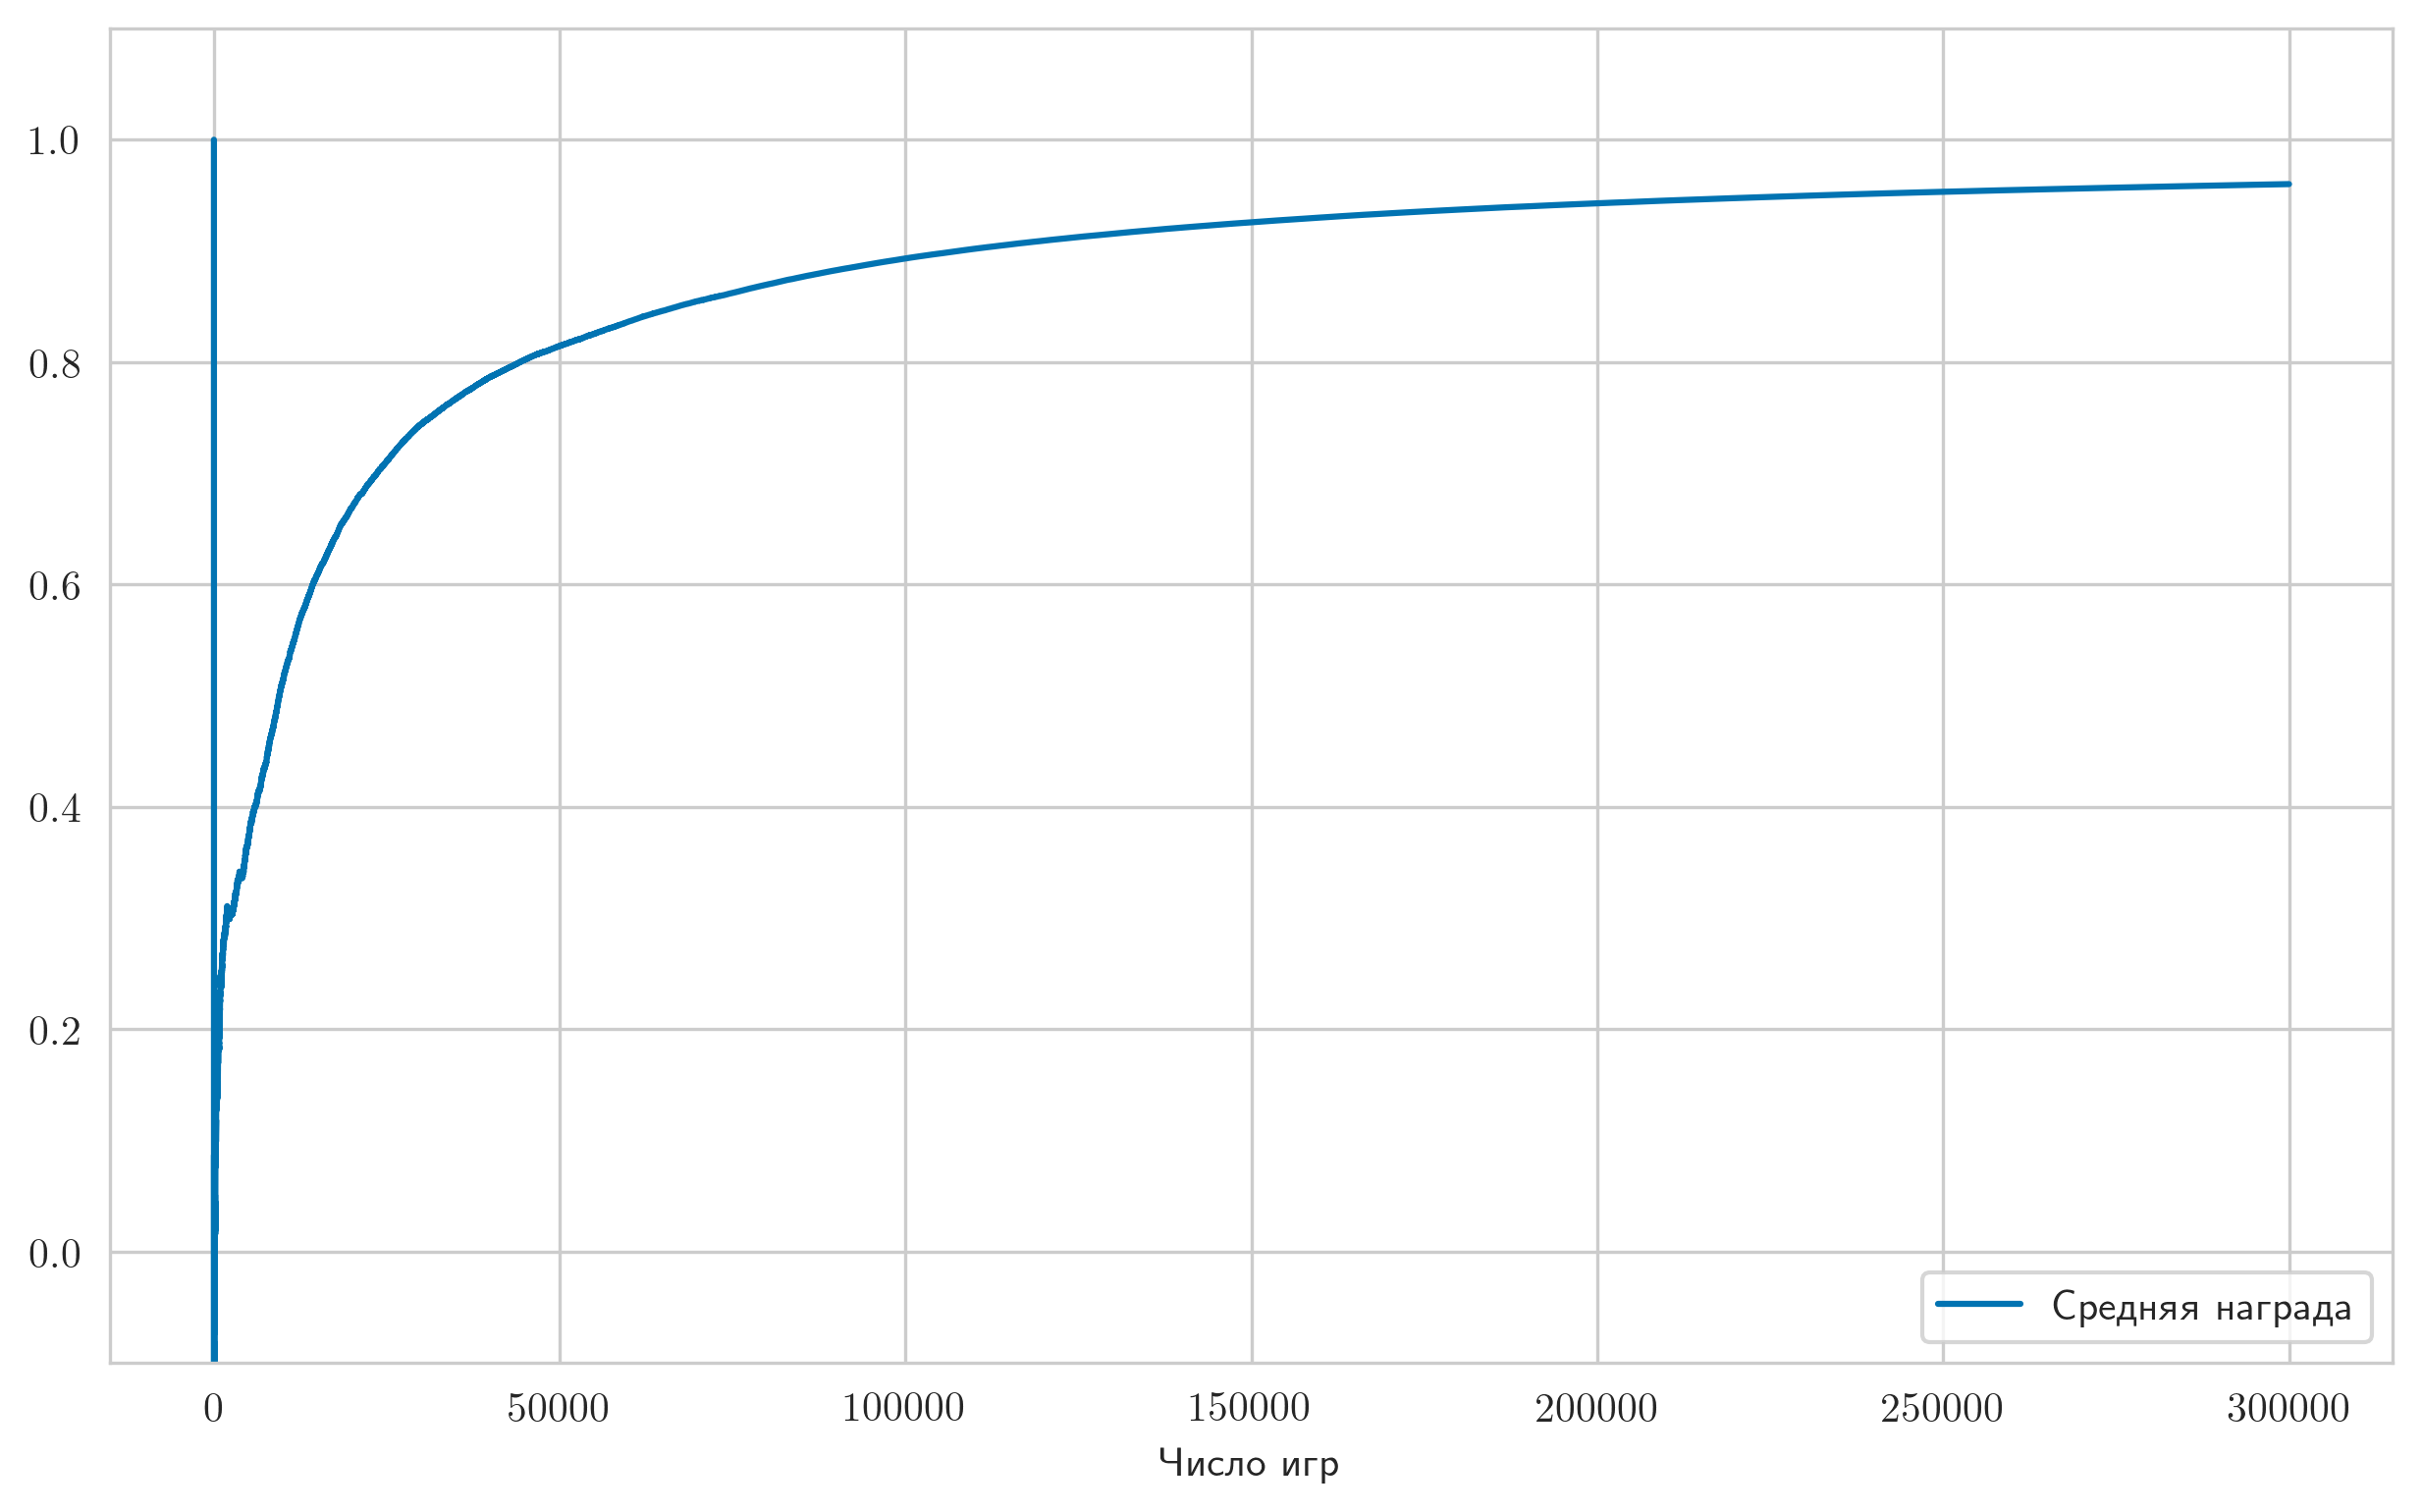

In [10]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
total_episodes = 300000
gamma = 1
alpha = 0.05
eps = 0.5

pi_crosses = Strategy()

avg_results = [0]
for n in range(total_episodes + 1):
    if n > 0 and n % 30000 == 0:
        clear_output(True)
        print(n, " episodes completed")
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        line = ax.plot(np.arange(n), avg_results[1:], label="Средняя награда", color="C0")
        ax.legend(loc="lower right")
        ax.set_ylim((-0.1, 1.1))
        ax.set_xlabel('Число игр')
        plt.show()
    Q_learning_episode_crosses(env, pi_crosses, alpha=alpha, epsilon=eps, gamma=gamma)
    reward = reward_by_strategy_matrix_crosses(env, pi_crosses)
    avg_results.append((avg_results[-1] * n + reward) / (n + 1))

env.close()

In [11]:
print("Mean_profit: ", avg_results[-1])

Mean_profit:  0.960110132966225


Отлично, крестики научились играть и стали выигрывать в 96.7% играх против случайного хода. Пора найти им достойного соперника.

In [12]:
def Q_learning_episode_naughts(env, pi_crosses, pi_naughts, alpha=0.05, epsilon=0.0, gamma=0.9):
    env.reset()
    cur_hash, options, cur_turn = env.getState()
    a = pi_crosses.getActionGreedy(cur_hash)
    observation, reward, done, info = env.step(options[a])
    cur_hash = env.getState()[0]
    a = pi_naughts.getActionGreedy(cur_hash) if np.random.rand() > epsilon else np.random.randint(len(observation[1]))
    for _ in range(1000):
        options = env.getEmptySpaces()
        cur_hash = env.getState()[0]
        observation, reward, done, info = env.step(options[a])
        reward *= -1
        if not done:
            cross_a = pi_crosses.getActionGreedy(observation[0])
            observation, reward, done, info = env.step(observation[1][cross_a])
            reward *= -1
        hash_prime = observation[0]
        if not done:
            a_prime = pi_naughts.getActionGreedy(hash_prime) if np.random.rand() > epsilon else np.random.randint(len(observation[1]))
            pi_naughts.Q[cur_hash][a] += alpha * (reward + gamma * np.max(pi_naughts.Q[hash_prime]) - pi_naughts.Q[cur_hash][a])
        else:
            pi_naughts.Q[cur_hash][a] += alpha * (reward + gamma - pi_naughts.Q[cur_hash][a])
        cur_hash, a = hash_prime, a_prime
        if done:
            break

In [13]:
def reward_by_strategy_matrix_naughts(env, pi_crosses, pi_naughts):
    env.reset()
    cur_hash = env.getState()[0]
    a = pi_crosses.getActionGreedy(cur_hash)
    options = env.getEmptySpaces()
    observation, reward, done, info = env.step(options[a])
    game_finished = done
    
    while not game_finished:
        actions = env.getEmptySpaces()
        cur_hash = env.getState()[0]
        cur_state, reward, game_finished, _ = env.step(actions[pi_naughts.getActionGreedy(cur_hash)])
        if game_finished:
            break
        cross_a = pi_crosses.getActionGreedy(cur_state[0])
        cur_state, reward, game_finished, _ = env.step(cur_state[1][cross_a])
        cur_hash = cur_state[0]
    return reward*(-1)

Будем обучать играть нолики сразу на очень серьезном сопернике - обученных крестиках)

300000  episodes completed


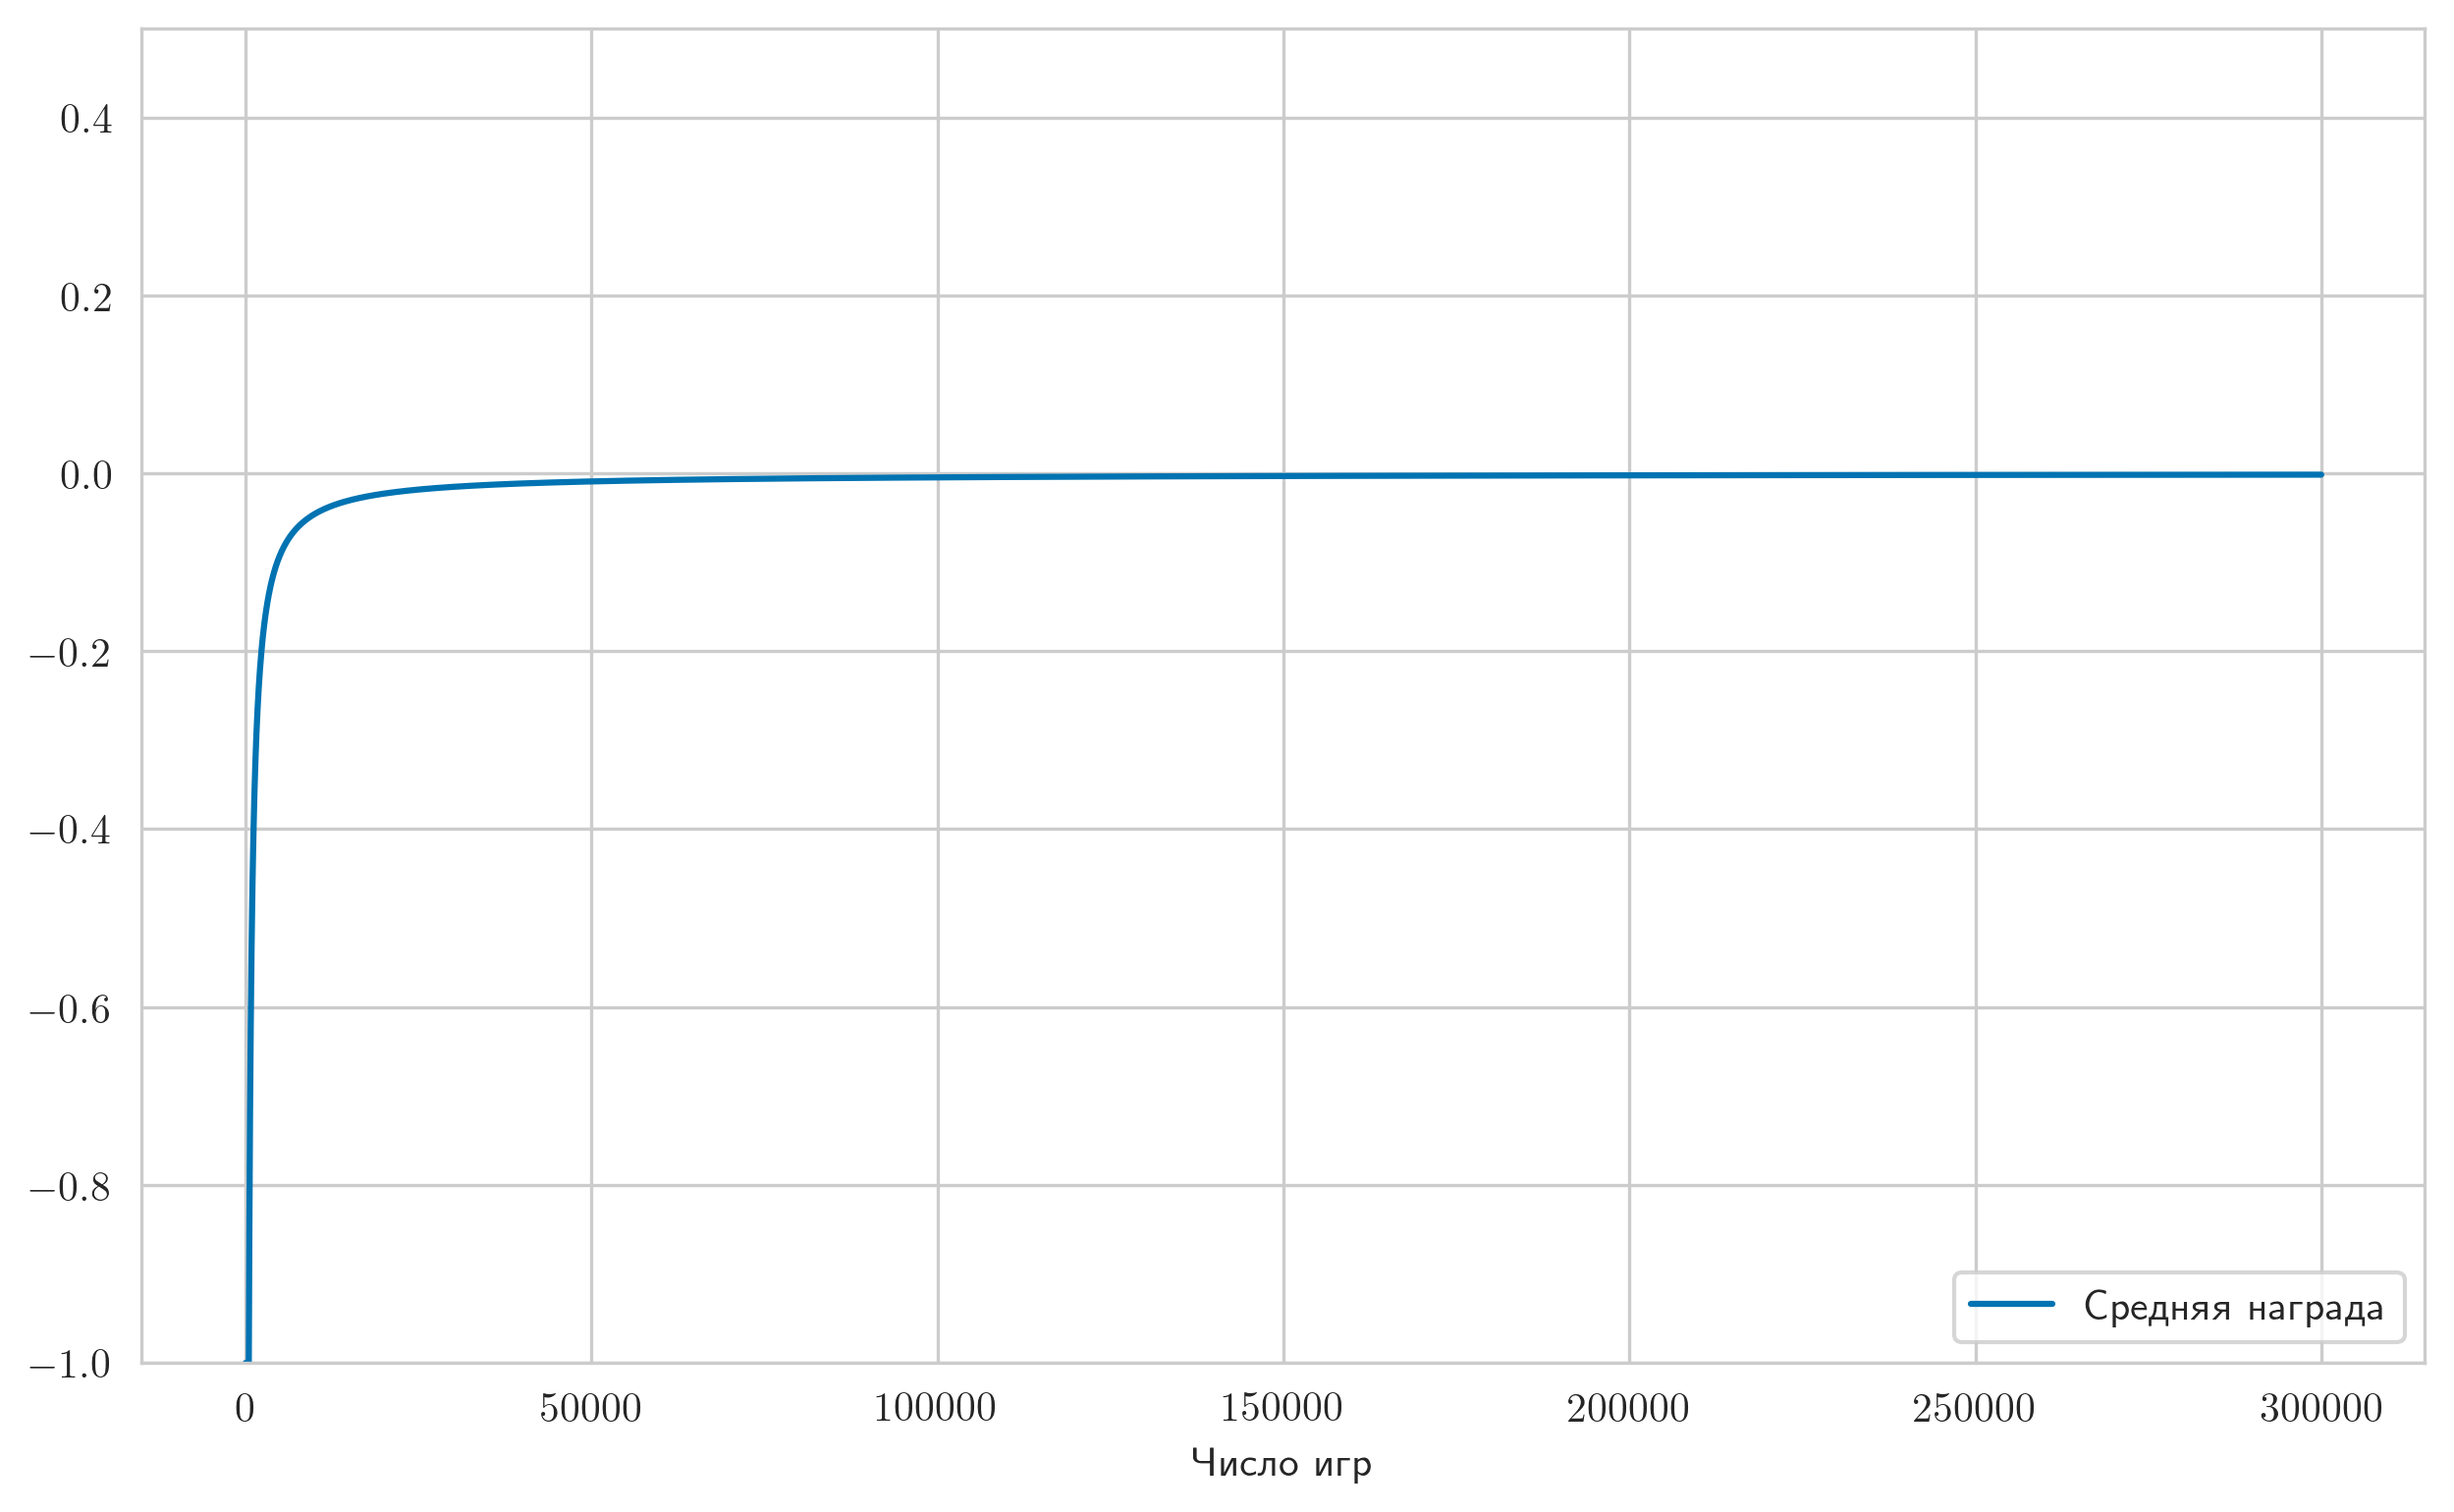

In [14]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
total_episodes = 300000
gamma = 1
alpha = 0.05
eps = 0.5

pi_naughts = Strategy(n_rows=3, n_cols=3)

avg_results = [0]
for n in range(total_episodes + 1):
    if n > 0 and n % 30000 == 0:
        clear_output(True)
        print(n, " episodes completed")
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        line = ax.plot(np.arange(n), avg_results[1:], label="Средняя награда", color="C0")
        ax.legend(loc="lower right")
        ax.set_ylim((-1, 0.5))
        ax.set_xlabel('Число игр')
        plt.show()
    Q_learning_episode_naughts(env, pi_crosses, pi_naughts, alpha=alpha, epsilon=eps, gamma=gamma)
    reward = reward_by_strategy_matrix_naughts(env, pi_crosses, pi_naughts)
    avg_results.append((avg_results[-1] * n + reward) / (n + 1))

env.close()

Нетрудно заметить, что нолики научились играть в ничью.

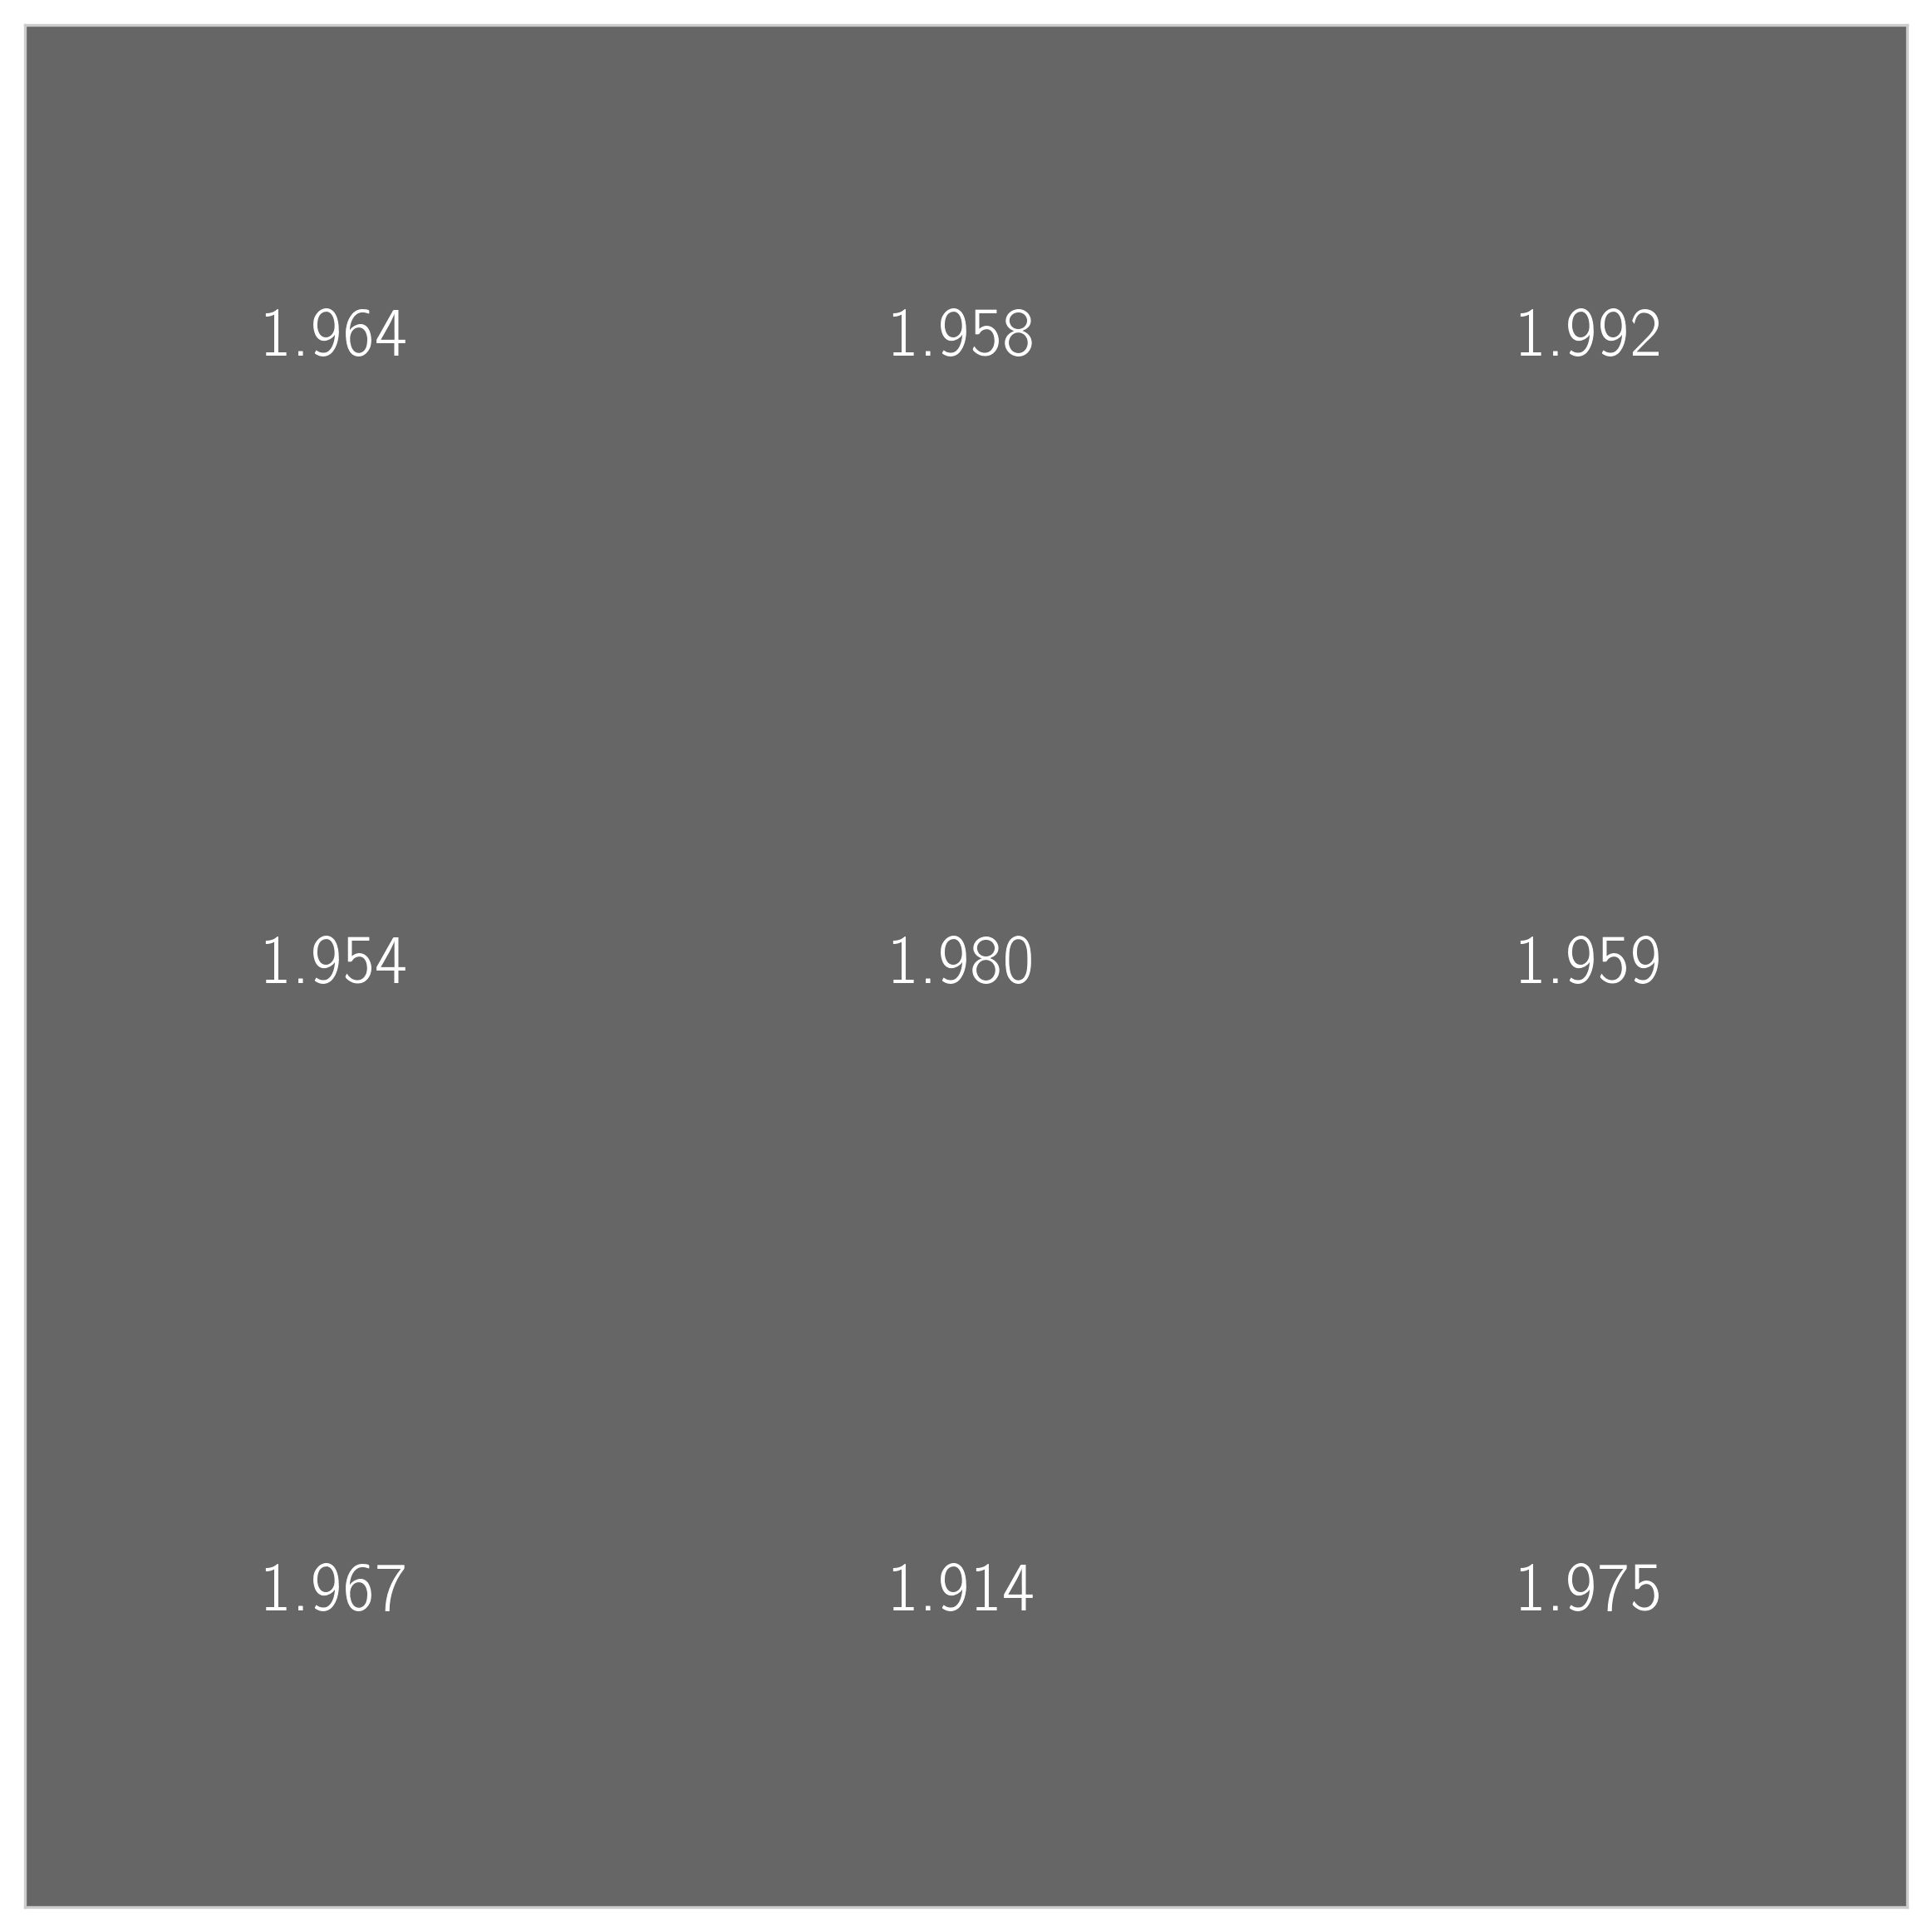

0 [0 0] 1.964477313208442
1 [0 1] 1.9575480728382026
2 [0 2] 1.9916113176832275
3 [1 0] 1.9535398651558389
4 [1 1] 1.9803076017277372
5 [1 2] 1.9586216245949173
6 [2 0] 1.9673344251898006
7 [2 1] 1.9141913472060366
8 [2 2] 1.974610272674971


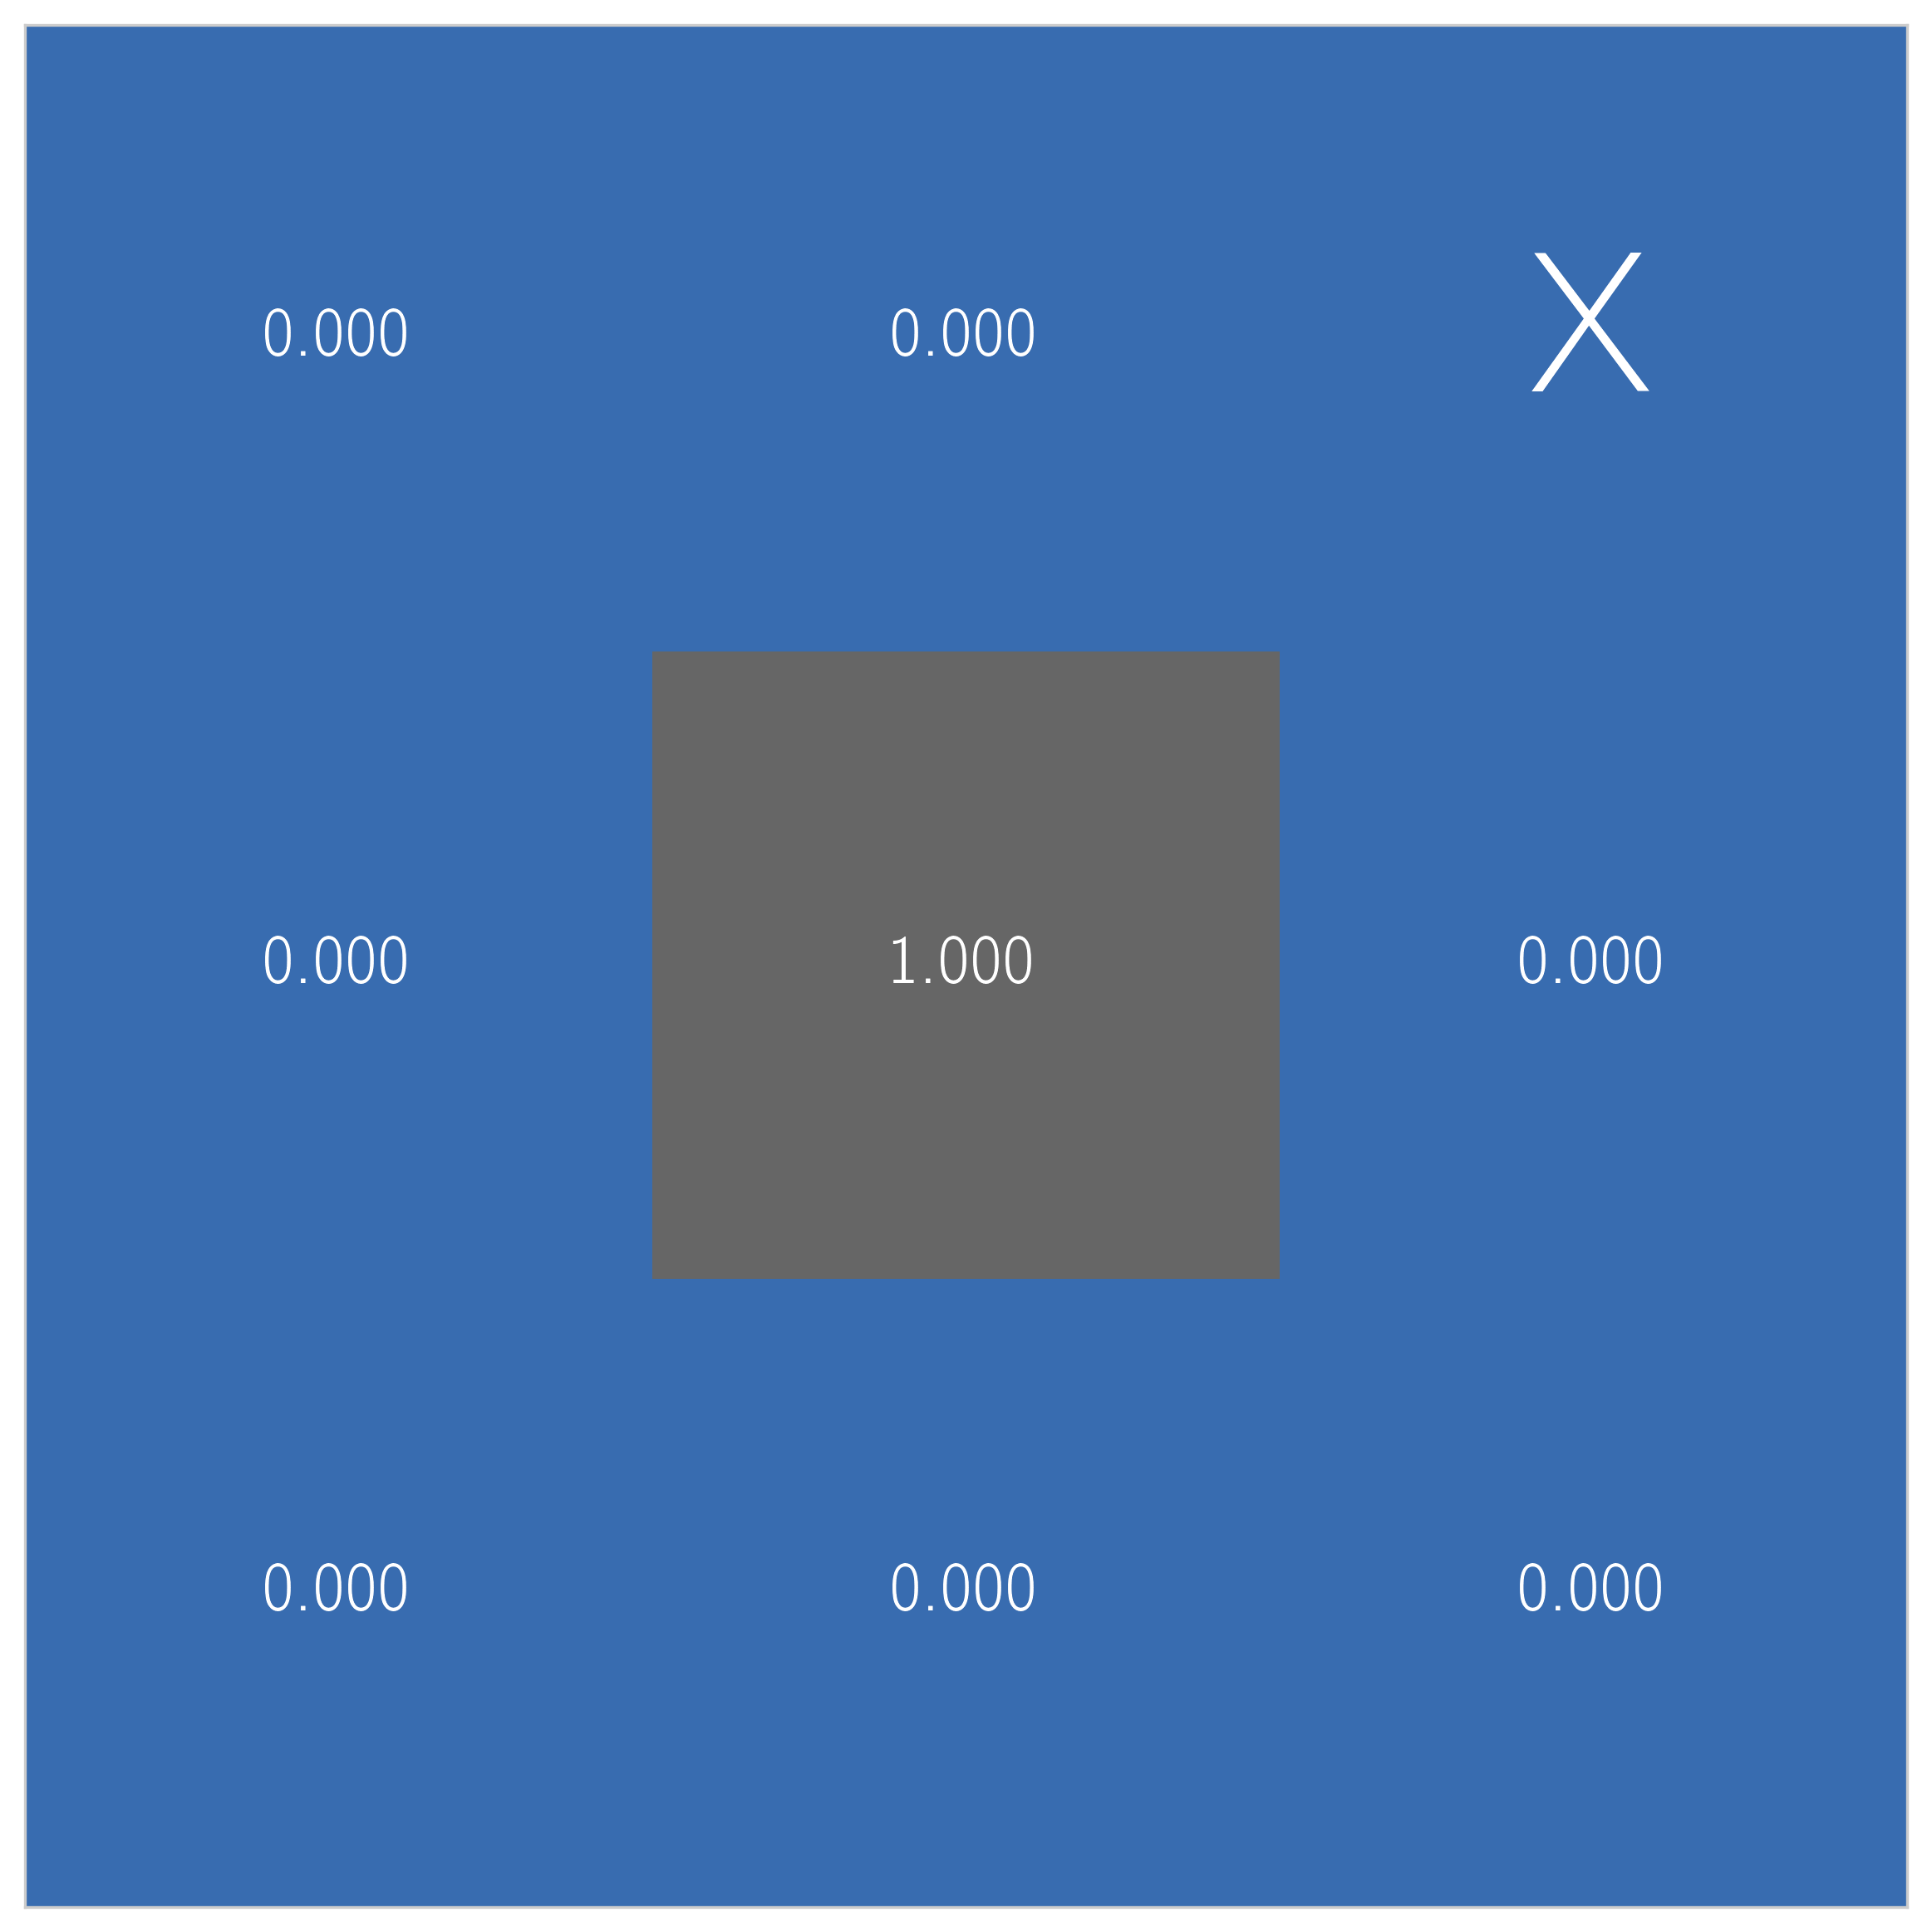

0 [0 0] 4.998879530649098e-35
1 [0 1] 5.064880636579761e-32
2 [1 0] 1.108562058122537e-47
3 [1 1] 0.9999999999999956
4 [1 2] 1.5481138003797663e-27
5 [2 0] 2.850205662660203e-21
6 [2 1] 1.1611569153073752e-42
7 [2 2] 1.3186226702263601e-42


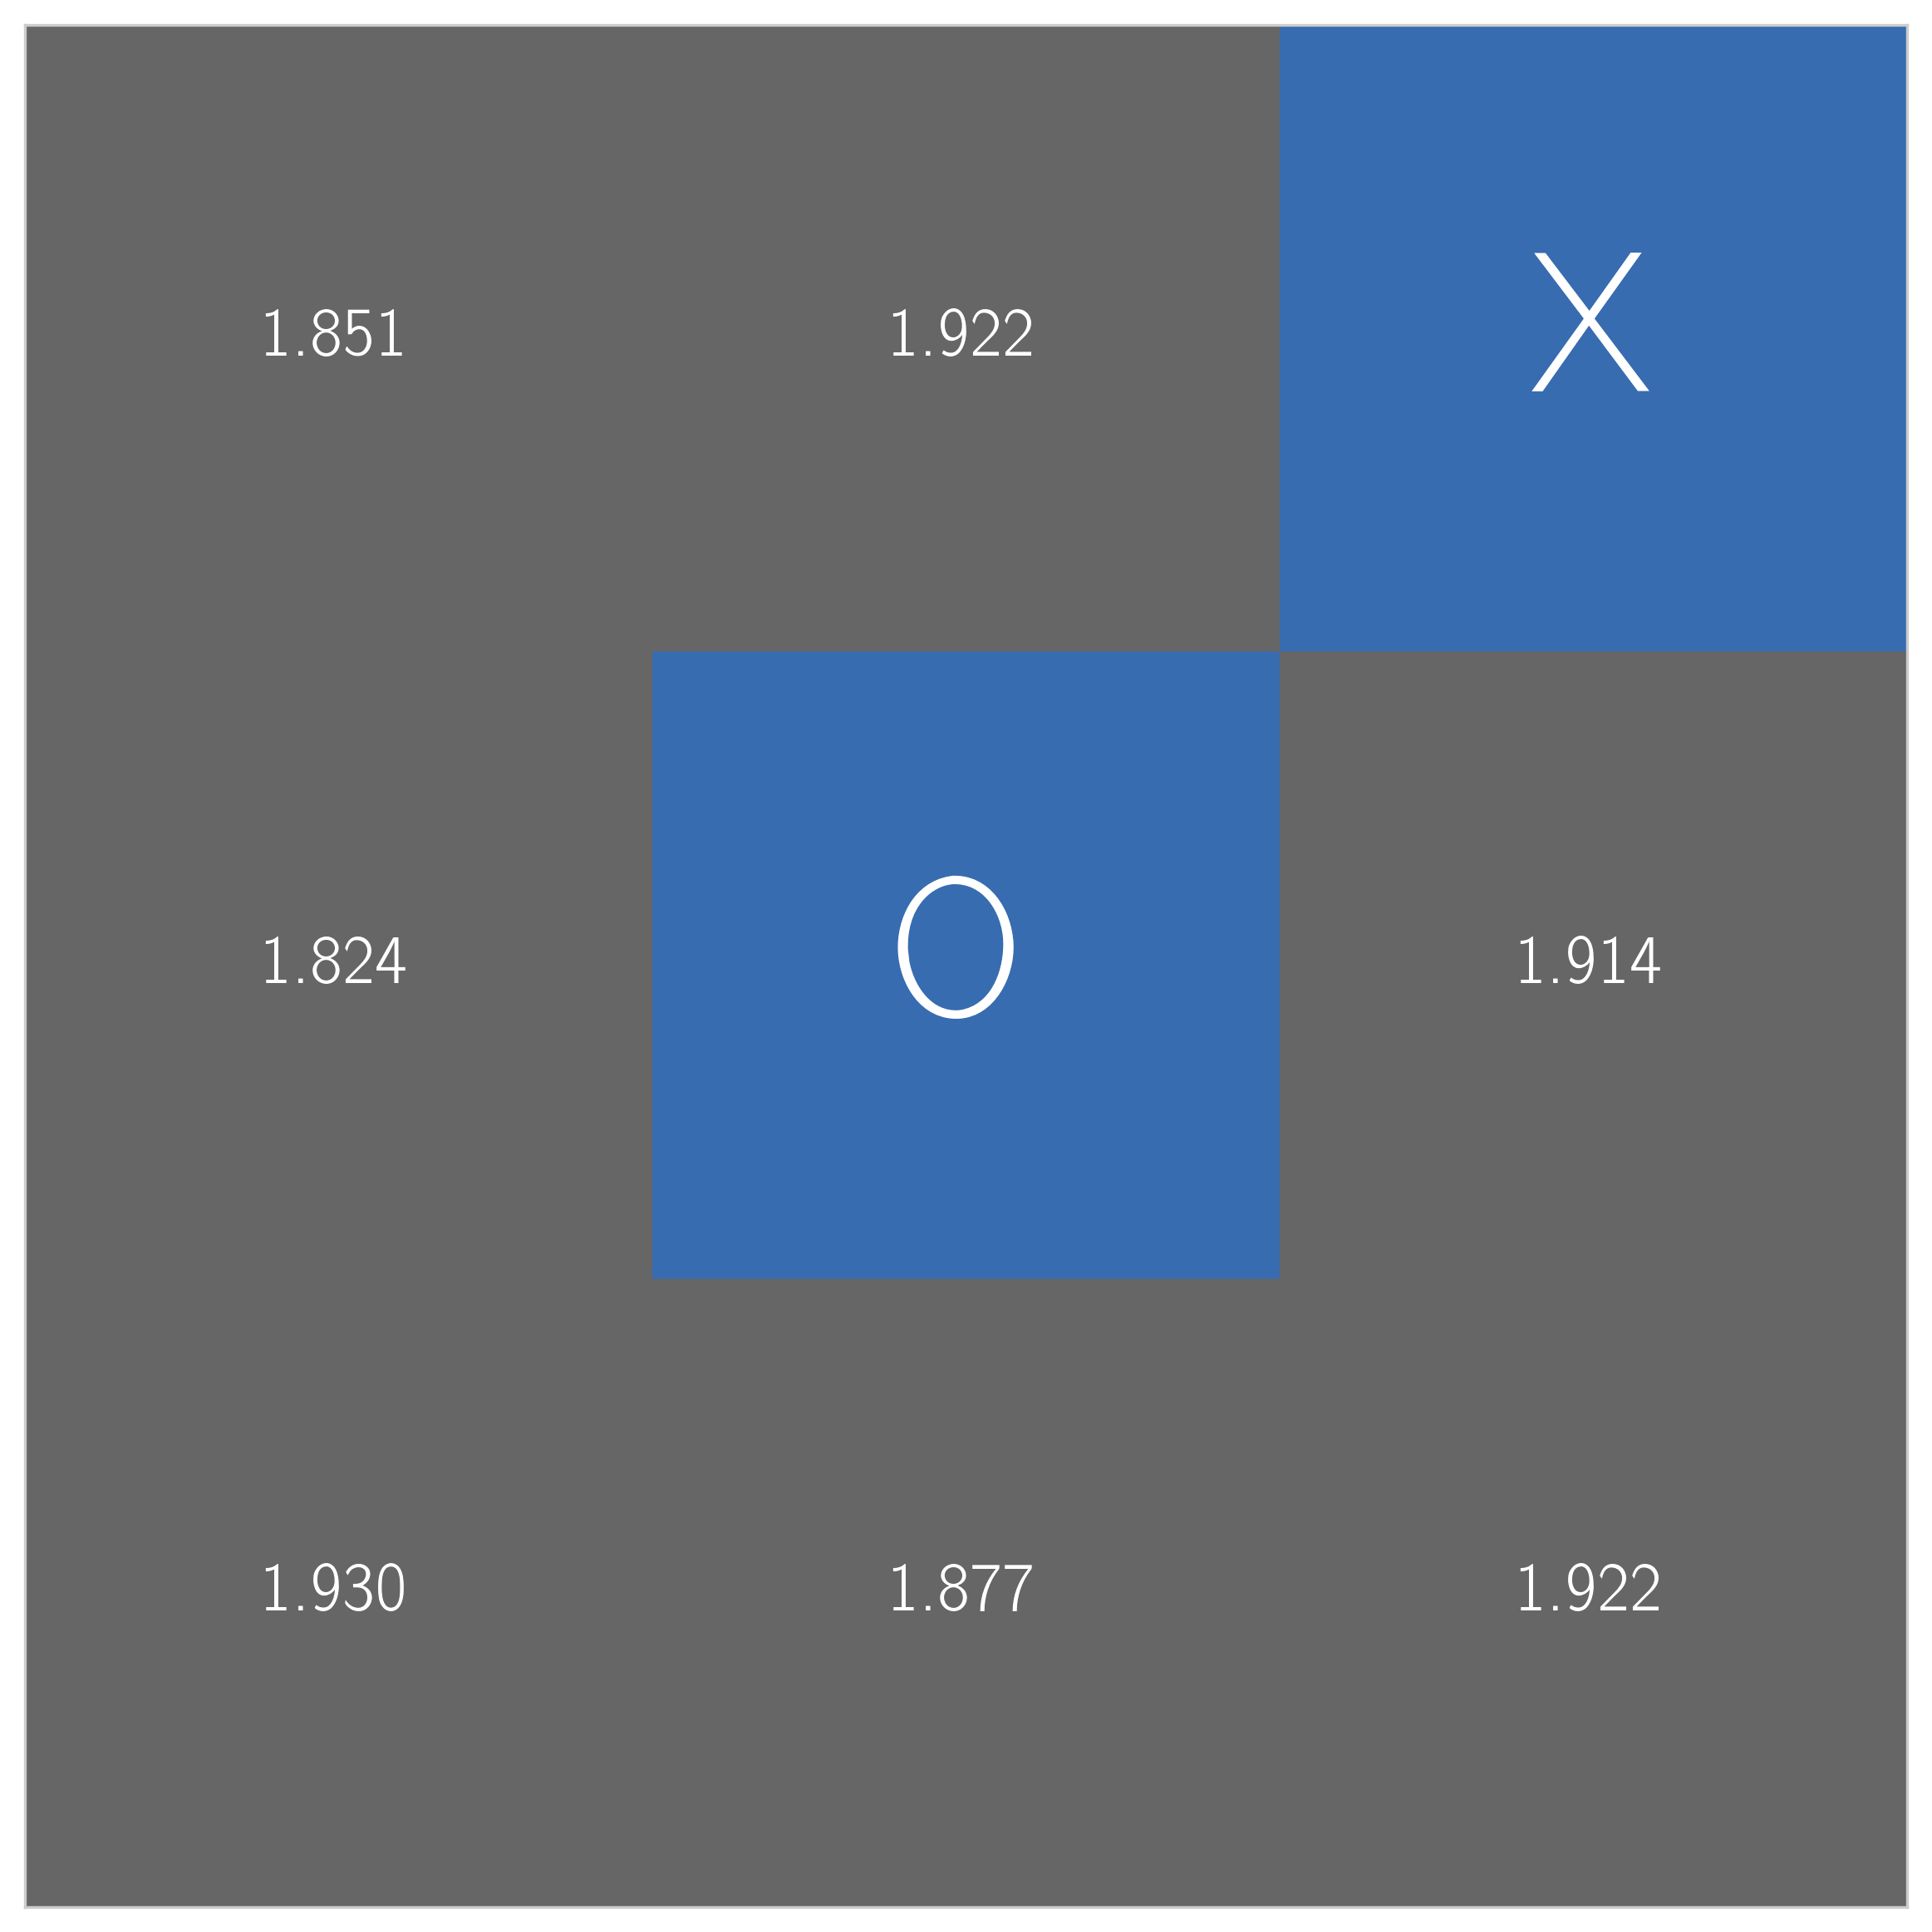

0 [0 0] 1.8511037117758302
1 [0 1] 1.9220896696652818
2 [1 0] 1.824319047794995
3 [1 2] 1.9137295626167308
4 [2 0] 1.9301687854579668
5 [2 1] 1.8766305727650228
6 [2 2] 1.9216983089627993


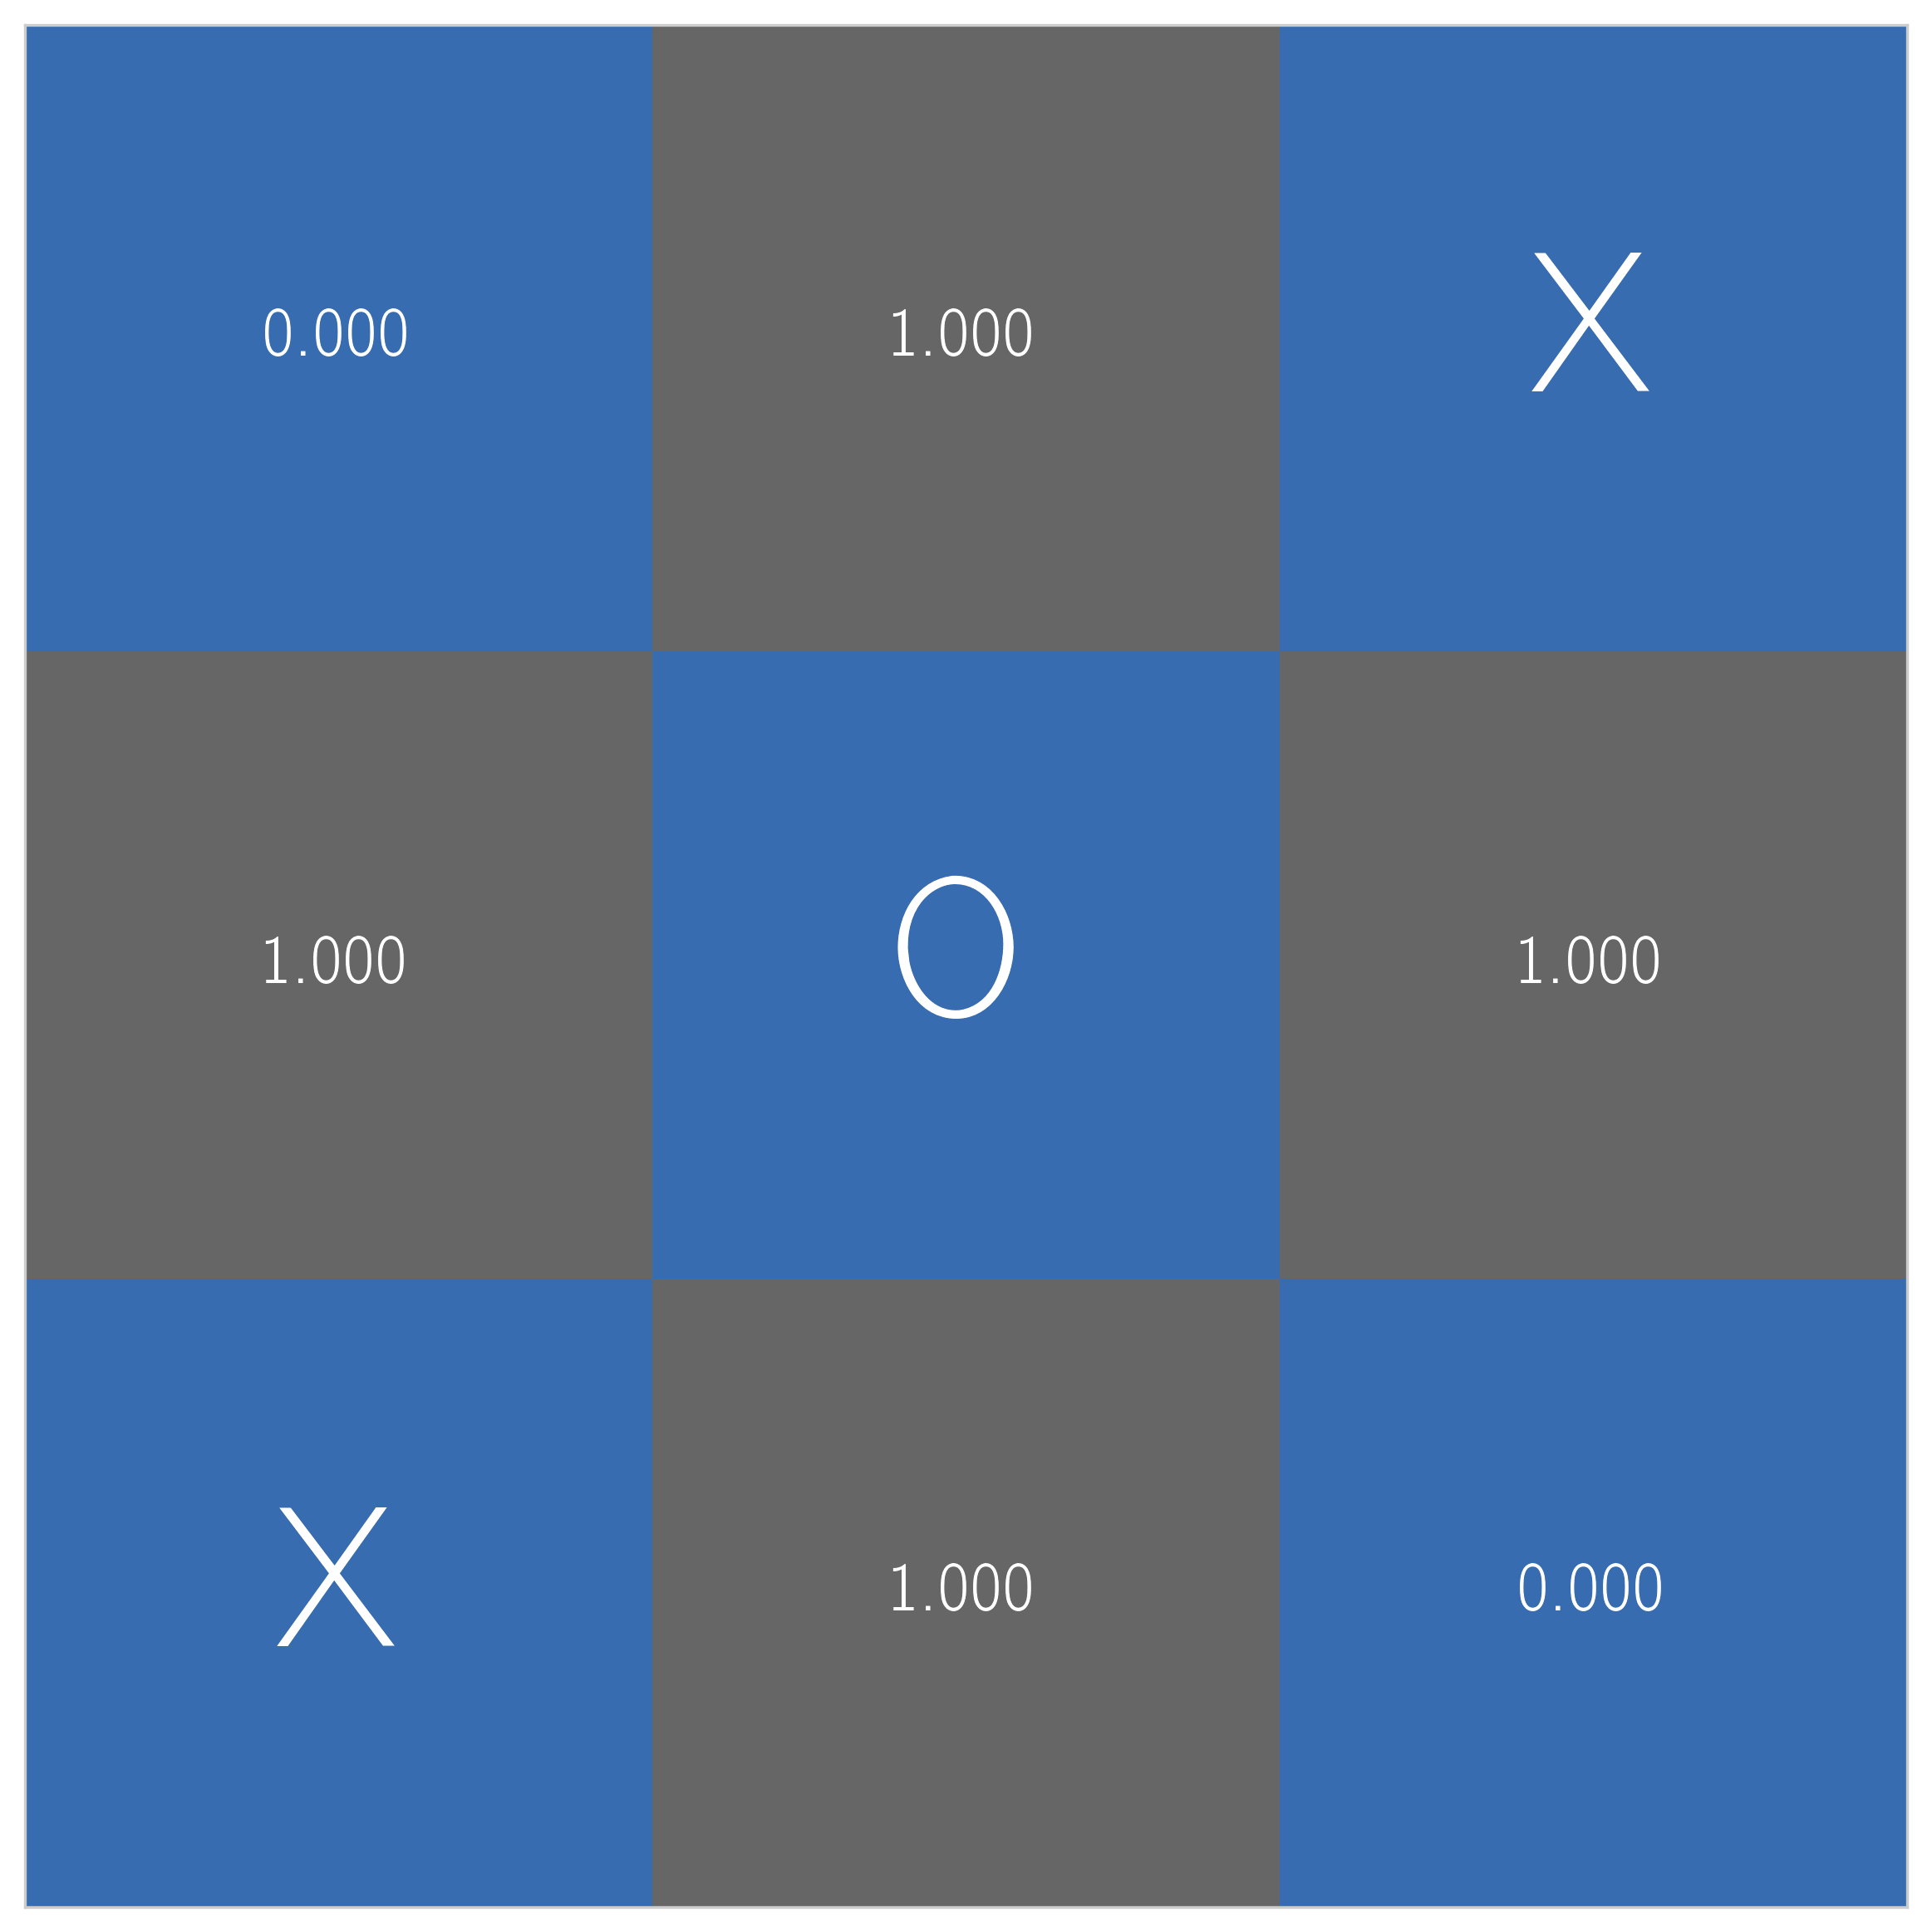

0 [0 0] 4.2110068298271294e-79
1 [0 1] 0.9999999999999967
2 [1 0] 0.9999999999999967
3 [1 2] 0.9999999999999967
4 [2 1] 0.9999999999999967
5 [2 2] 5.090538035739882e-79


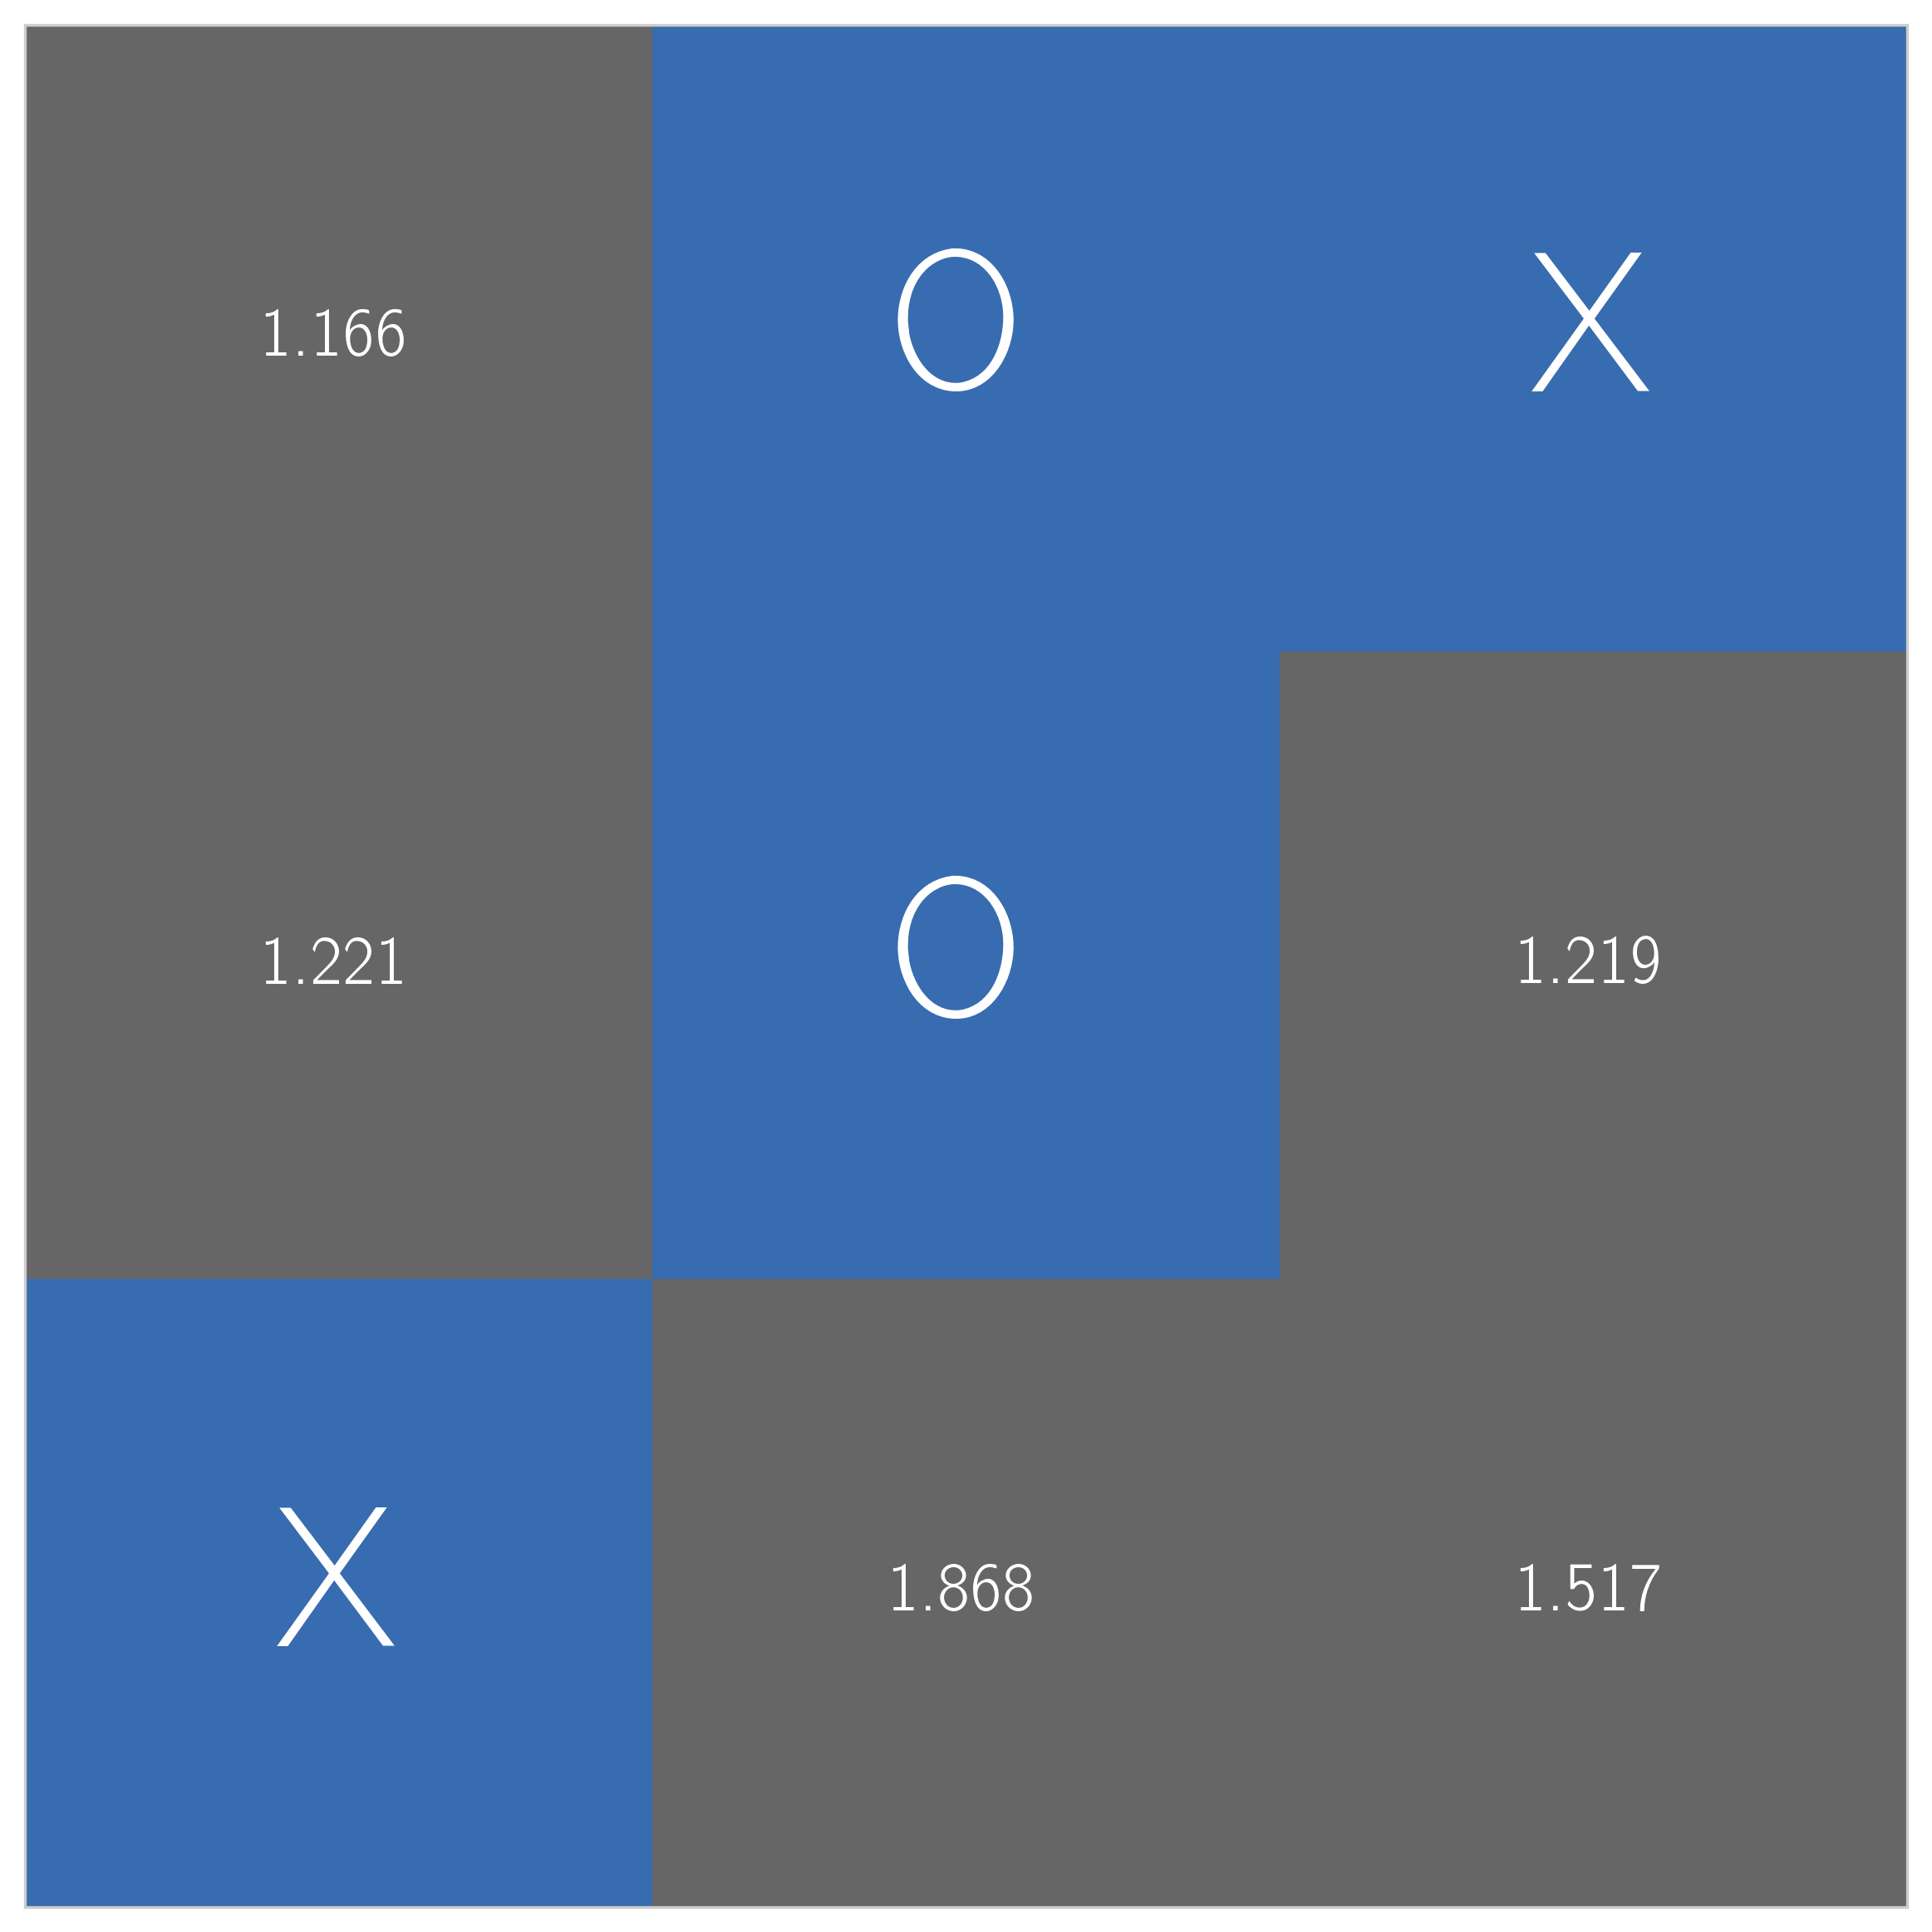

0 [0 0] 1.1661117195246742
1 [1 0] 1.2205465495991215
2 [1 2] 1.2193290009186513
3 [2 1] 1.867533805877848
4 [2 2] 1.5174741849778601


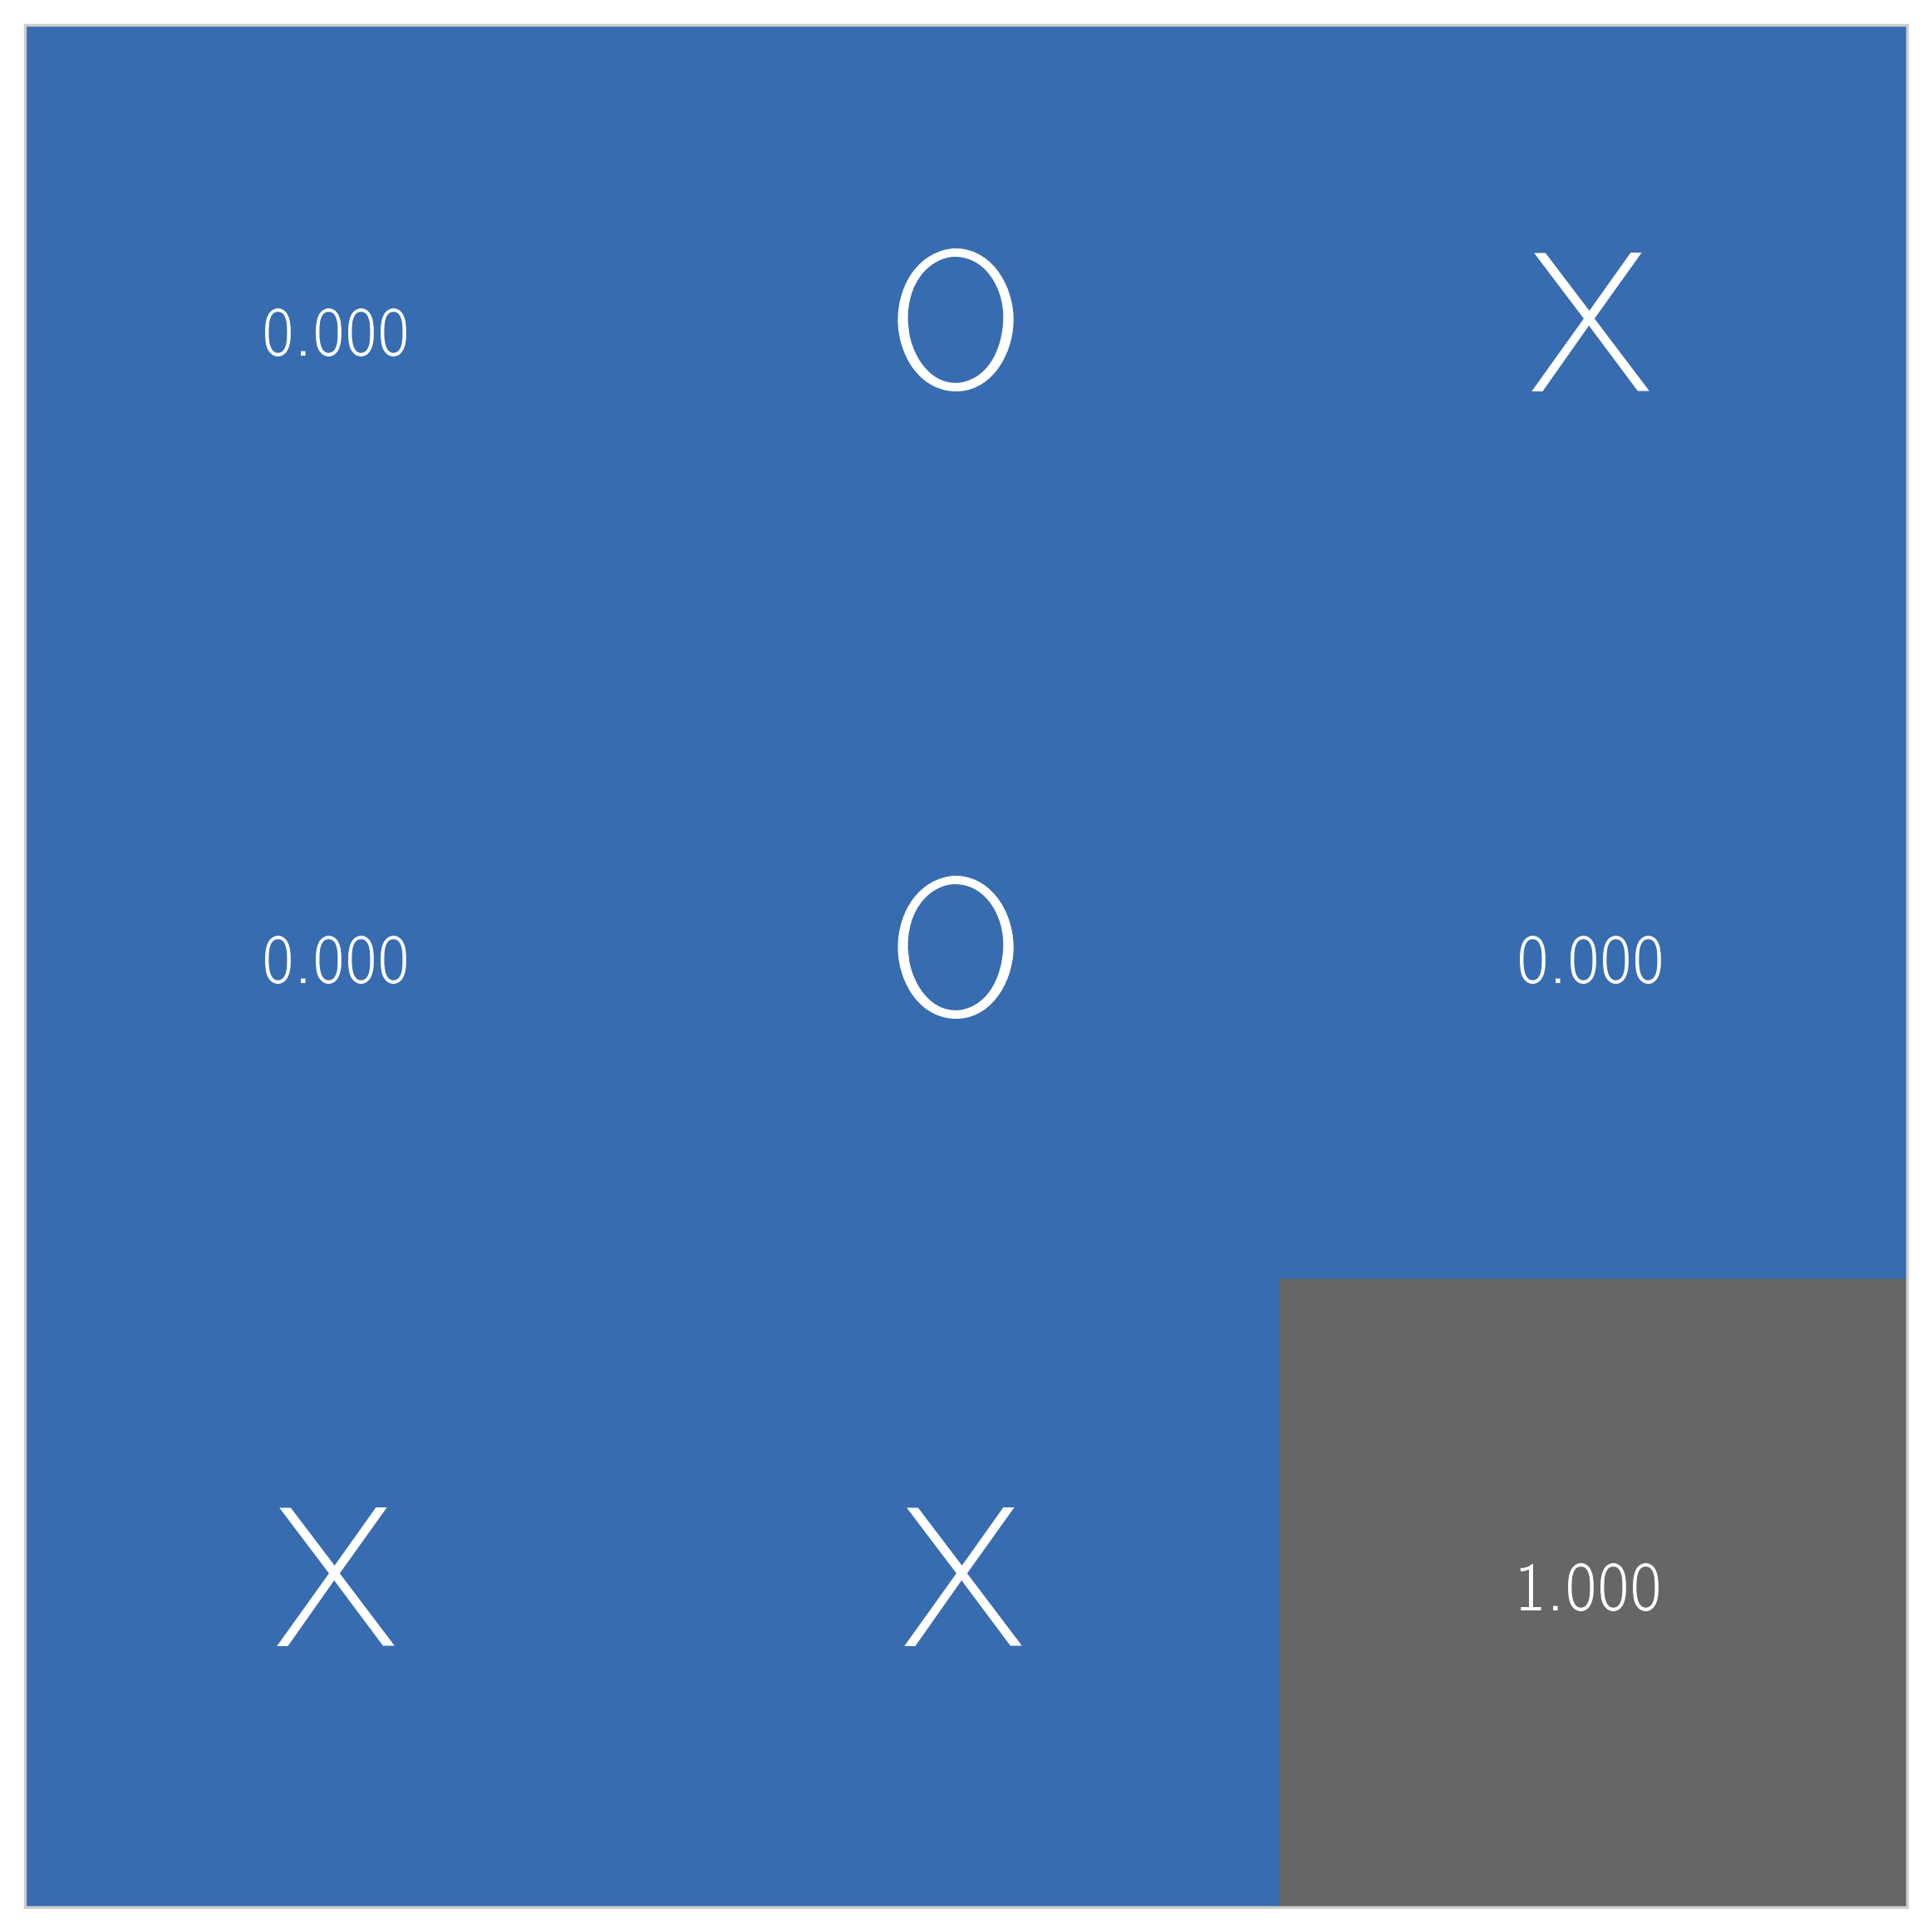

0 [0 0] 3.2017224222655643e-252
1 [1 0] 3.60452922409993e-250
2 [1 2] 1.3767747629301252e-248
3 [2 2] 0.9999999999999978


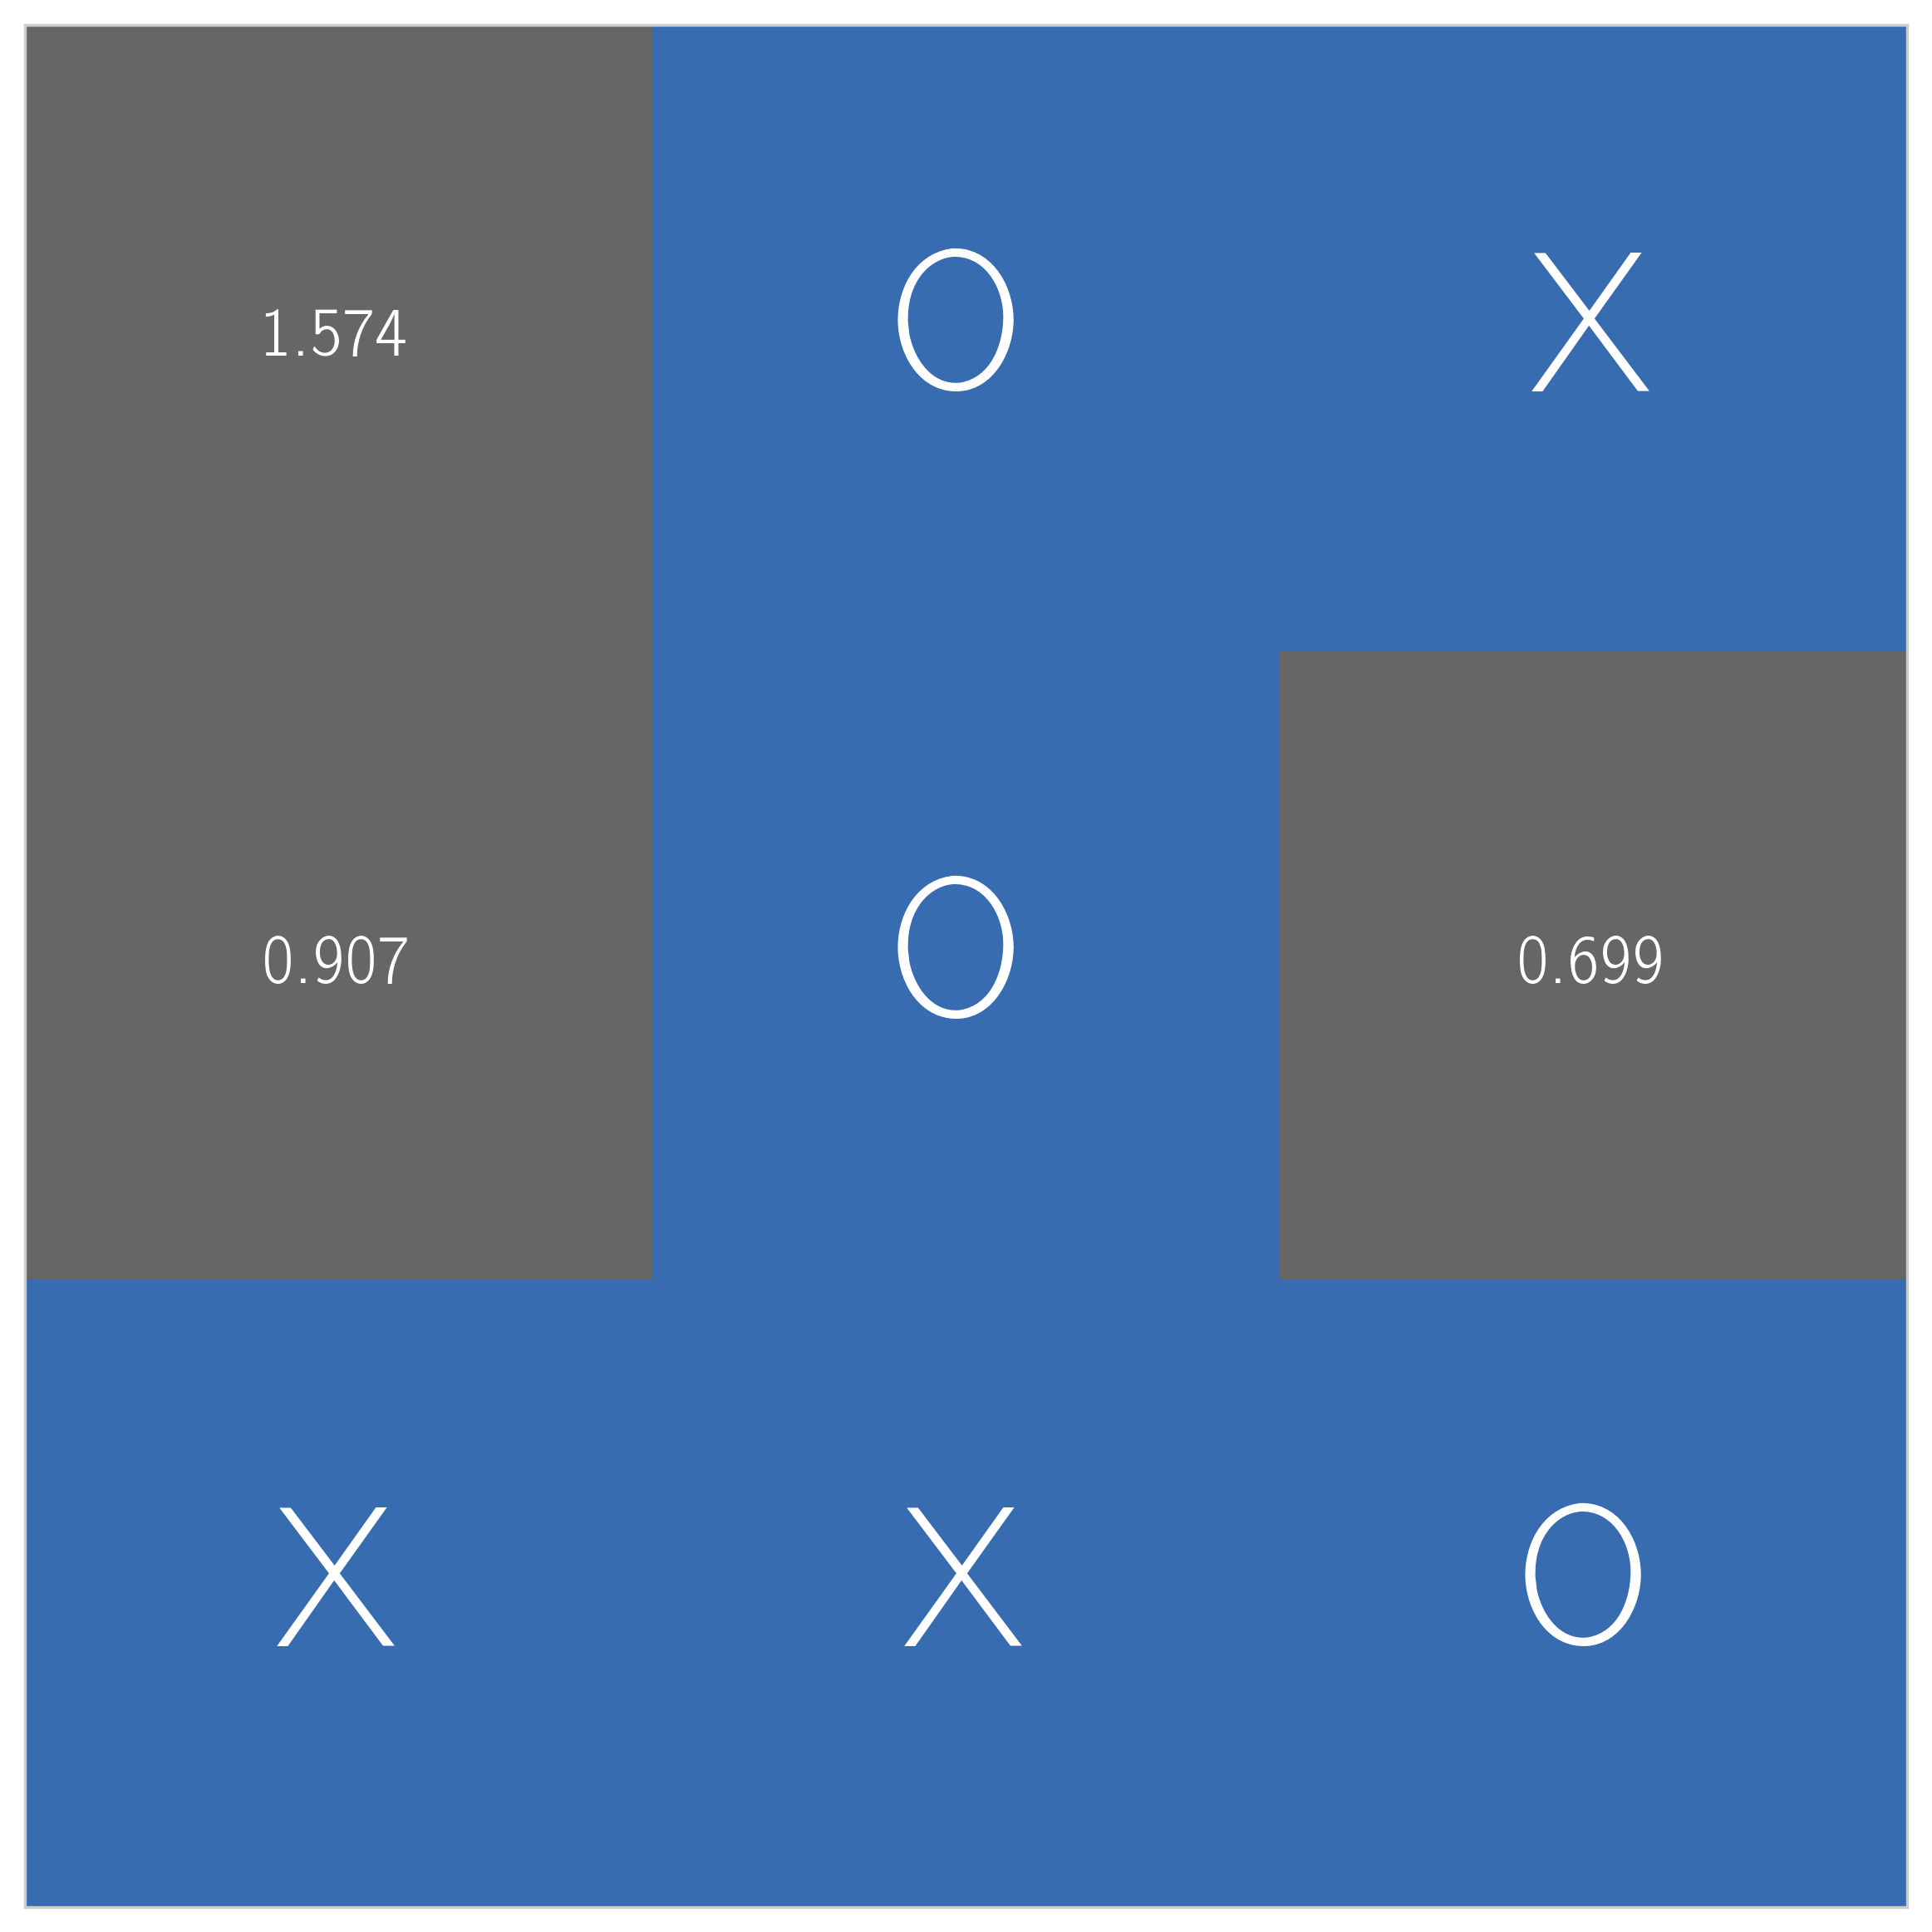

0 [0 0] 1.5742435560795702
1 [1 0] 0.907282508929776
2 [1 2] 0.698982844230546


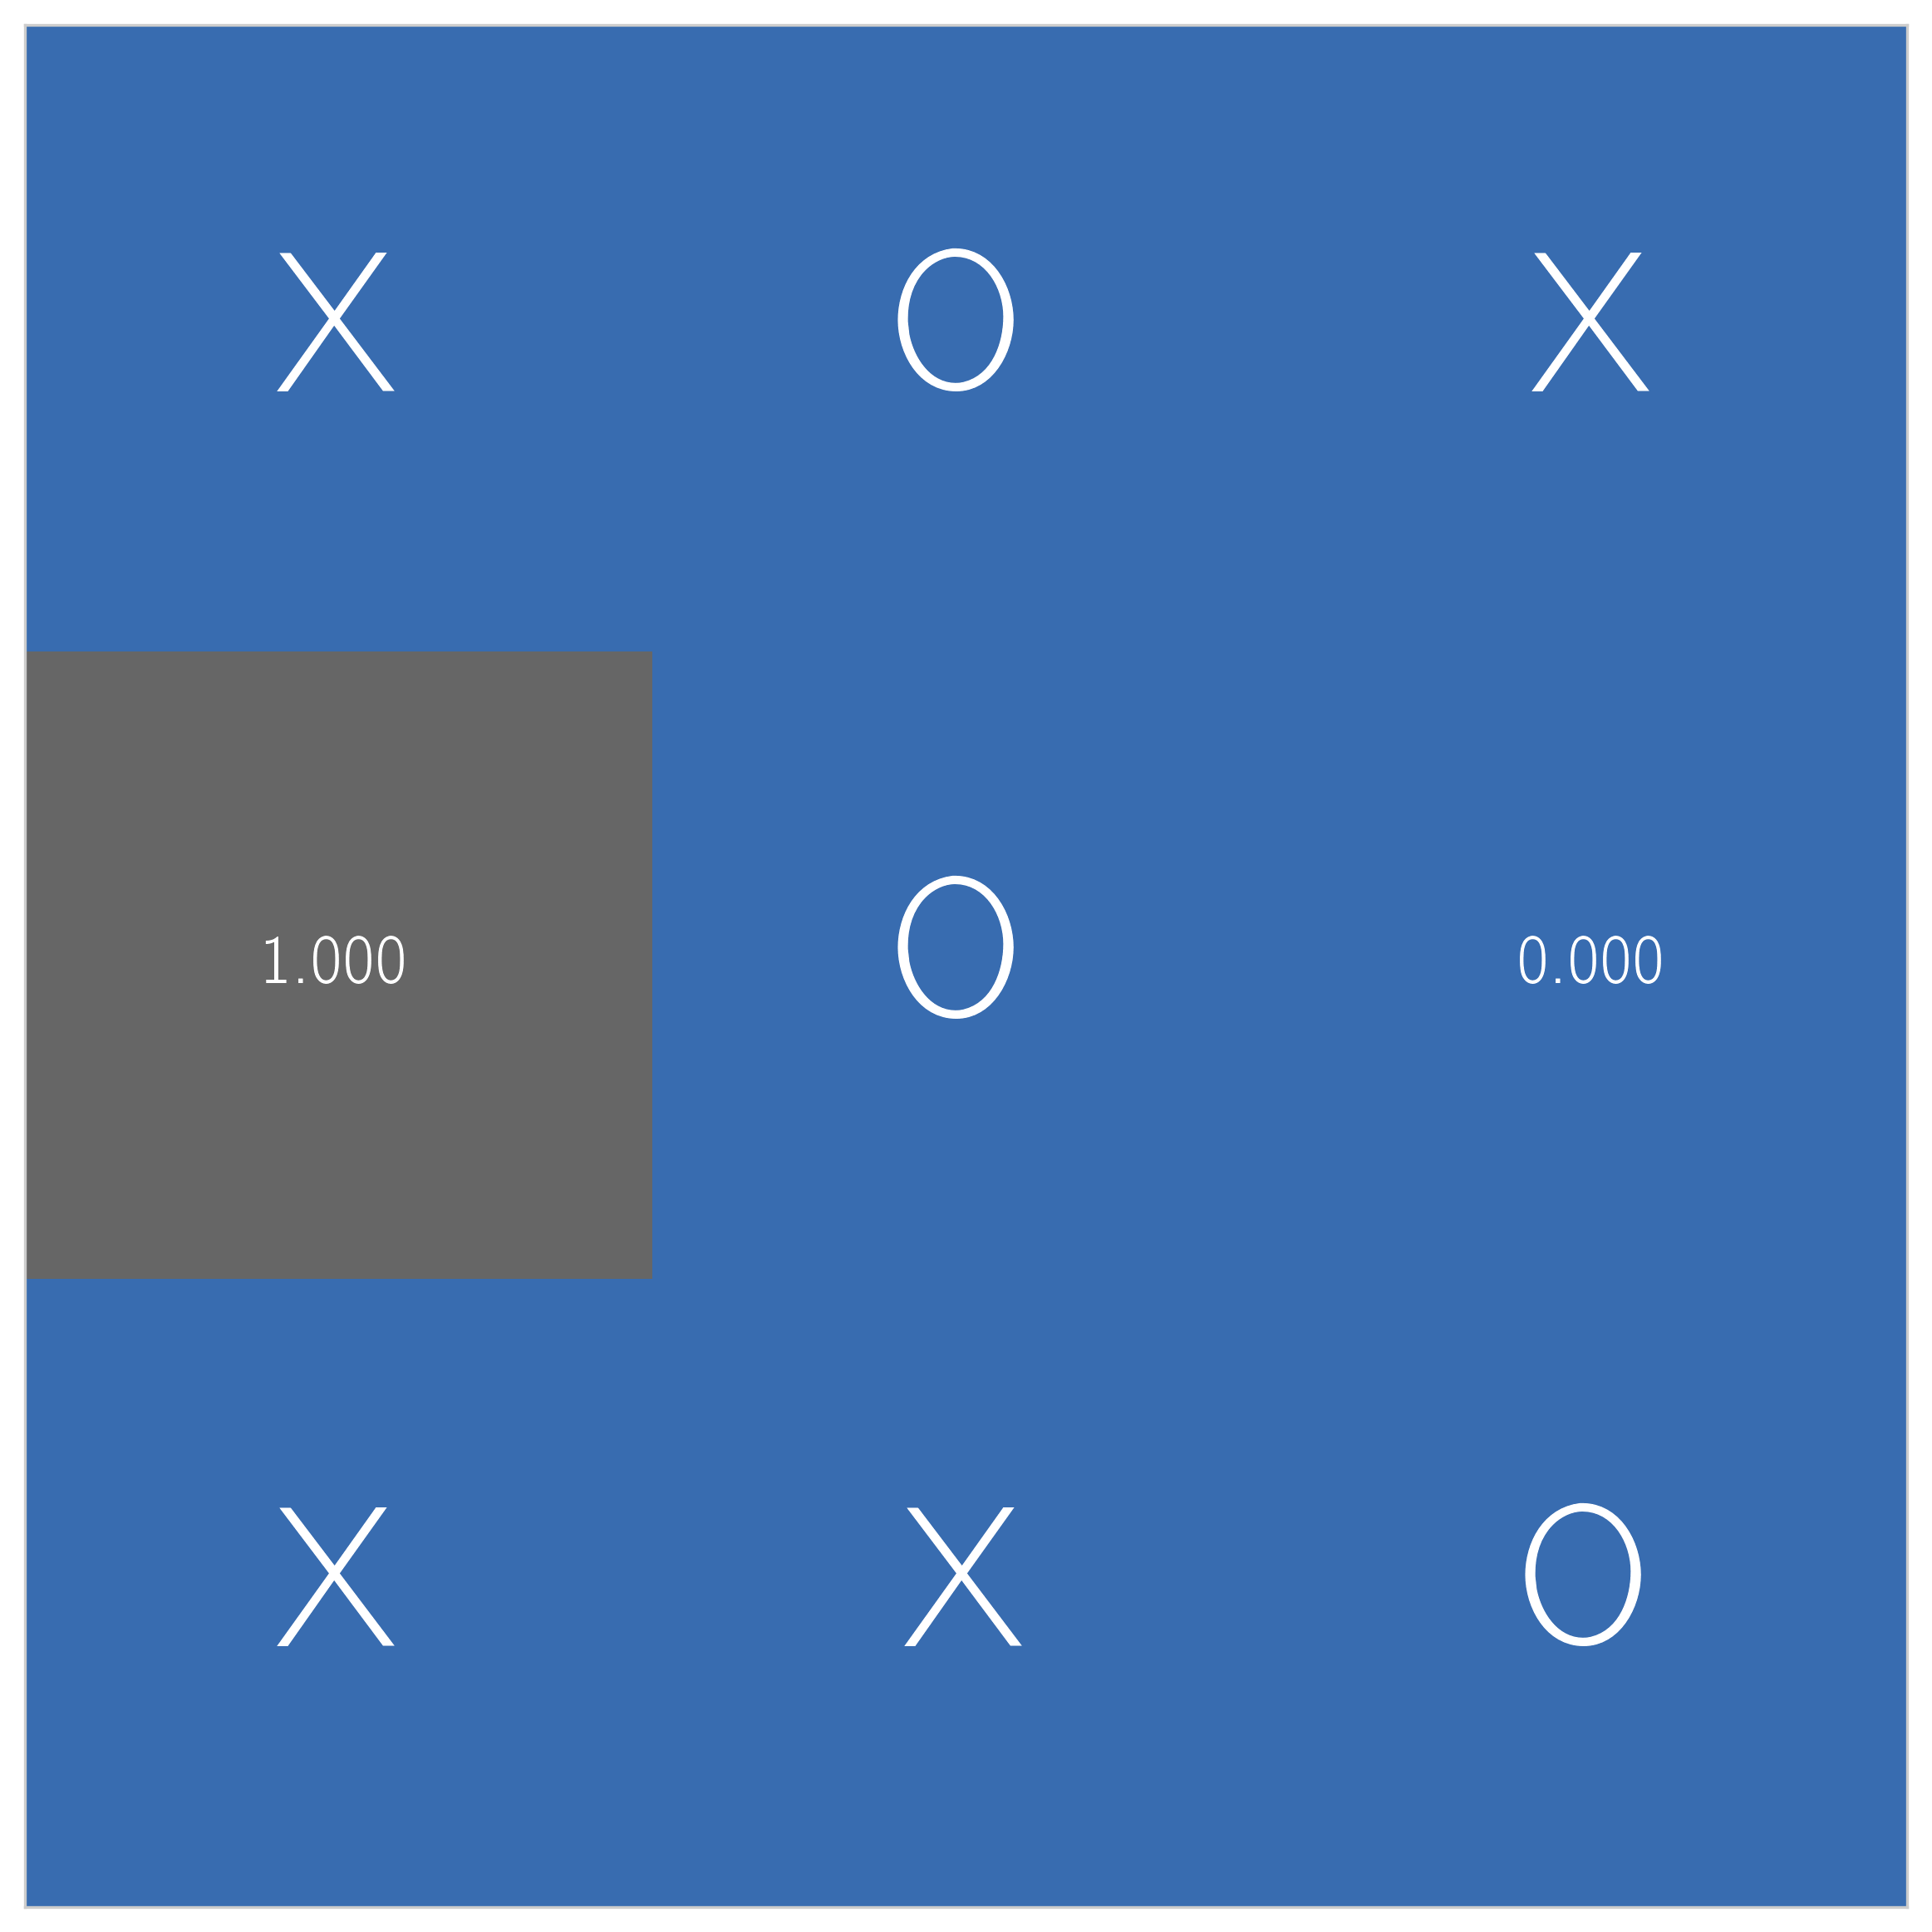

0 [1 0] 0.9999999999999989
1 [1 2] 7.4153168157253e-311


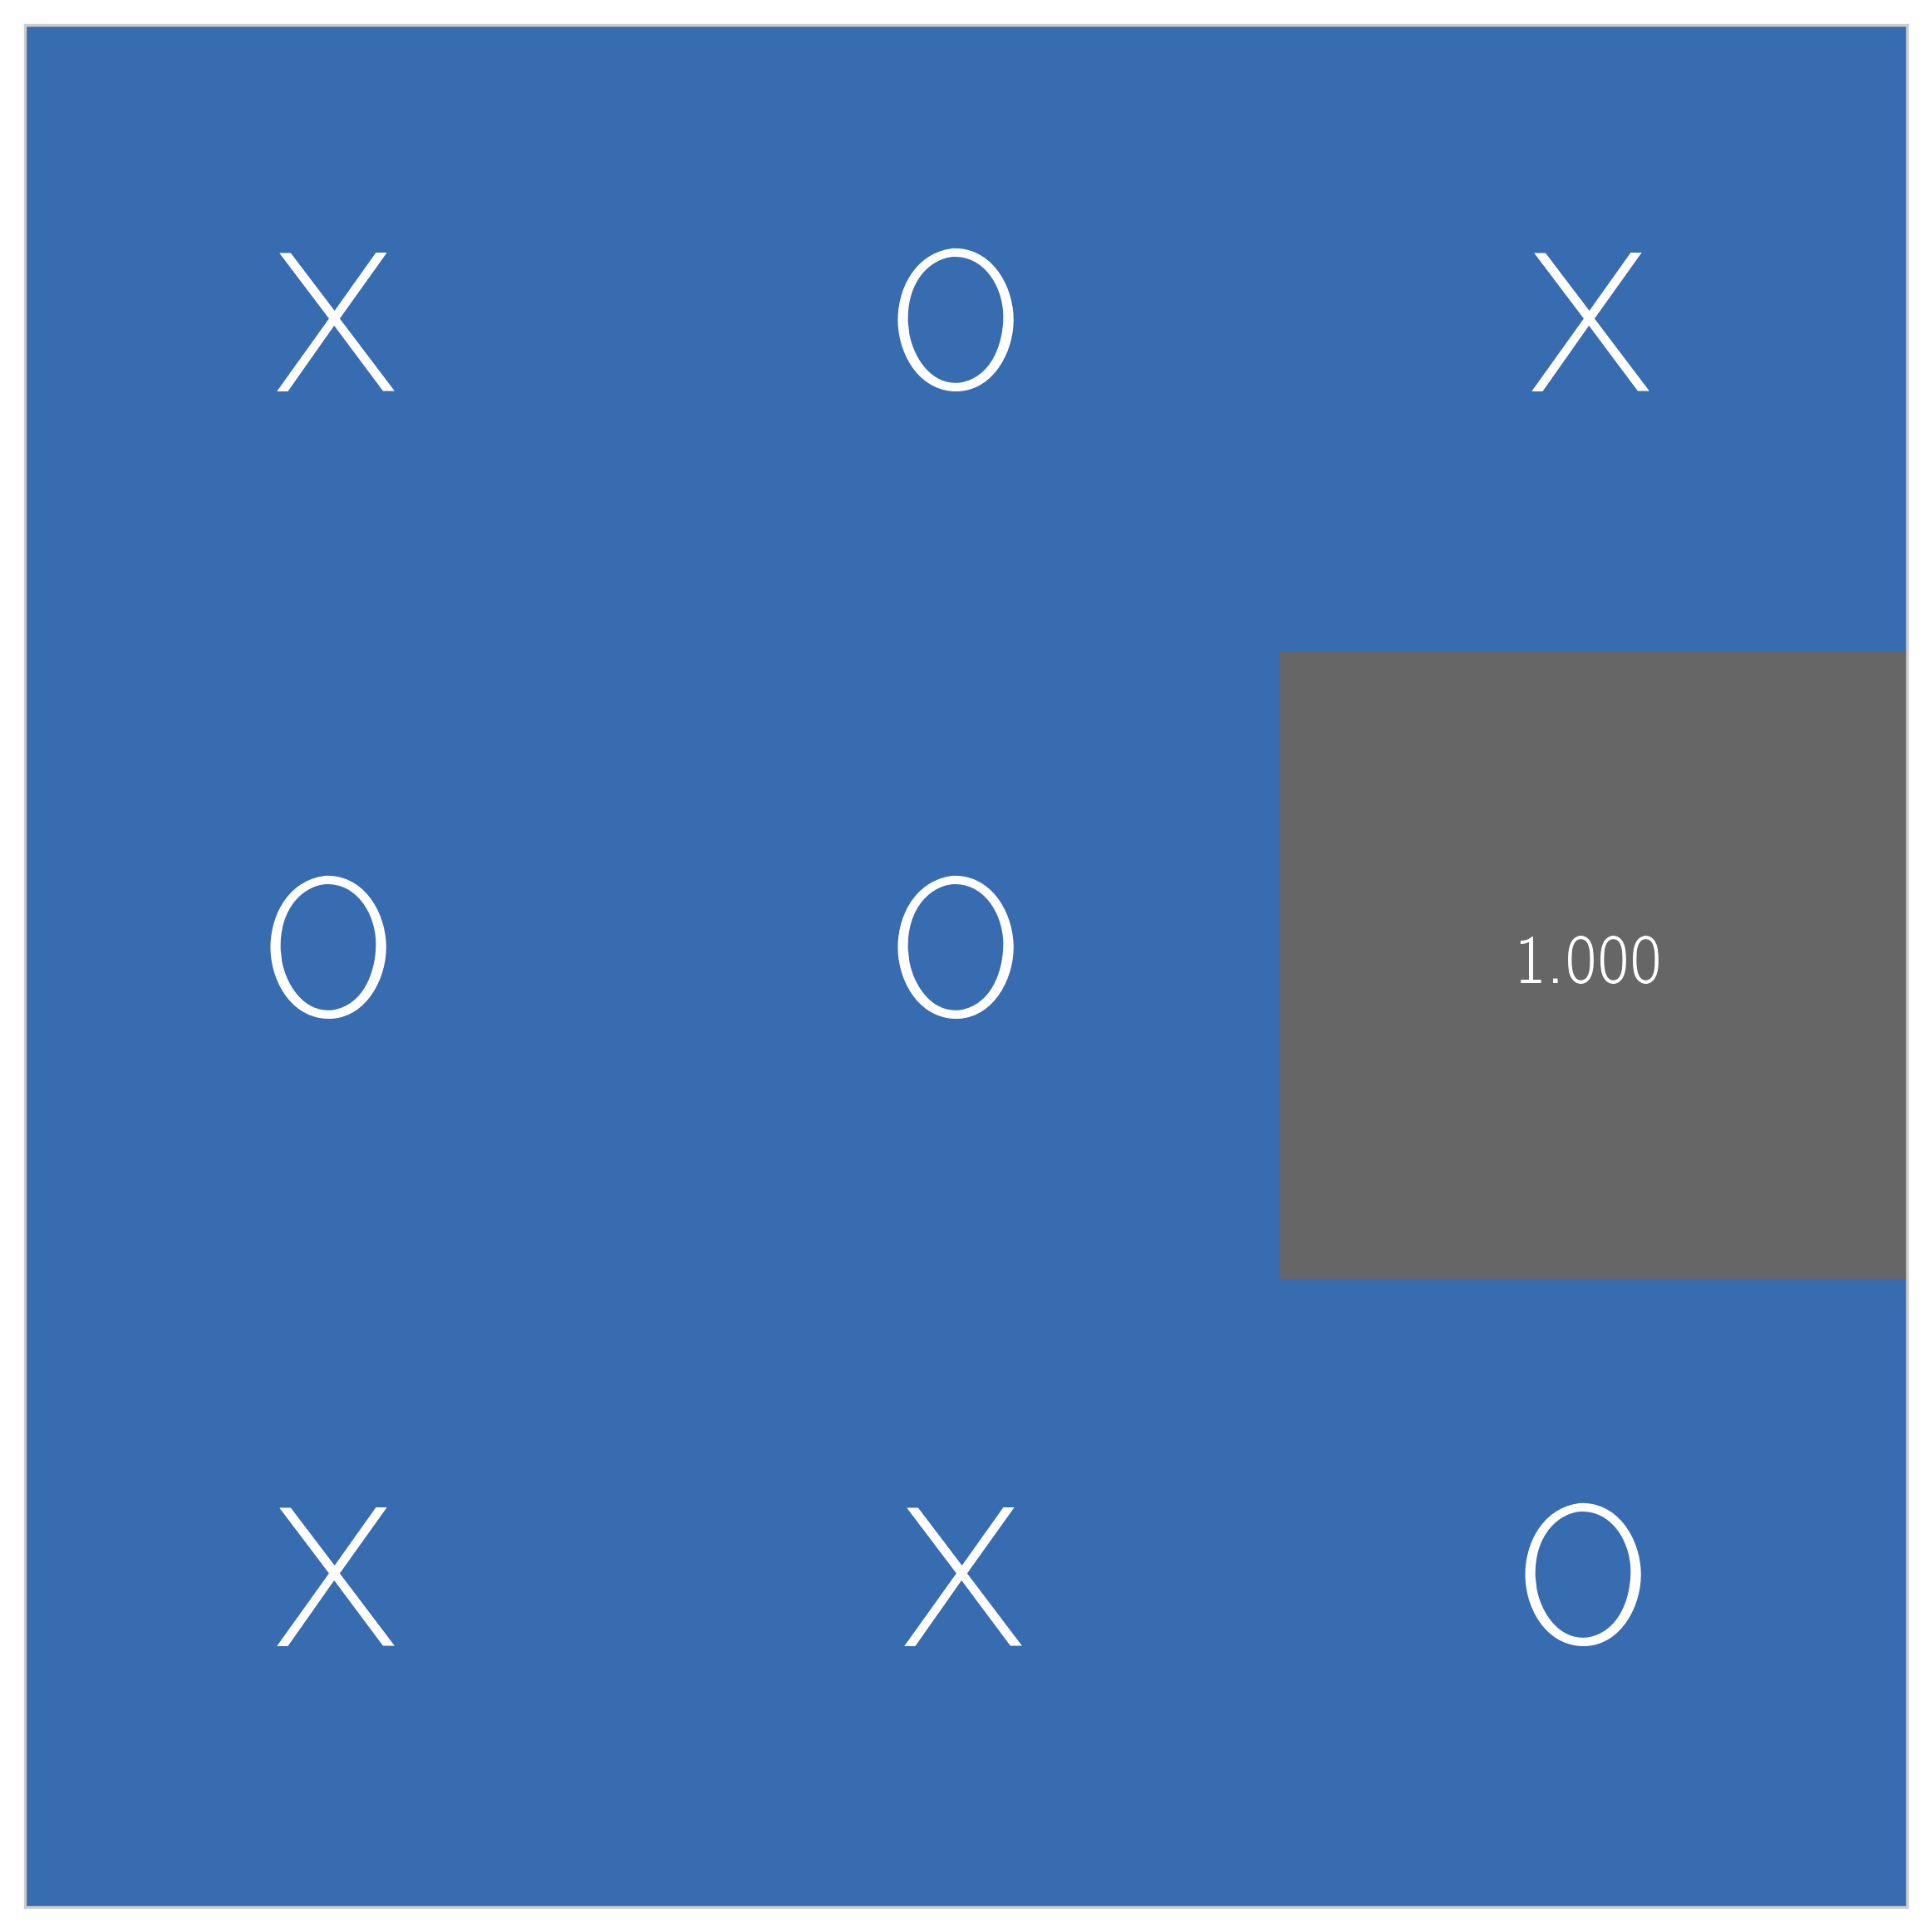

0 [1 2] 0.9999999999999974


In [15]:
plot_test_game(env, pi_crosses, pi_naughts, random_crosses=False, random_naughts=False, verbose=True, fontq=20, fontx=60)

Попробуем пообучать стратегии на доске 4 * 4(играем до 3 в ряд). Здесь будем учить обе стратегии параллельно.

In [23]:
pi_crosses = Strategy(n_rows=4, n_cols=4)
pi_naughts = Strategy(n_rows=4, n_cols=4)

500000  episodes completed


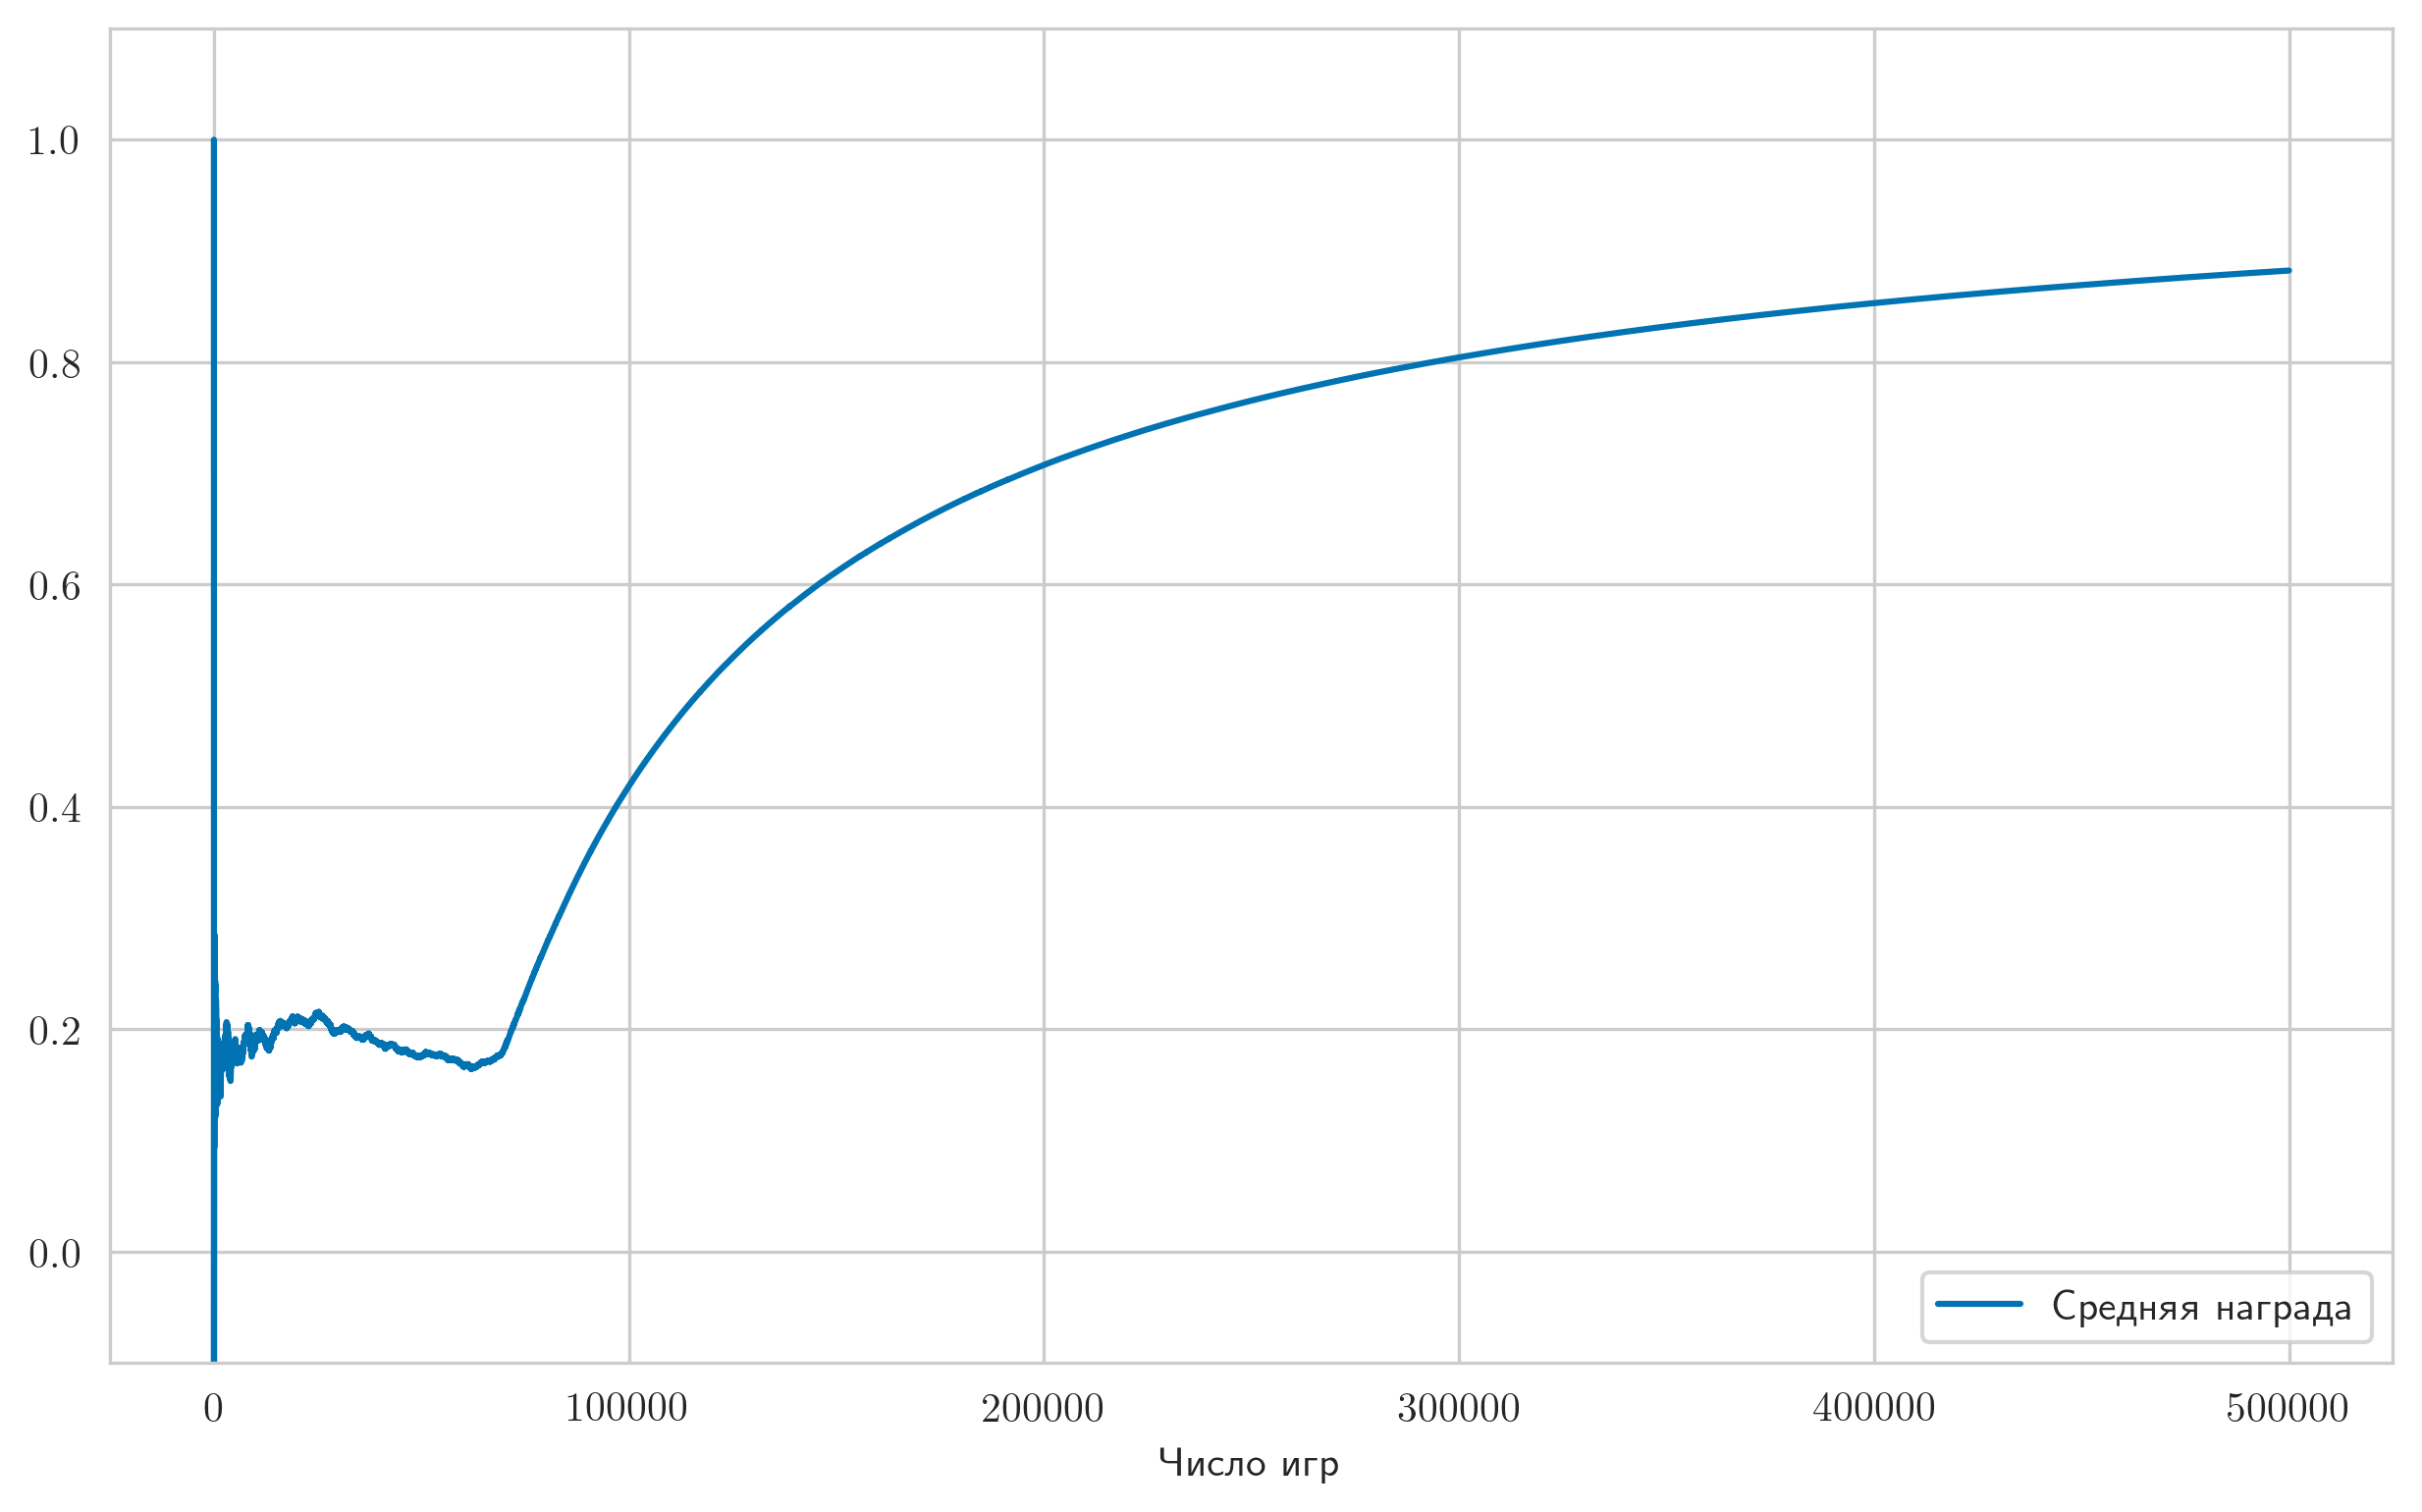

In [24]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)
total_episodes = 500000
gamma = 0.2
alpha = 0.4
eps = 0.5

#pi_crosses = Strategy(n_rows=4, n_cols=4)
#pi_naughts = Strategy(n_rows=4, n_cols=4)

avg_results = [0]
for n in range(total_episodes + 1):
    if n > 0 and n % 50000 == 0:
        clear_output(True)
        print(n, " episodes completed")
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        line = ax.plot(np.arange(n), avg_results[1:], label="Средняя награда", color="C0")
        ax.legend(loc="lower right")
        ax.set_ylim((-0.1, 1.1))
        ax.set_xlabel('Число игр')
        plt.show()
    Q_learning_episode_crosses(env, pi_crosses, pi_naughts, alpha=alpha, epsilon=eps, gamma=gamma)
    Q_learning_episode_naughts(env, pi_crosses, pi_naughts, alpha=alpha, epsilon=eps, gamma=gamma)
    reward = reward_by_strategy_matrix_crosses(env, pi_crosses, pi_naughts)
    
    avg_results.append((avg_results[-1] * n + reward) / (n + 1))

env.close()

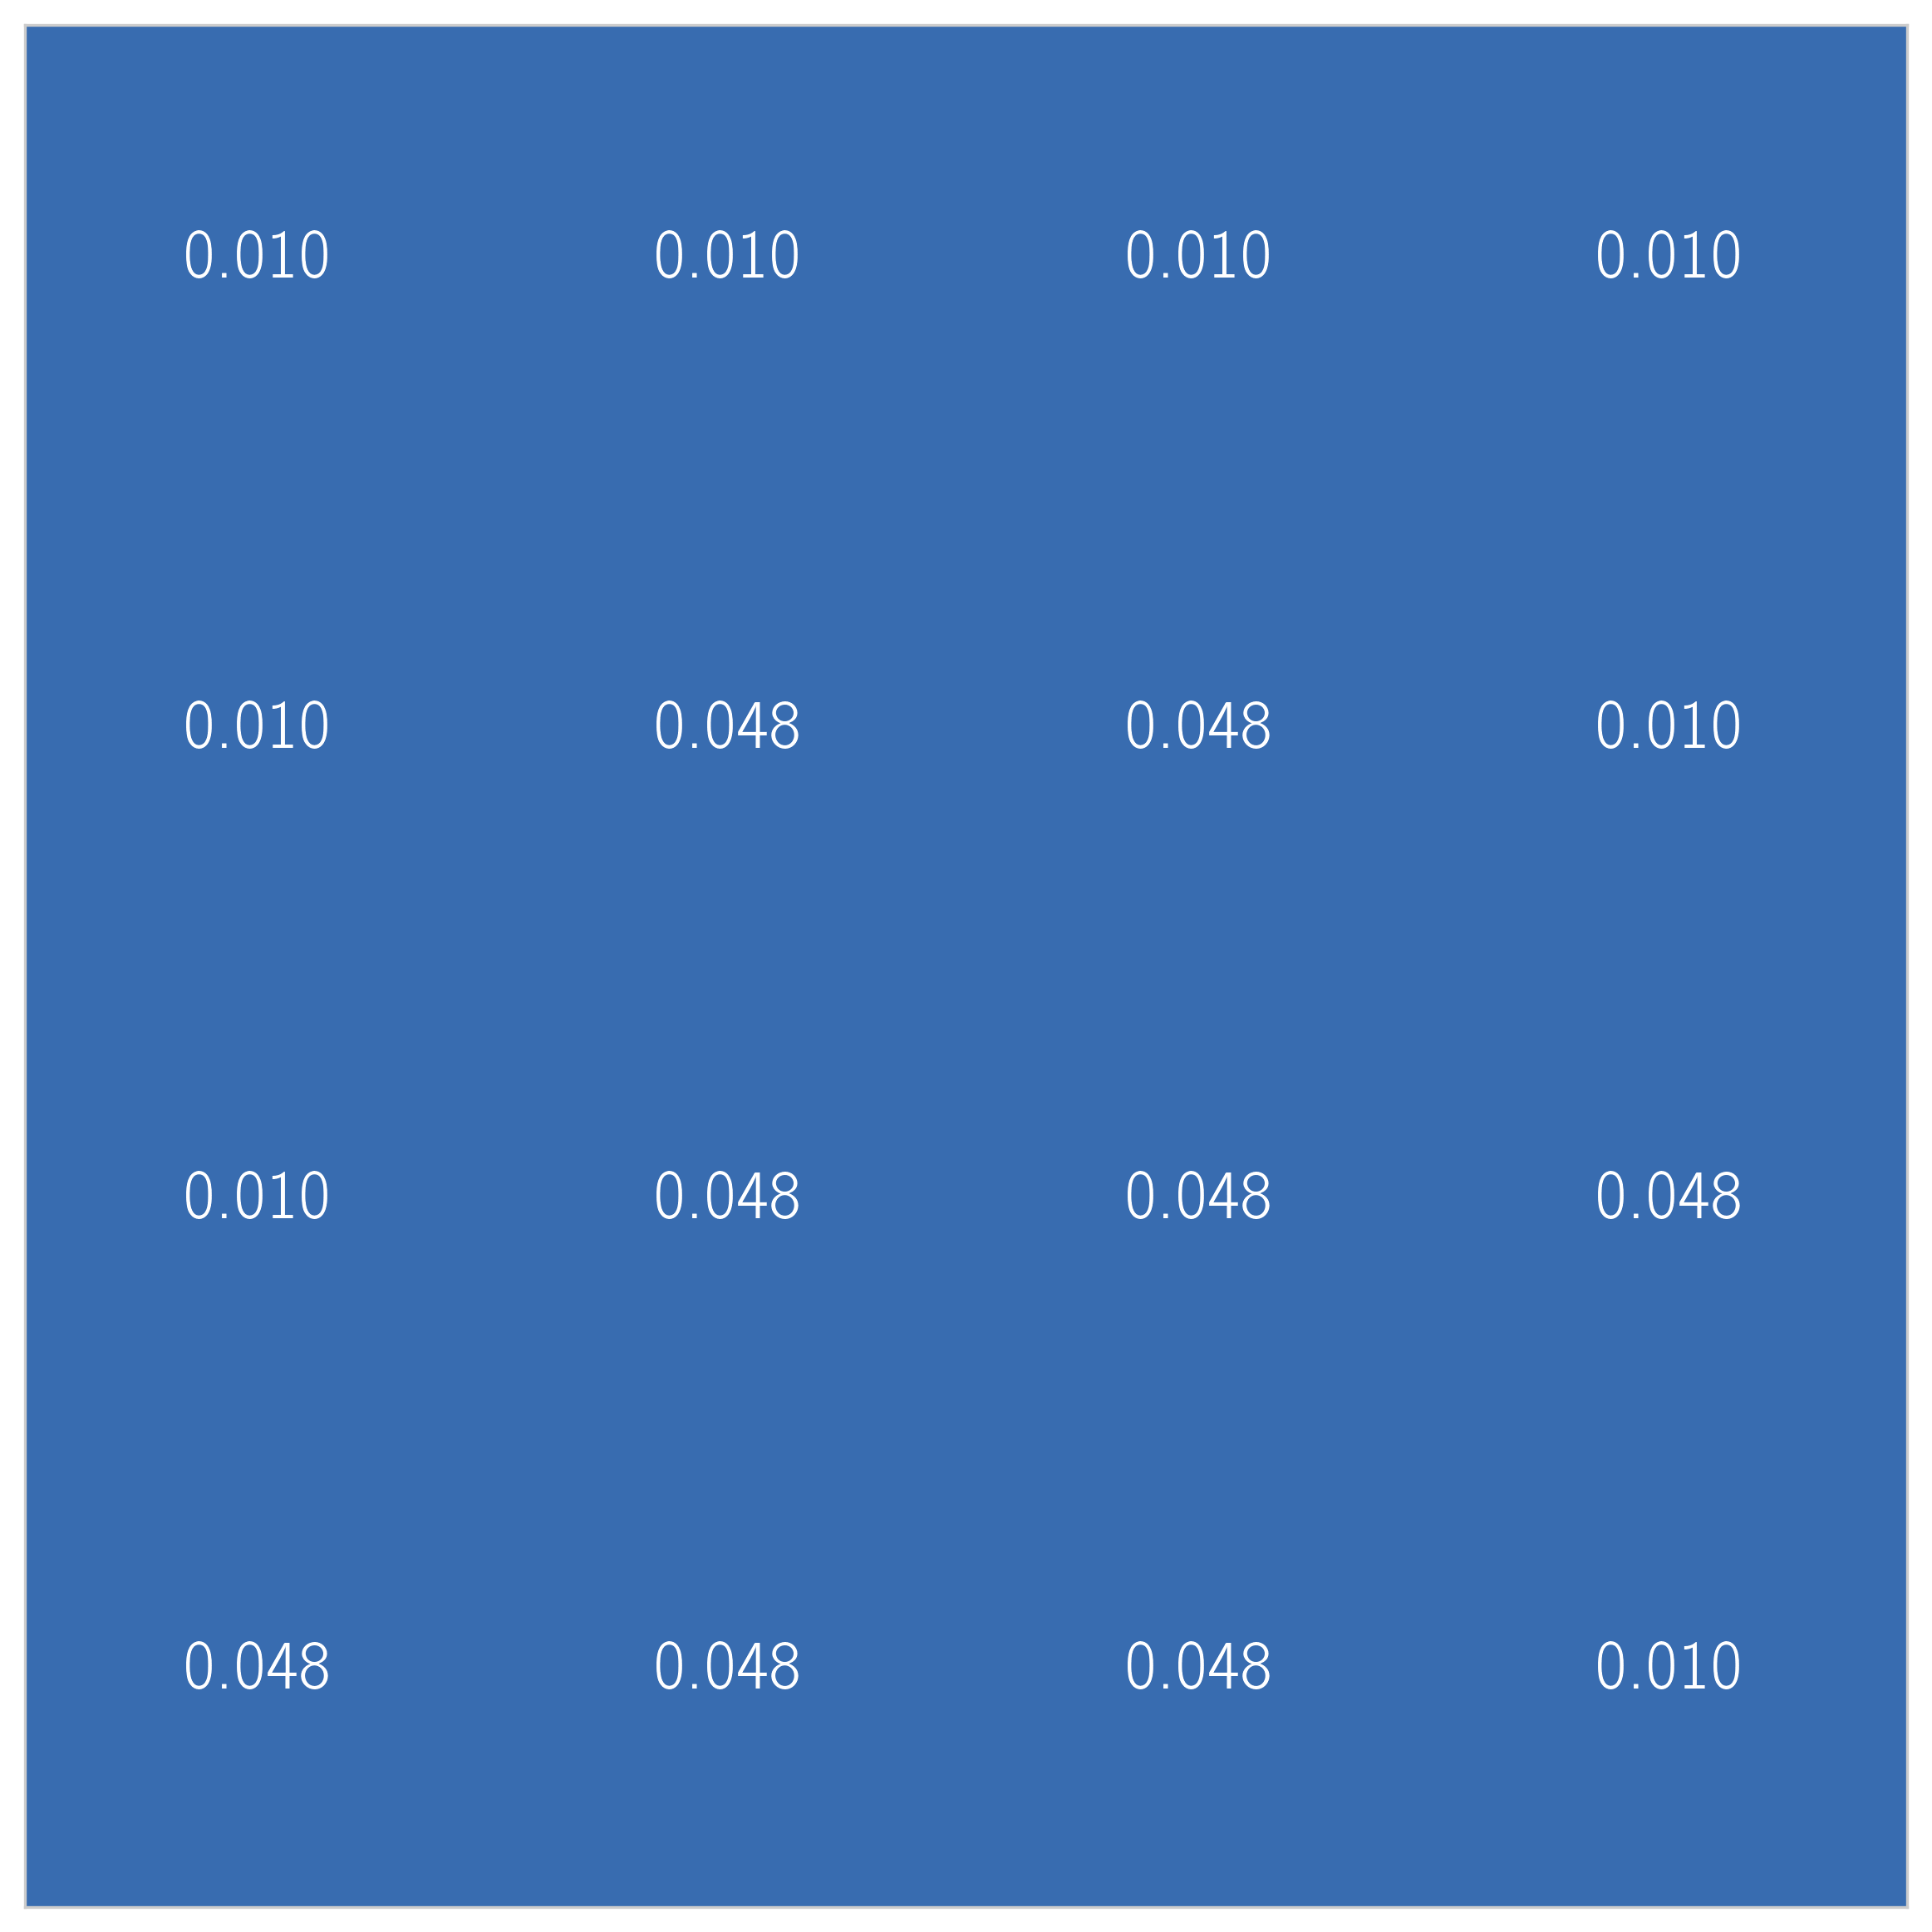

0 [0 0] 0.009600000000000001
1 [0 1] 0.009599999999999996
2 [0 2] 0.009599999999999996
3 [0 3] 0.009600000000000004
4 [1 0] 0.009600000000000004
5 [1 1] 0.047999999999991244
6 [1 2] 0.04799999999924107
7 [1 3] 0.009599999999999996
8 [2 0] 0.009600000000000001
9 [2 1] 0.04799995220413007
10 [2 2] 0.04799999999999998
11 [2 3] 0.04799999999999998
12 [3 0] 0.04799999999999998
13 [3 1] 0.04799999999999998
14 [3 2] 0.04799999999999998
15 [3 3] 0.009599999999999996


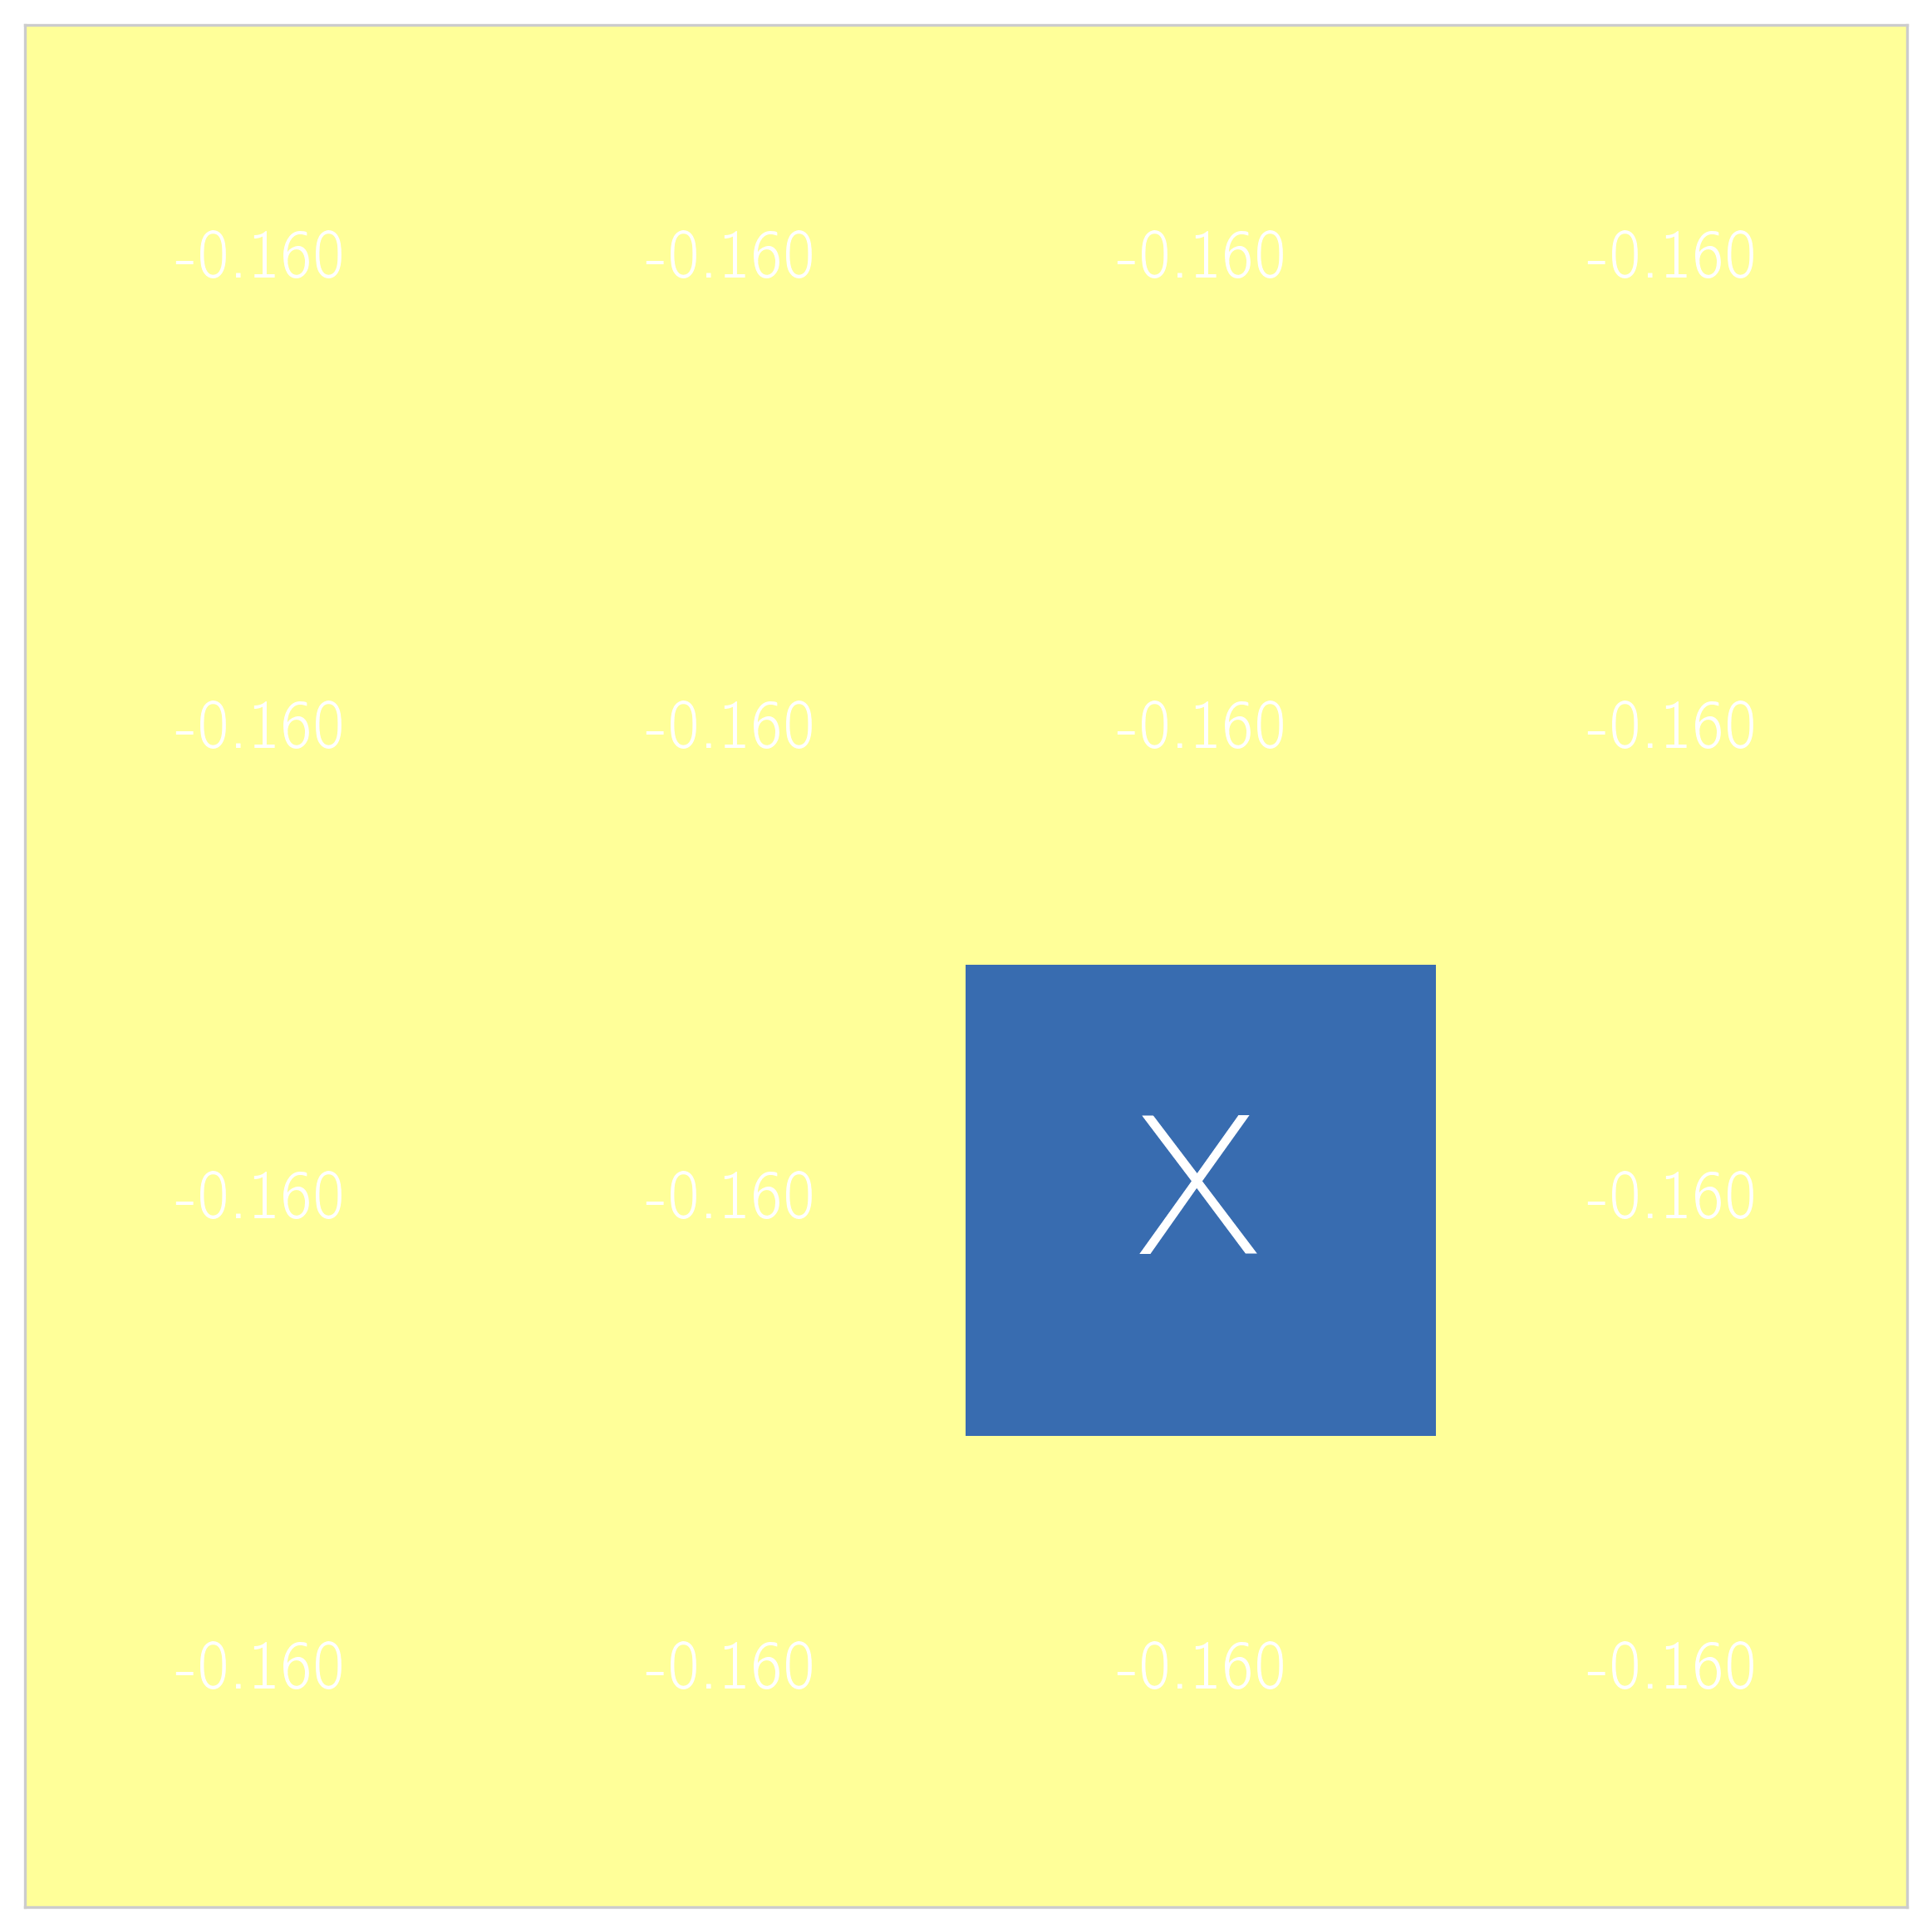

0 [0 0] -0.15999999999999998
1 [0 1] -0.15999999999999998
2 [0 2] -0.15999999999999998
3 [0 3] -0.15999999999999998
4 [1 0] -0.15999999999999998
5 [1 1] -0.15999999999999998
6 [1 2] -0.15999999999999998
7 [1 3] -0.15999999999999998
8 [2 0] -0.15999999999999998
9 [2 1] -0.15999999999999998
10 [2 3] -0.15999999999999998
11 [3 0] -0.15999999999999998
12 [3 1] -0.15999999999999998
13 [3 2] -0.15999999999999998
14 [3 3] -0.15999999999999998


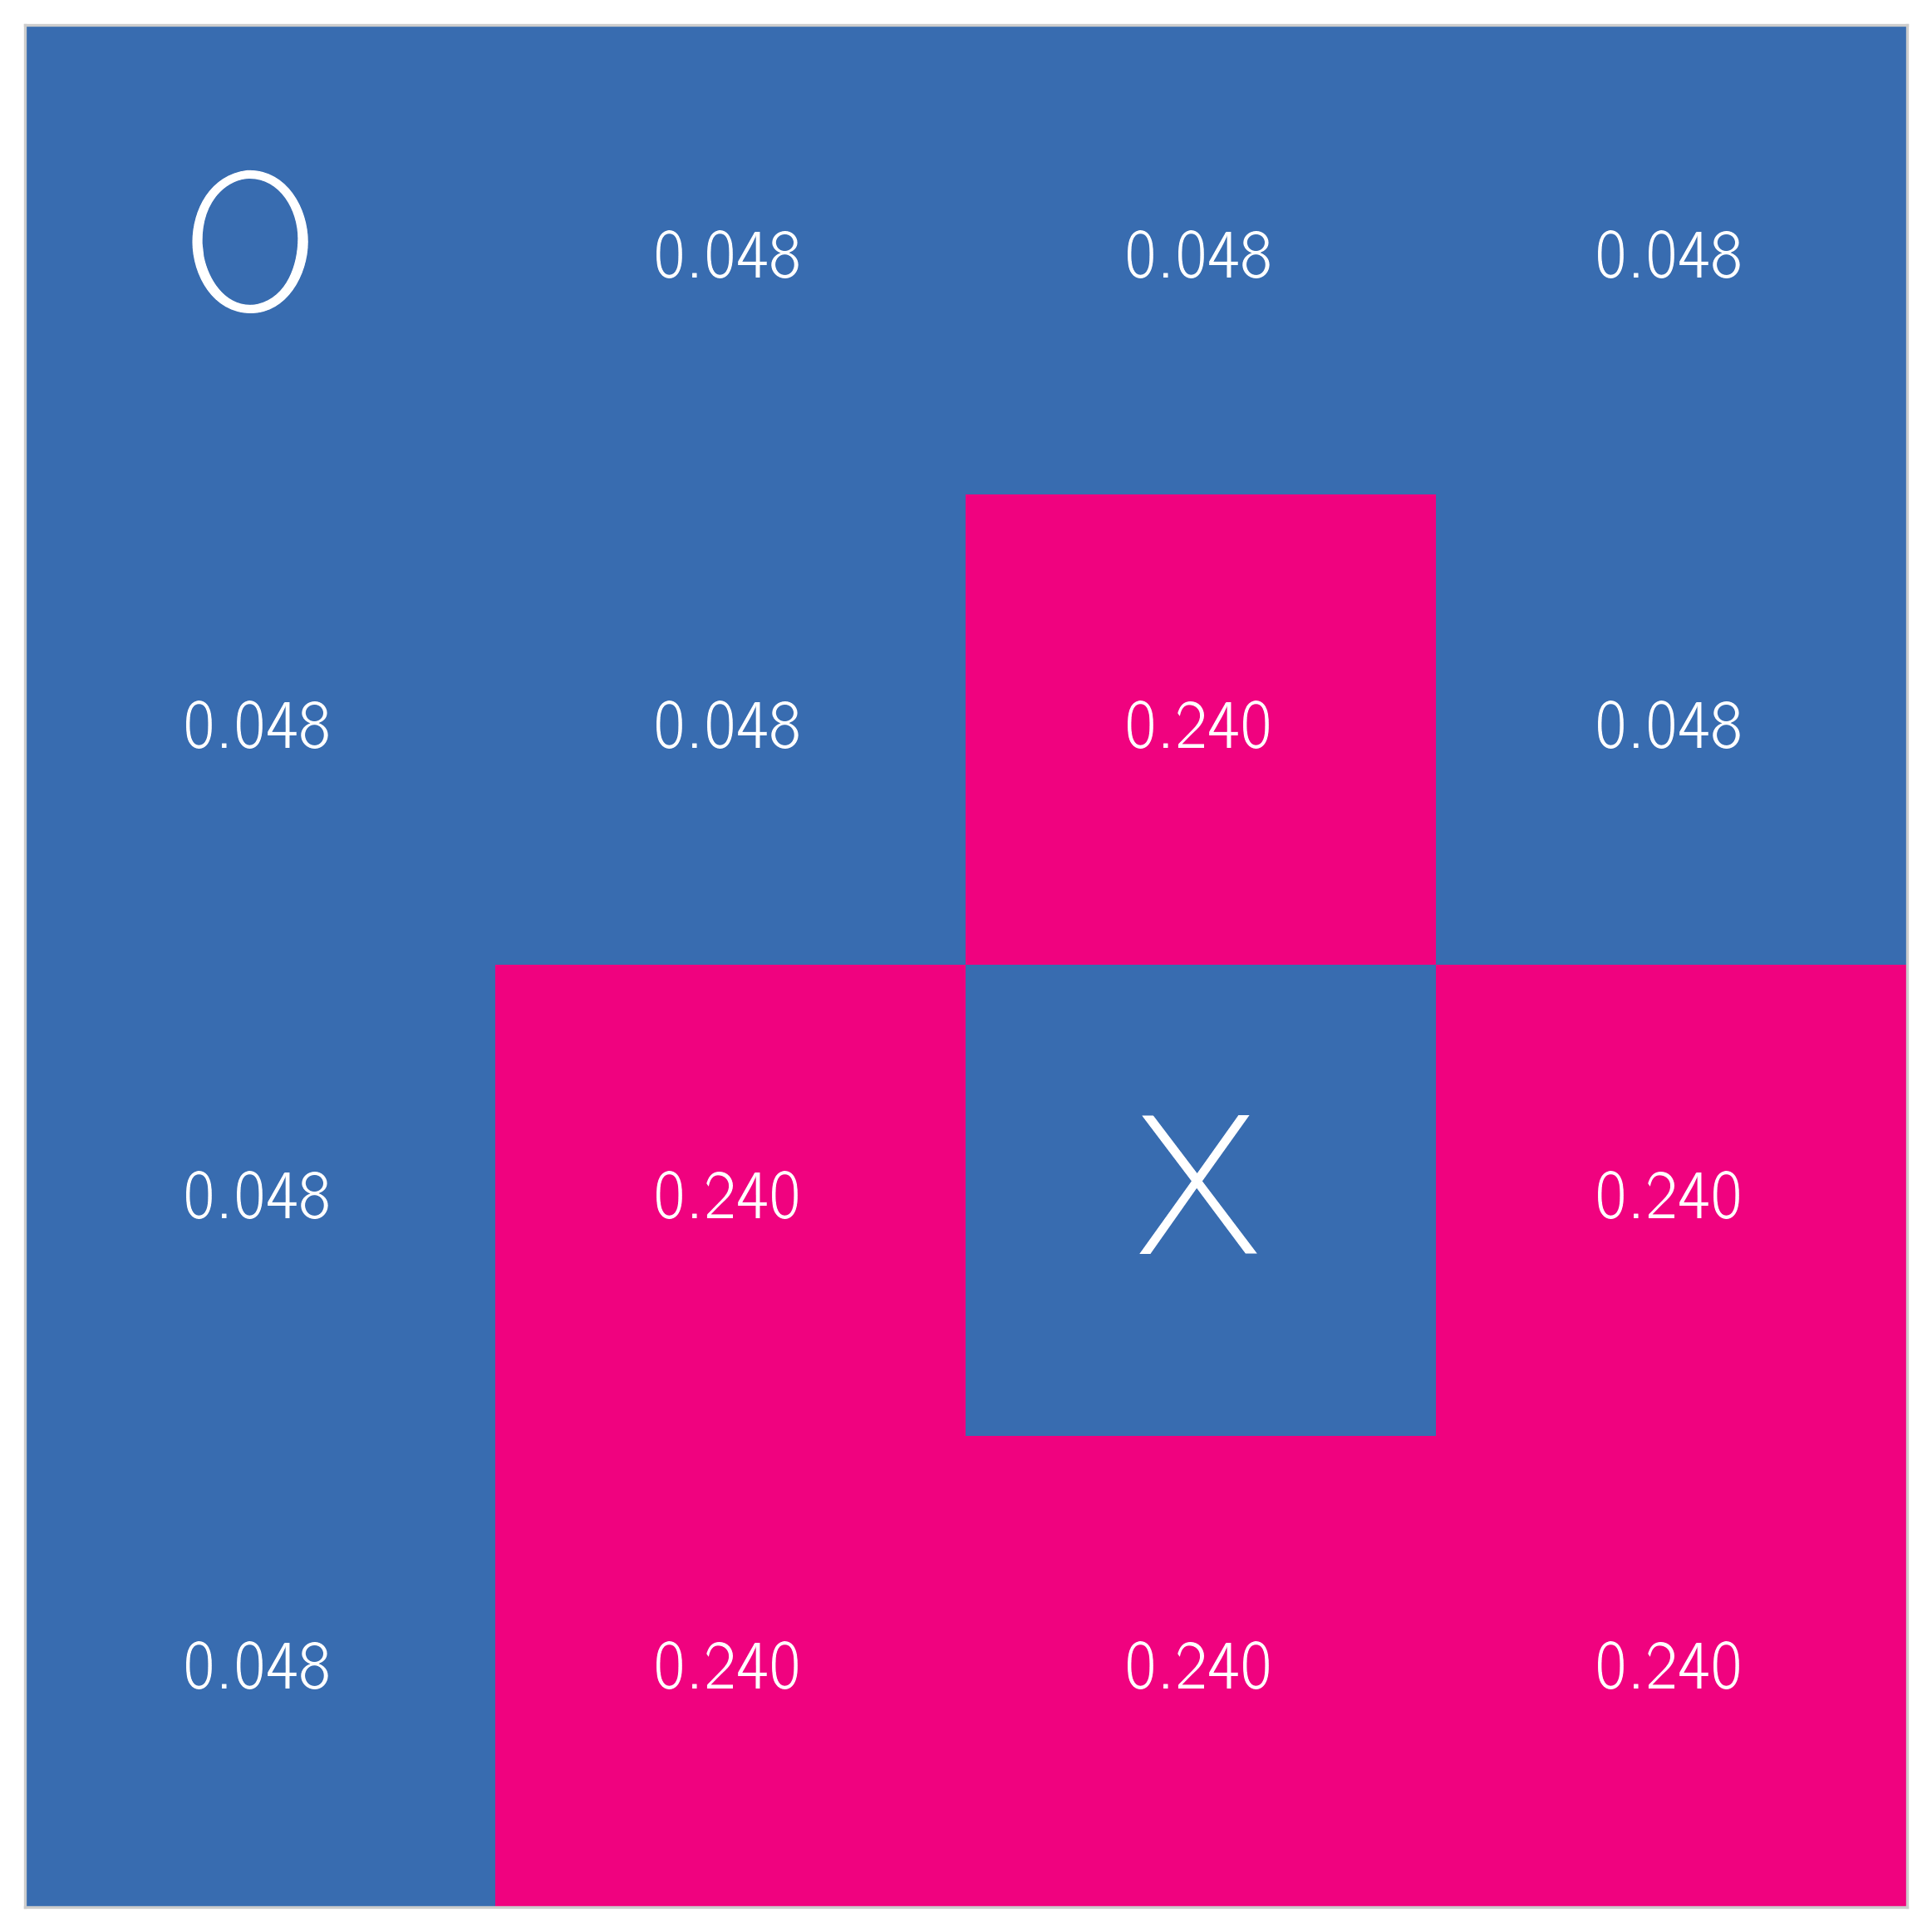

0 [0 1] 0.04799999999999998
1 [0 2] 0.04799999999999998
2 [0 3] 0.04799999999999998
3 [1 0] 0.04799999999999998
4 [1 1] 0.04799999999999998
5 [1 2] 0.23999999999999994
6 [1 3] 0.04799999999999998
7 [2 0] 0.04799999999999998
8 [2 1] 0.23999999999999994
9 [2 3] 0.23999999999999994
10 [3 0] 0.04799999999999998
11 [3 1] 0.23999999999999994
12 [3 2] 0.23999999999999994
13 [3 3] 0.23999999999999994


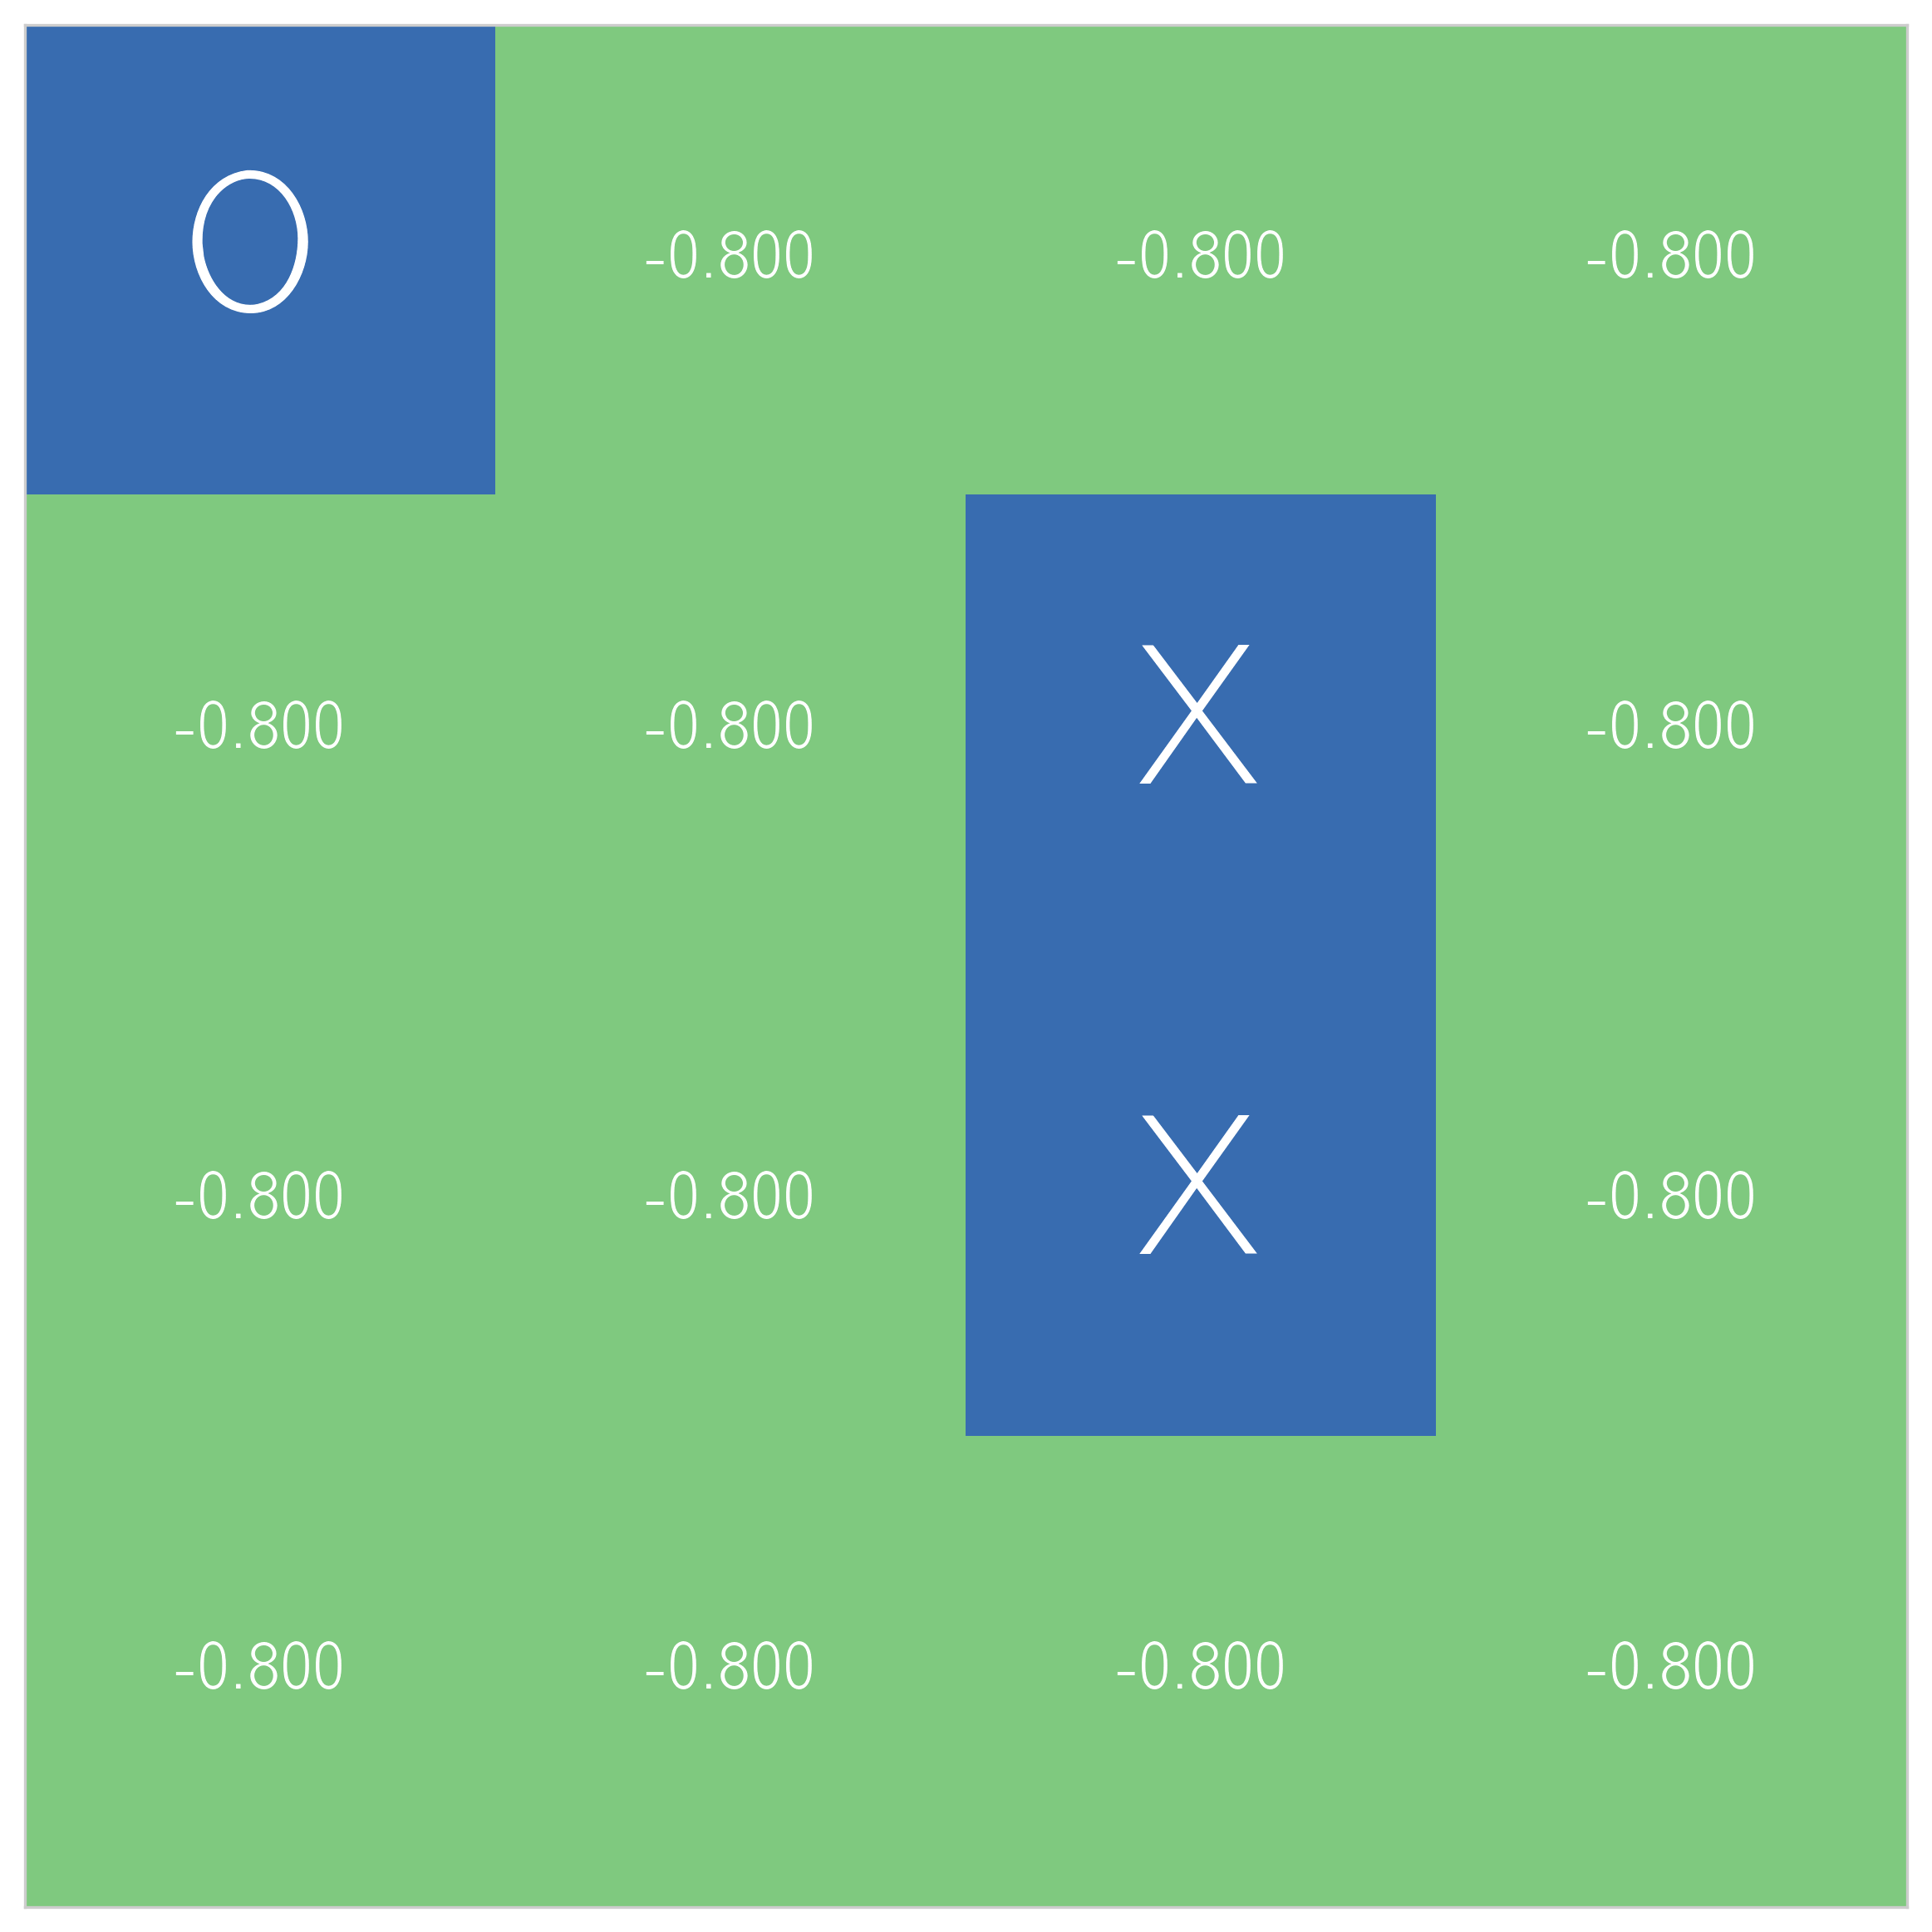

0 [0 1] -0.7999999999999999
1 [0 2] -0.7999999999999999
2 [0 3] -0.7999999999999999
3 [1 0] -0.7999999999999999
4 [1 1] -0.7999999999999999
5 [1 3] -0.7999999999999999
6 [2 0] -0.7999999999999999
7 [2 1] -0.7999999999999999
8 [2 3] -0.7999999999999999
9 [3 0] -0.7999999999999999
10 [3 1] -0.7999999999999999
11 [3 2] -0.7999999999999999
12 [3 3] -0.7999999999999999


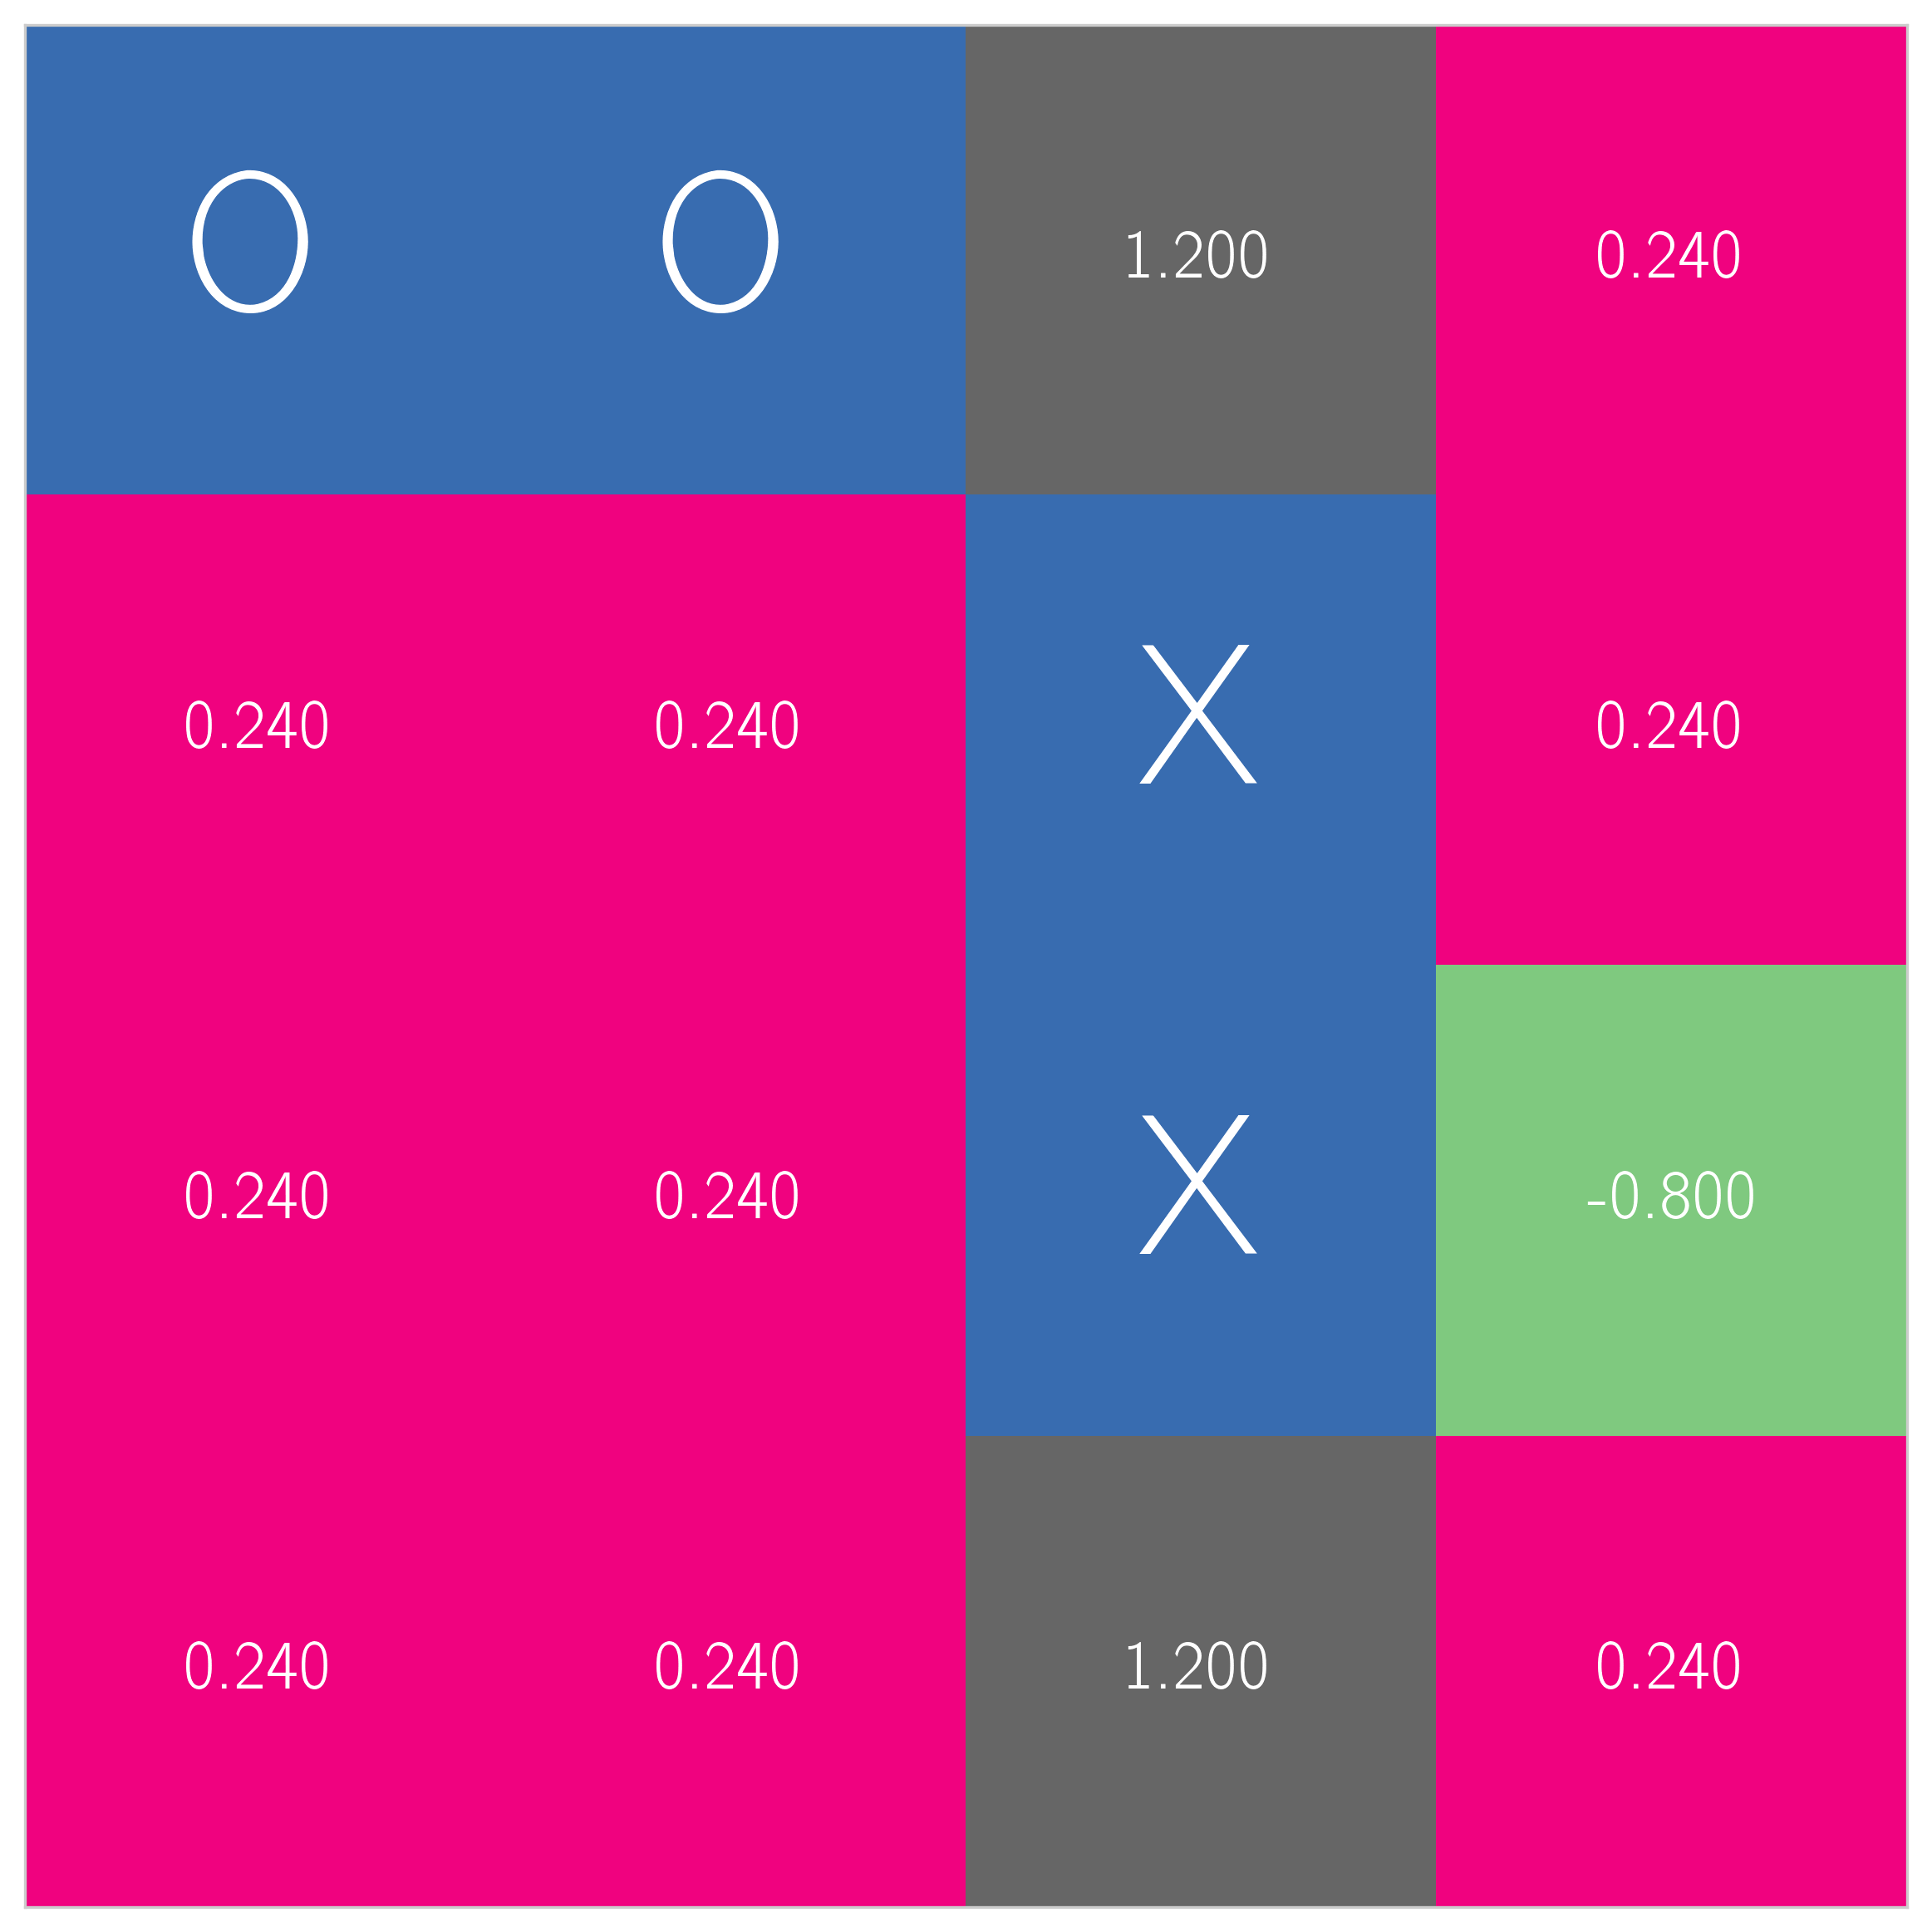

0 [0 2] 1.1999999999999997
1 [0 3] 0.23999999999999994
2 [1 0] 0.23999999999999994
3 [1 1] 0.23999999999999994
4 [1 3] 0.23999999999999994
5 [2 0] 0.23999999999999994
6 [2 1] 0.23999999999999994
7 [2 3] -0.7999999999999999
8 [3 0] 0.23999999999999994
9 [3 1] 0.23999999999999994
10 [3 2] 1.1999999999999997
11 [3 3] 0.23999999999999994
Крестики выиграли!


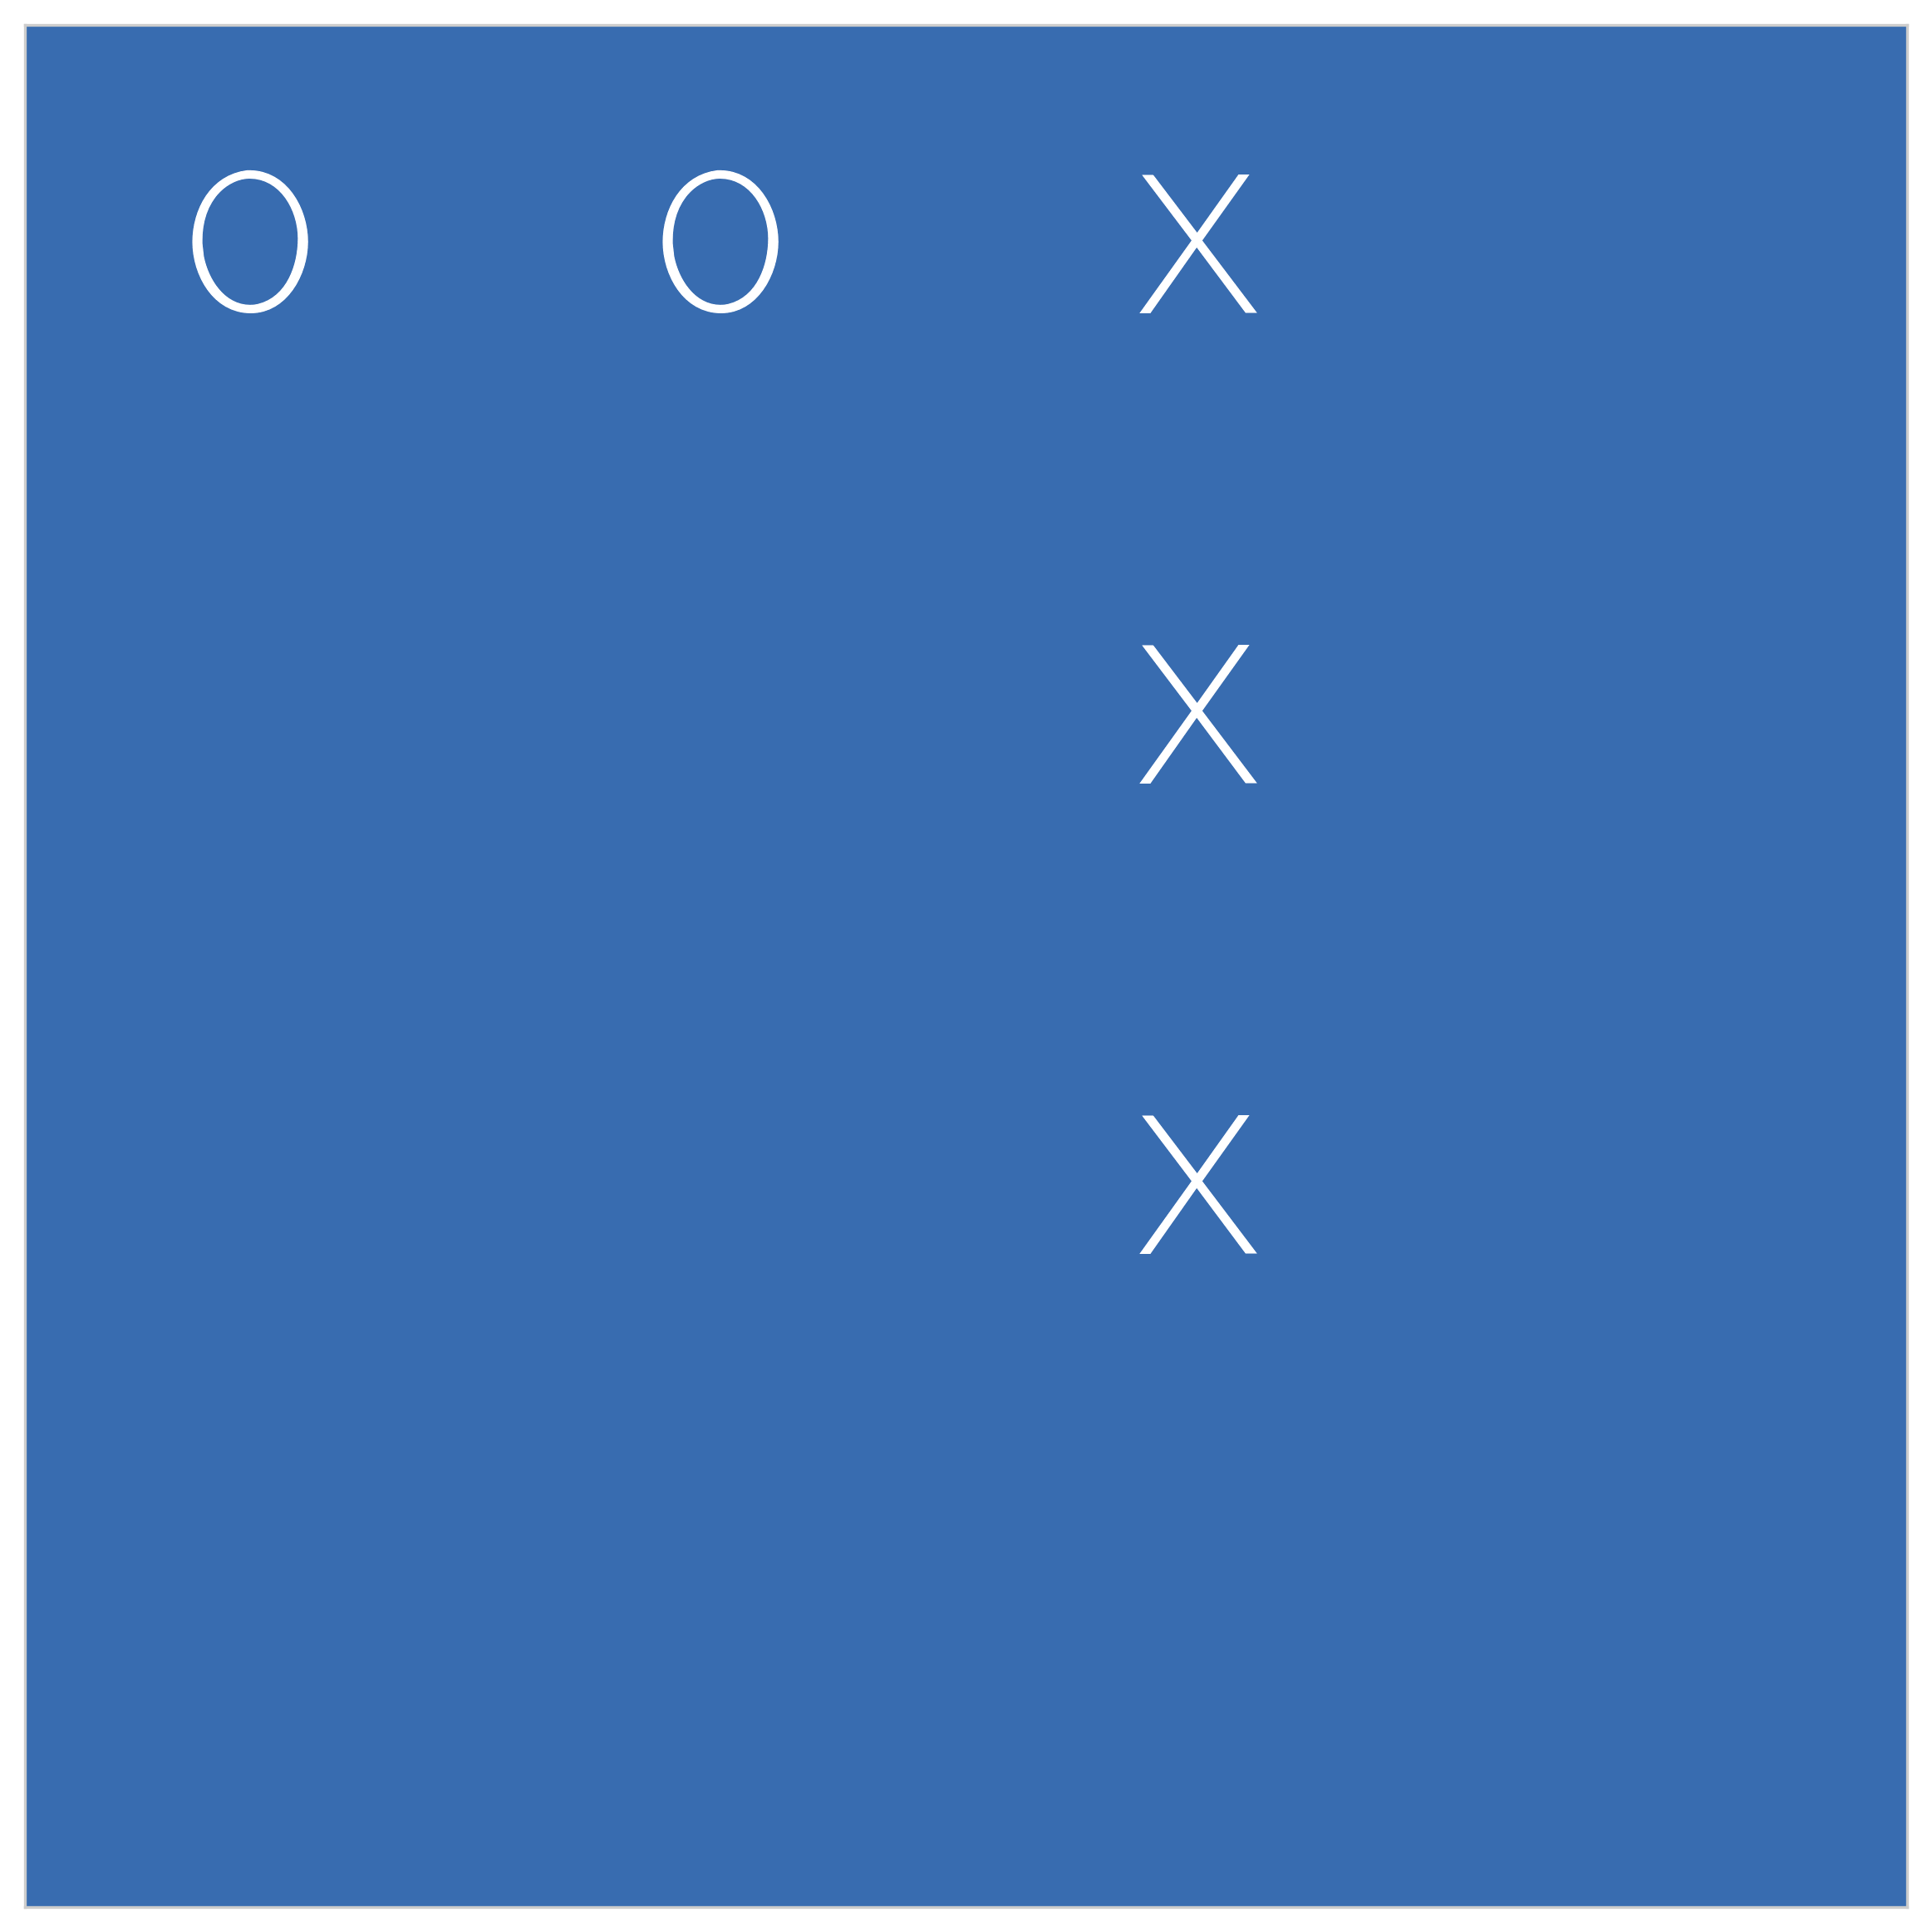

In [25]:
plot_test_game(env, pi_crosses, pi_naughts, random_crosses=False, random_naughts=False, verbose=True, fontq=20, fontx=60)

Видим, что крестики поняли как выиграть за три хода независимо от ходов соперника.

Продолжим обучать эти же стратегии, но теперь выигрывает тот, кто составит ряд из 4 своих символов 

500000  episodes completed


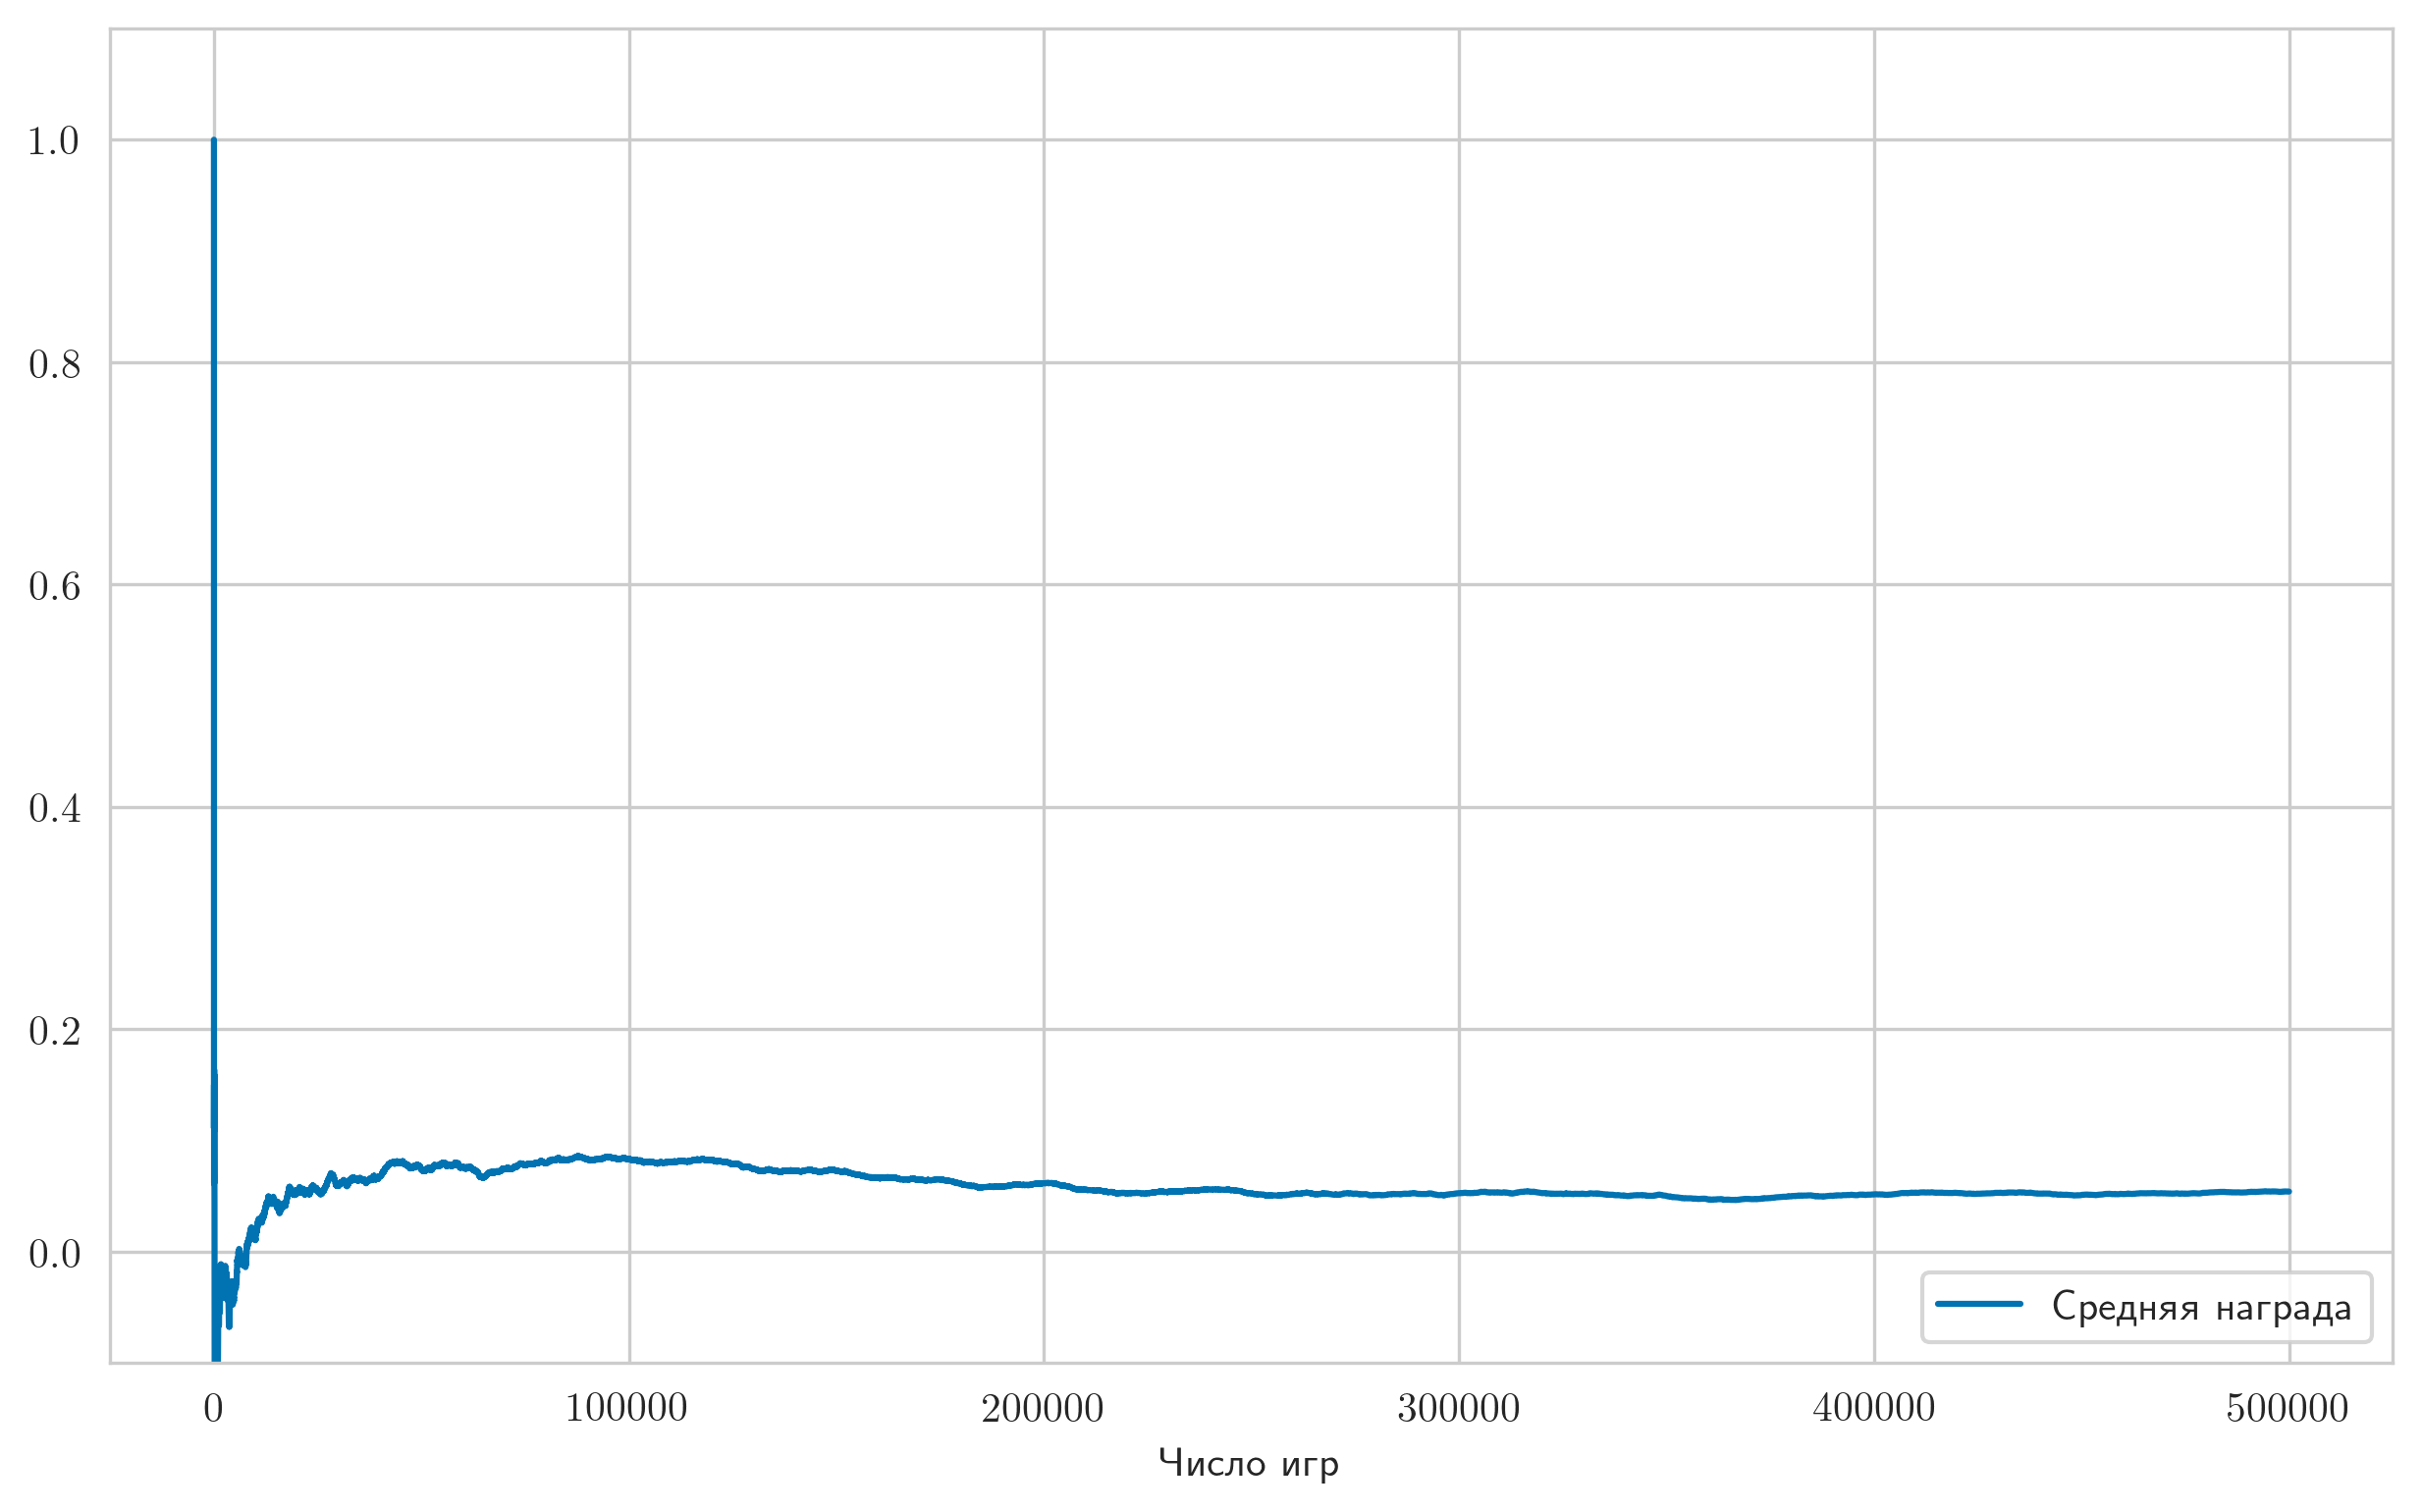

In [27]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
total_episodes = 1000000
gamma = 0.2
alpha = 0.4
eps = 0.5

avg_results = [0]
for n in range(total_episodes + 1):
    if n > 0 and n % 50000 == 0:
        clear_output(True)
        print(n, " episodes completed")
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        line = ax.plot(np.arange(n), avg_results[1:], label="Средняя награда", color="C0")
        ax.legend(loc="lower right")
        ax.set_ylim((-0.1, 1.1))
        ax.set_xlabel('Число игр')
        plt.show()
    Q_learning_episode_crosses(env, pi_crosses, pi_naughts, alpha=alpha, epsilon=eps, gamma=gamma)
    Q_learning_episode_naughts(env, pi_crosses, pi_naughts, alpha=alpha, epsilon=eps, gamma=gamma)
    reward = reward_by_strategy_matrix_crosses(env, pi_crosses, pi_naughts)
    
    avg_results.append((avg_results[-1] * n + reward) / (n + 1))

env.close()

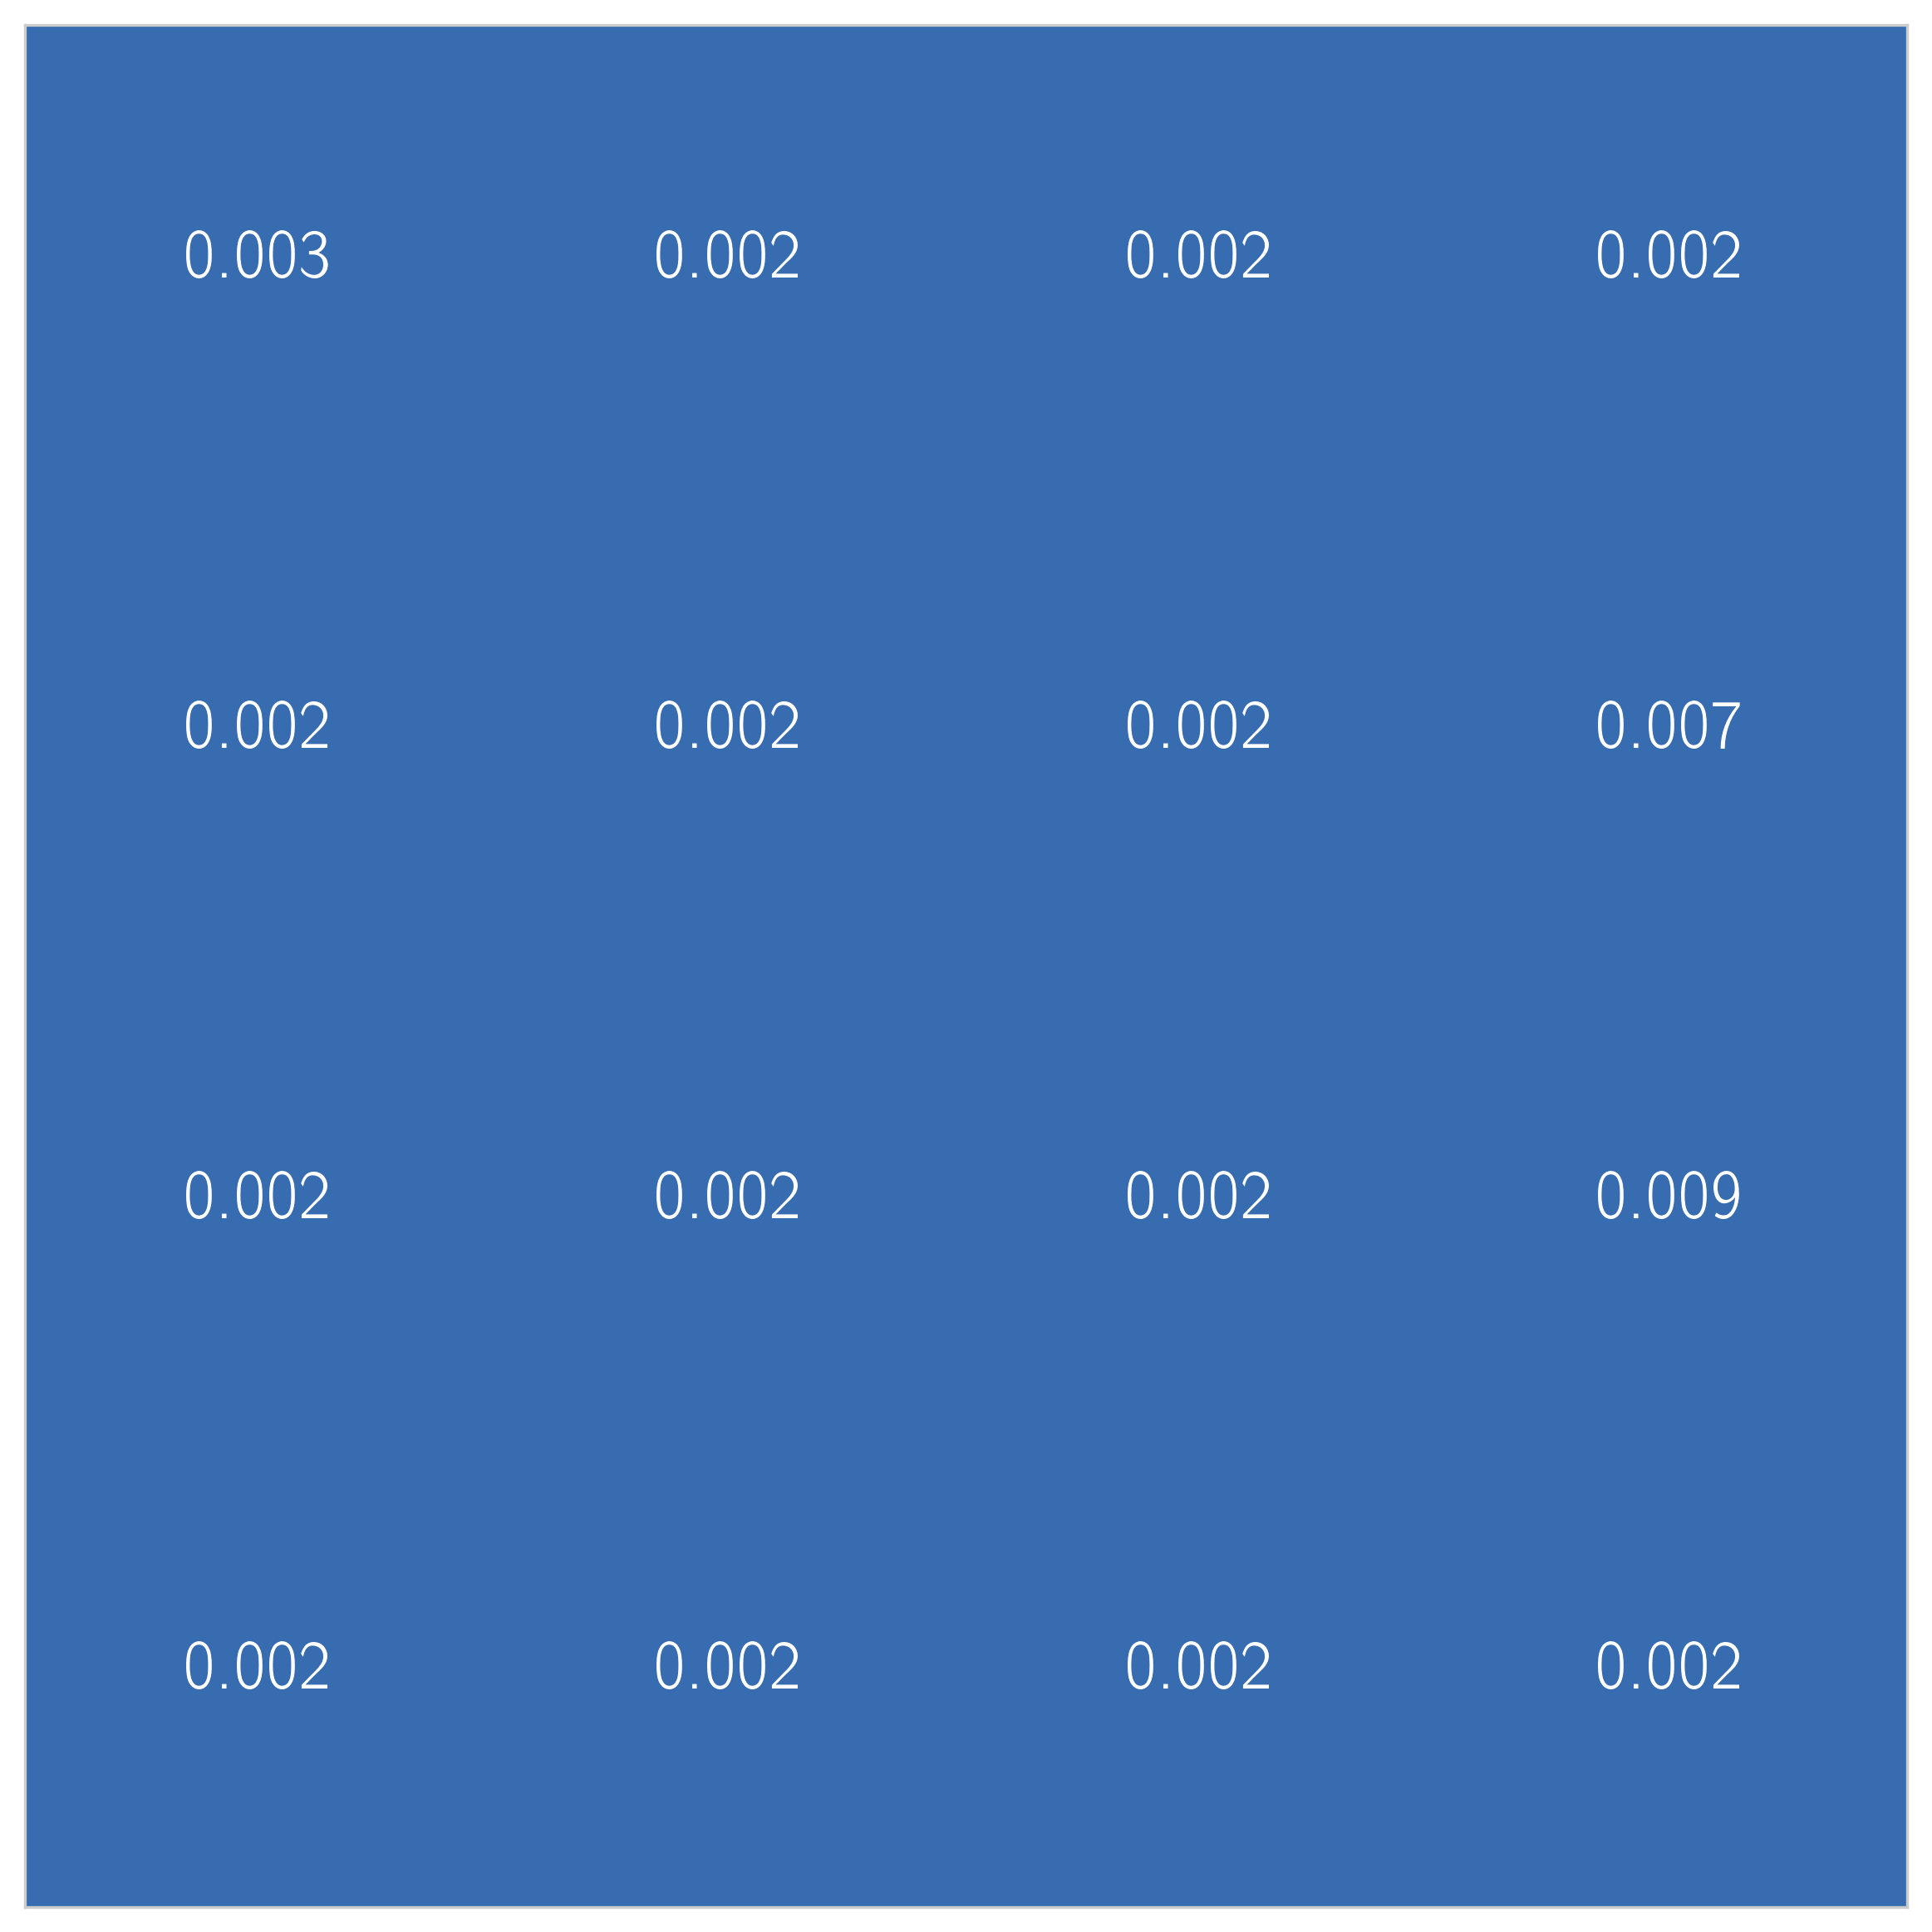

0 [0 0] 0.0031897746705745692
1 [0 1] 0.0019199999999999994
2 [0 2] 0.00192
3 [0 3] 0.0019200000000000005
4 [1 0] 0.00192
5 [1 1] 0.0019200000000000005
6 [1 2] 0.002153464022966165
7 [1 3] 0.006726173096345373
8 [2 0] 0.00192000000000487
9 [2 1] 0.0019199999999999994
10 [2 2] 0.0019200000000000005
11 [2 3] 0.00873784993167108
12 [3 0] 0.001928211772123907
13 [3 1] 0.00192
14 [3 2] 0.00192
15 [3 3] 0.0019200000000000011


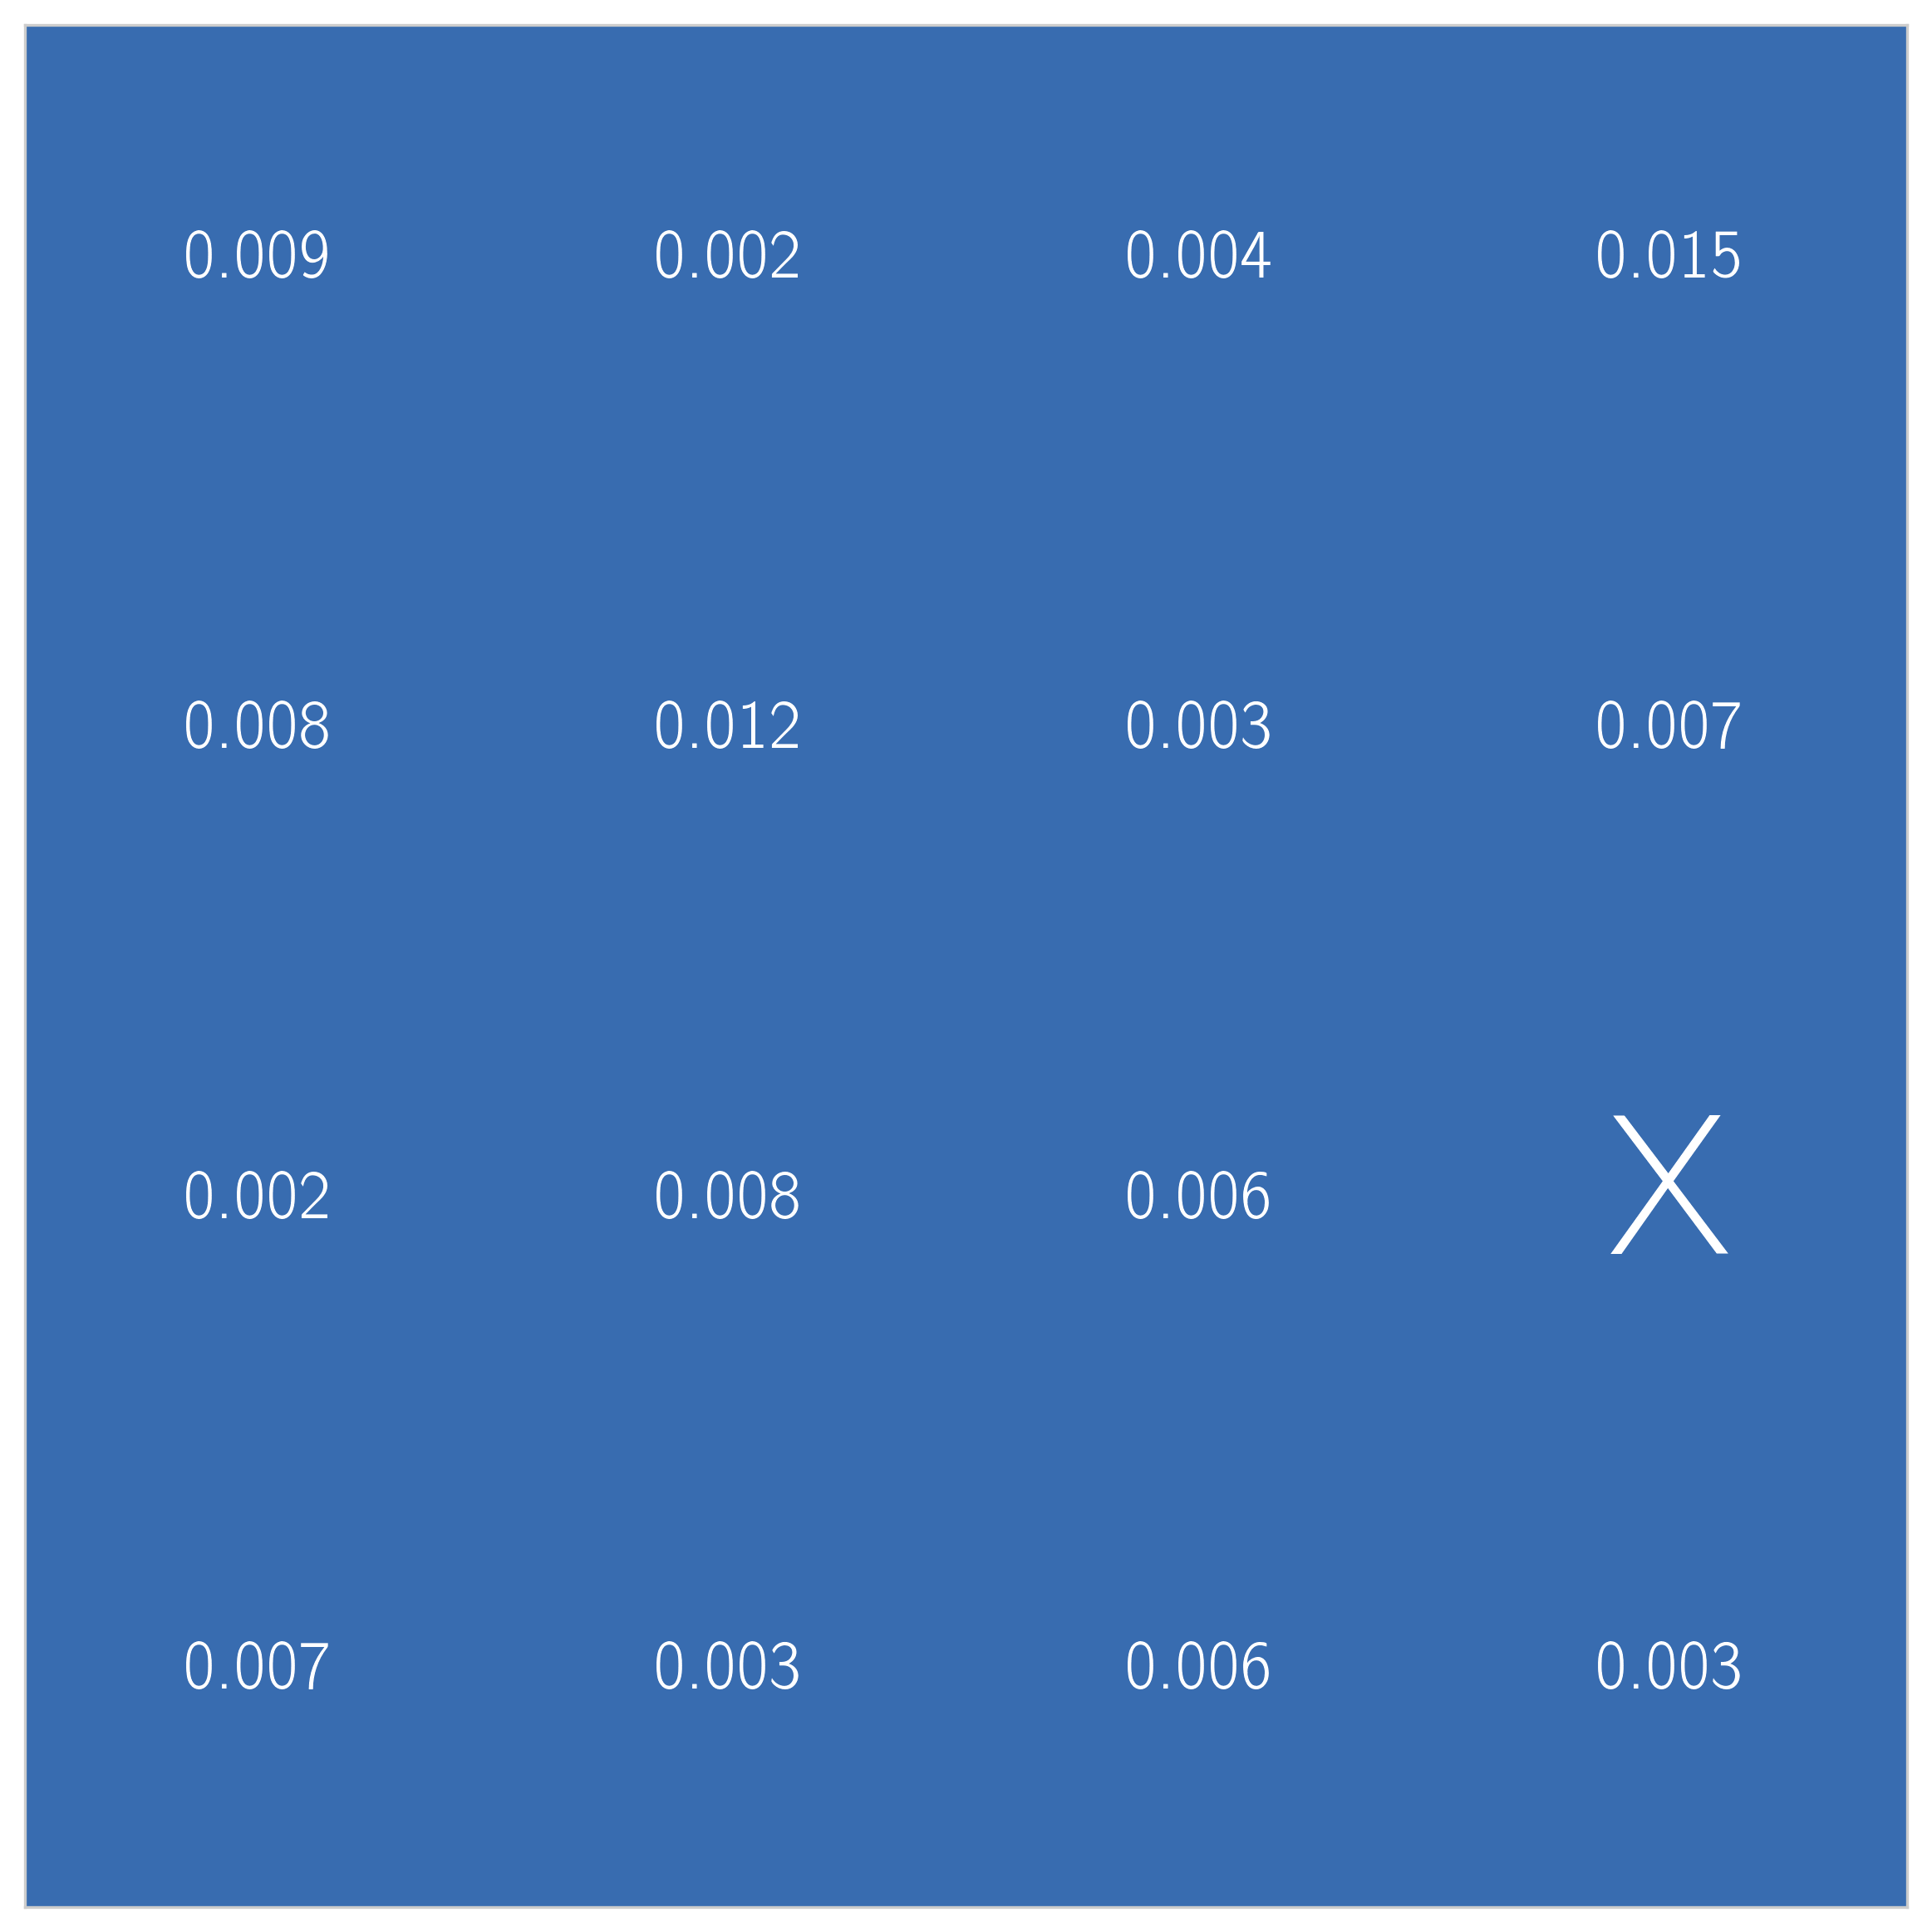

0 [0 0] 0.009432839841360702
1 [0 1] 0.0020055044621759494
2 [0 2] 0.004123168042708251
3 [0 3] 0.014943884398183623
4 [1 0] 0.008441153457843405
5 [1 1] 0.012267818009792014
6 [1 2] 0.003010117436078726
7 [1 3] 0.0074584453914028894
8 [2 0] 0.0019360003748182858
9 [2 1] 0.007567934109955329
10 [2 2] 0.006054071603781783
11 [3 0] 0.007122687354217329
12 [3 1] 0.0031323830787370693
13 [3 2] 0.0058709598587456365
14 [3 3] 0.0027243810957983455


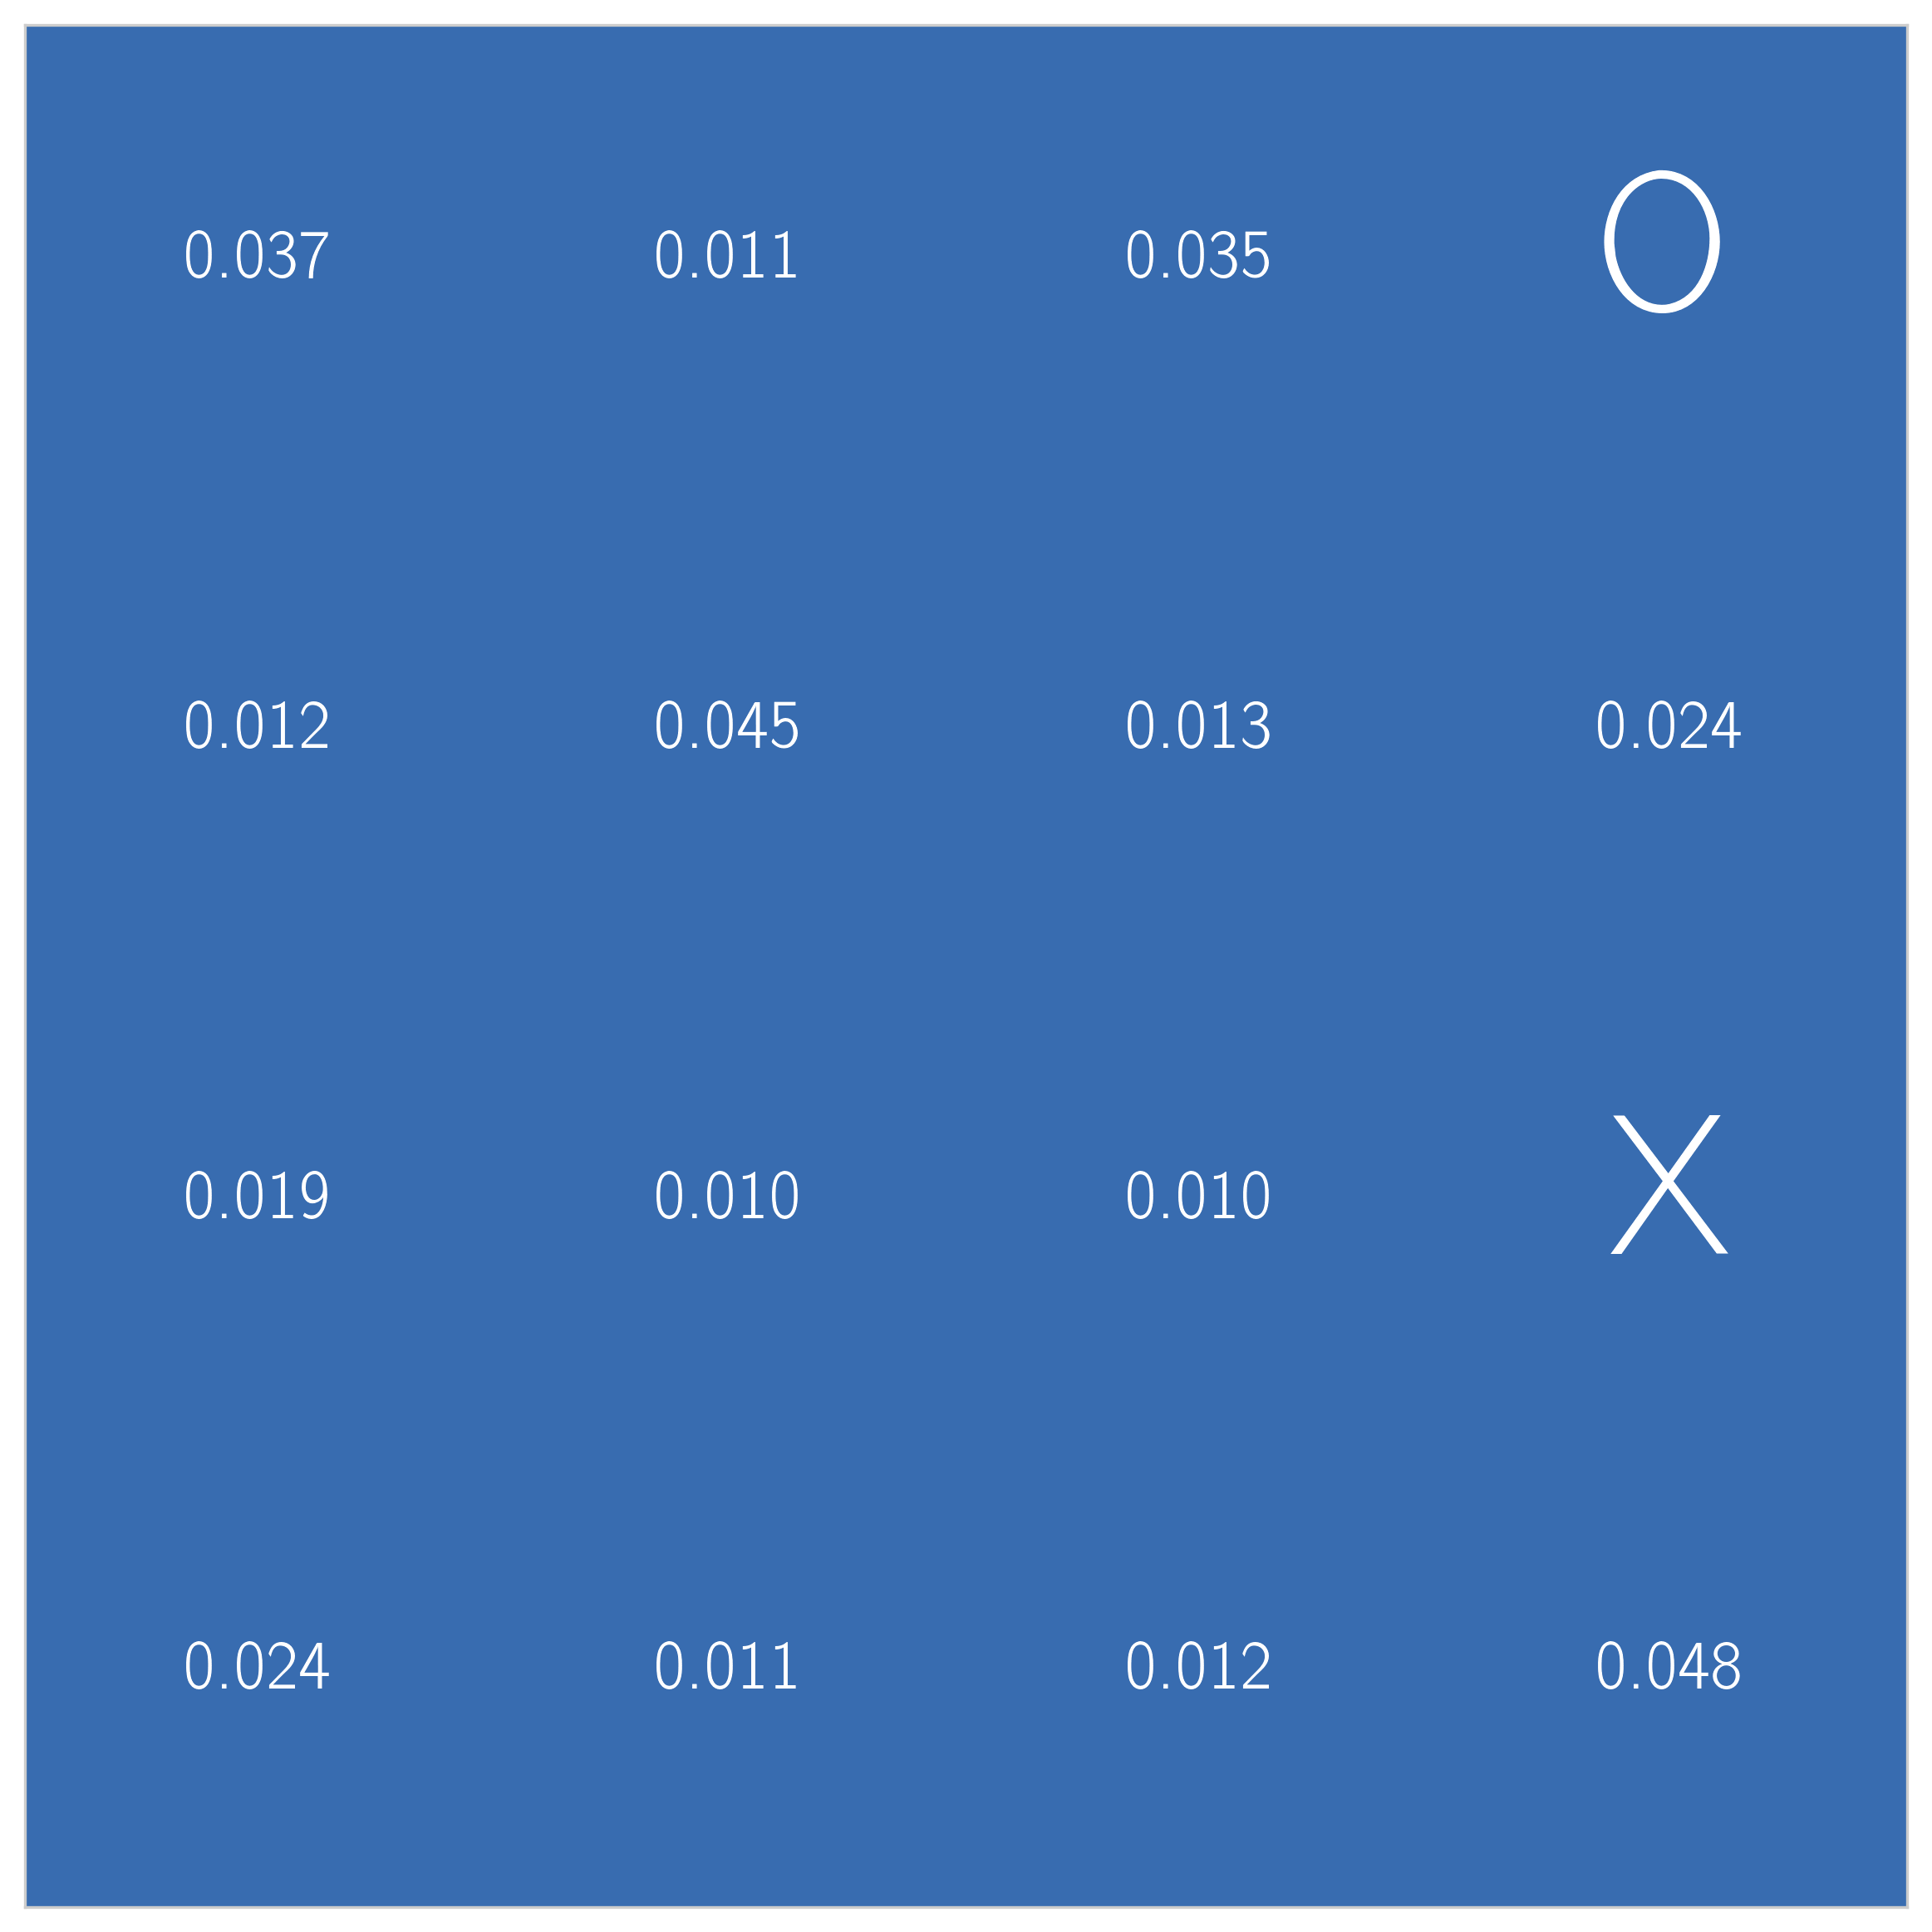

0 [0 0] 0.03733471490062314
1 [0 1] 0.010663762123034734
2 [0 2] 0.034884342105026375
3 [1 0] 0.011500013383544217
4 [1 1] 0.04477262626191382
5 [1 2] 0.012788286023337187
6 [1 3] 0.023540322988115456
7 [2 0] 0.019303124869418178
8 [2 1] 0.009590919362883215
9 [2 2] 0.01023299422924249
10 [3 0] 0.02382190416839945
11 [3 1] 0.01076390513878872
12 [3 2] 0.012118128681303193
13 [3 3] 0.04764645808962121


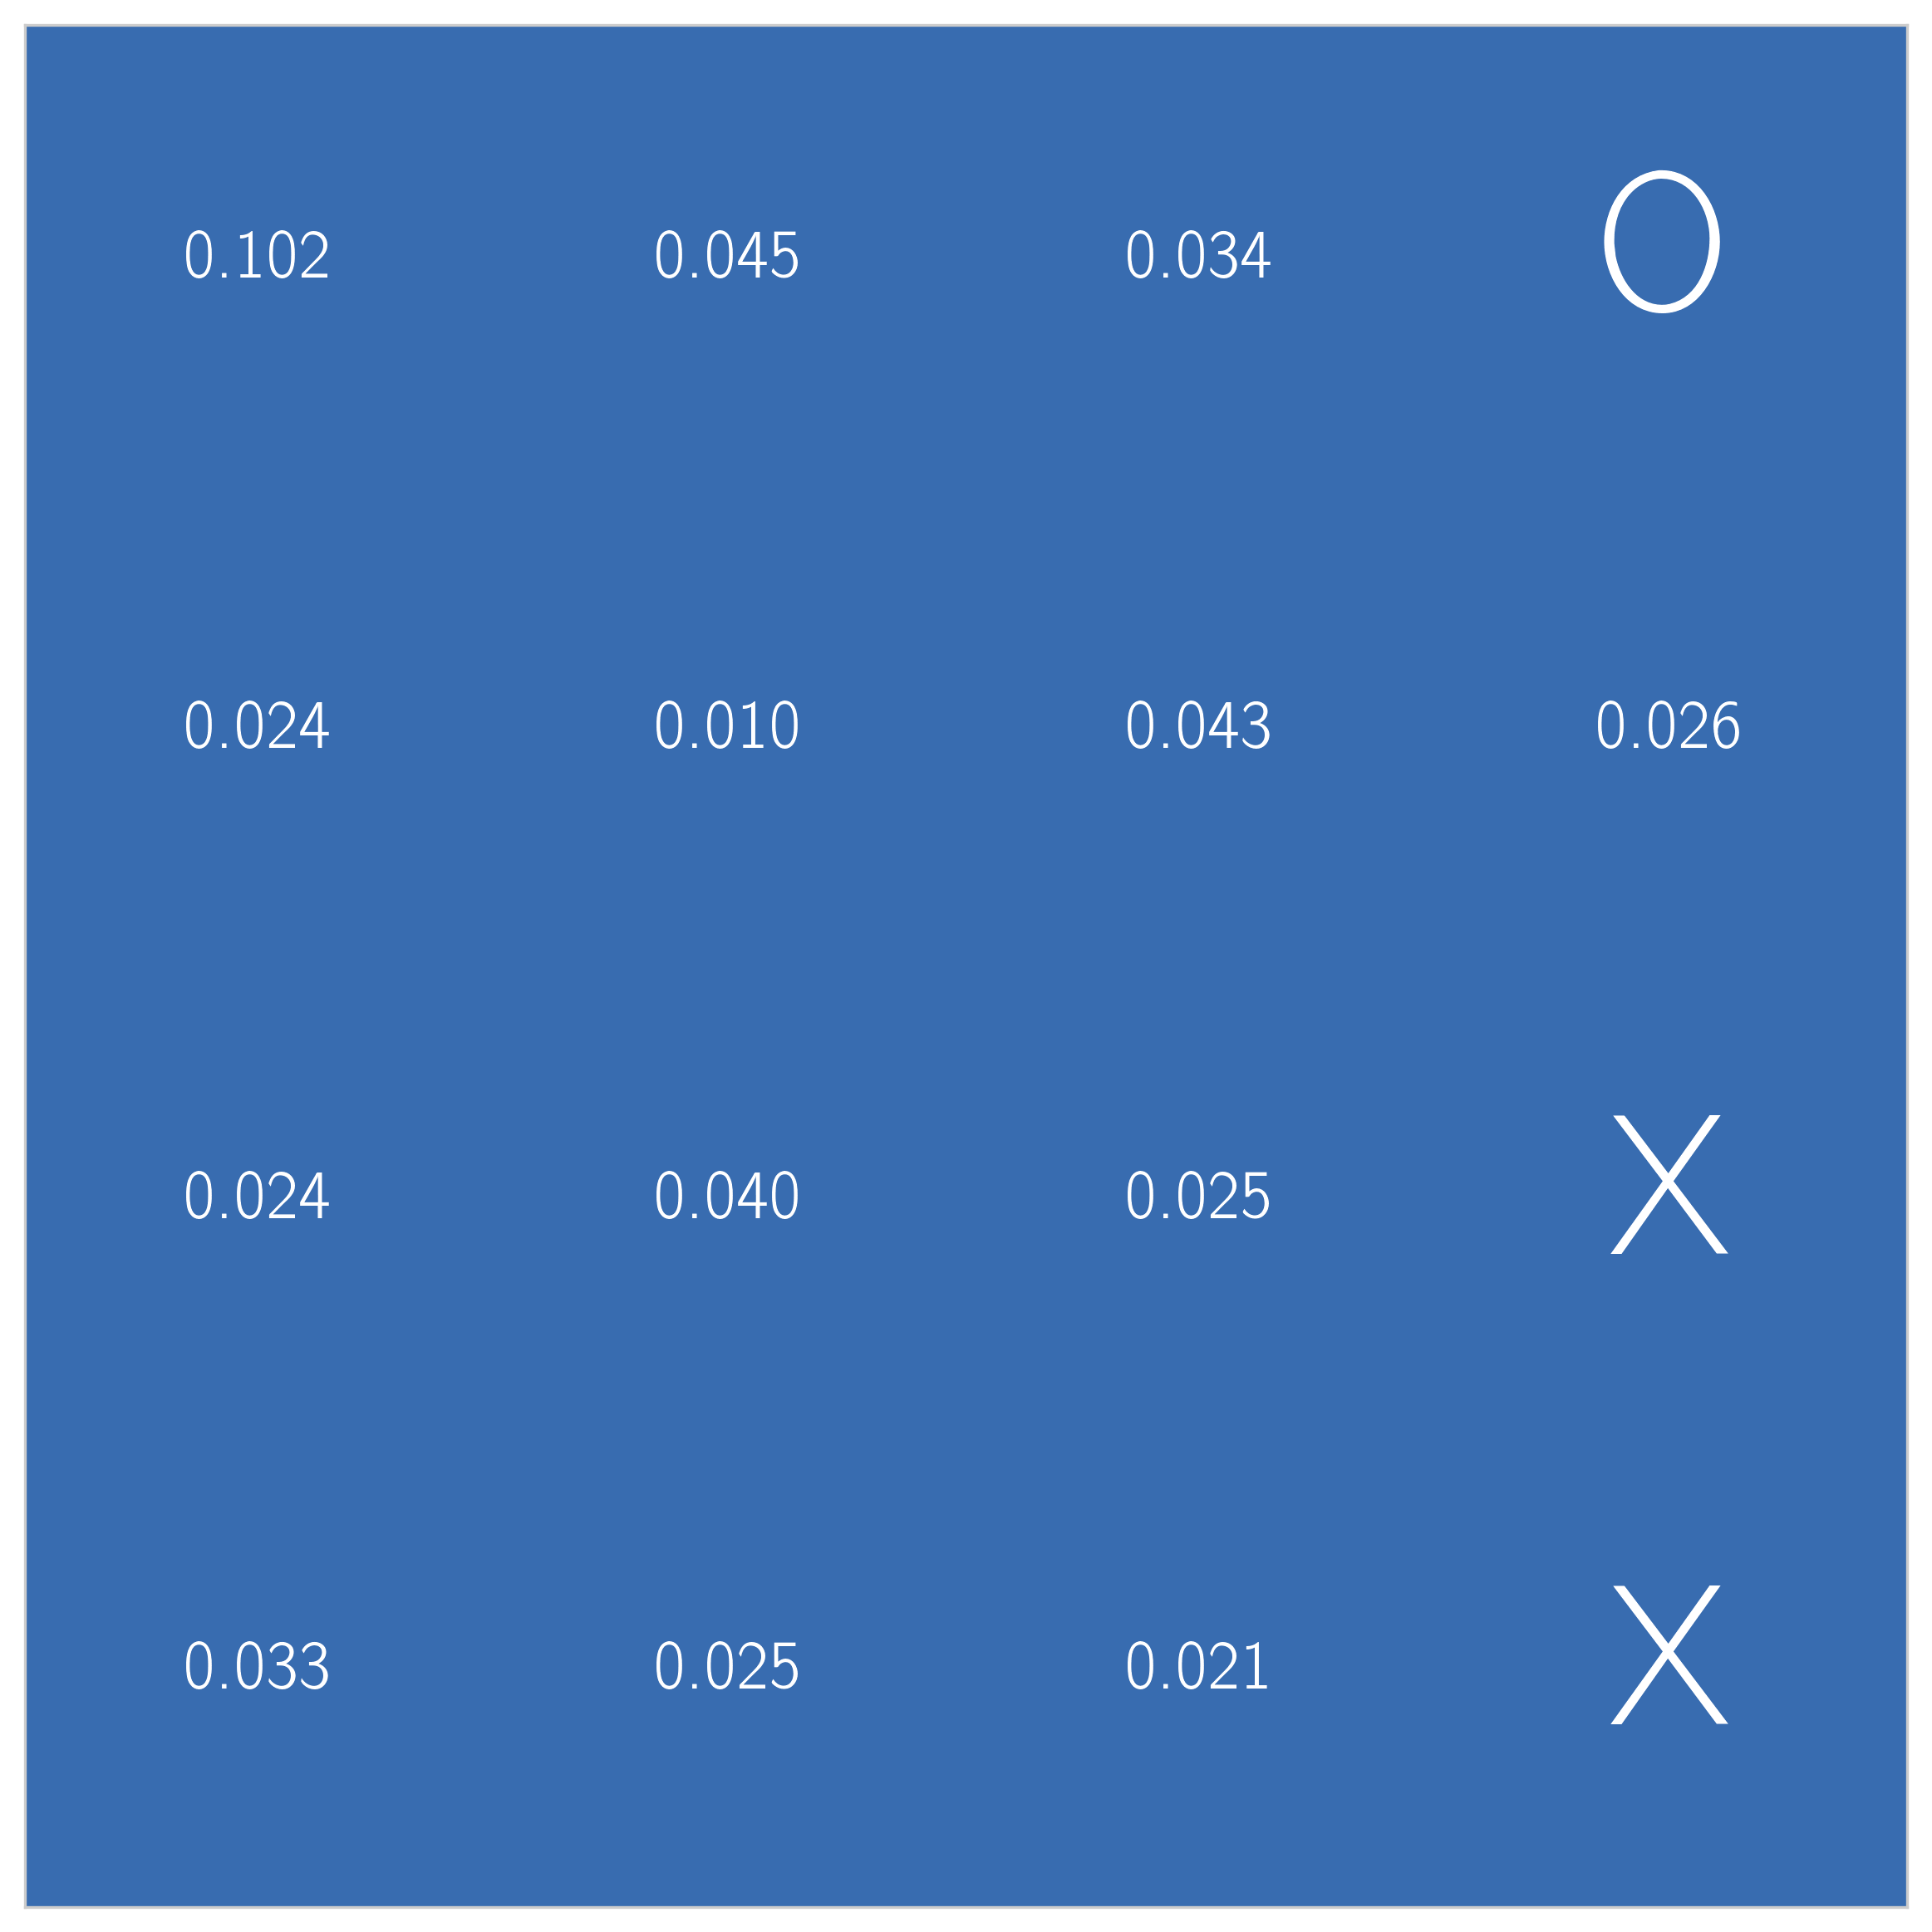

0 [0 0] 0.10215482012468569
1 [0 1] 0.04480725117194075
2 [0 2] 0.033536161246920514
3 [1 0] 0.023696792112985848
4 [1 1] 0.00960653001247004
5 [1 2] 0.042929228878476215
6 [1 3] 0.025534754960017482
7 [2 0] 0.02424658911363062
8 [2 1] 0.040347804389928126
9 [2 2] 0.02536783034956909
10 [3 0] 0.03287662198230869
11 [3 1] 0.025304354696925265
12 [3 2] 0.020512792608222363


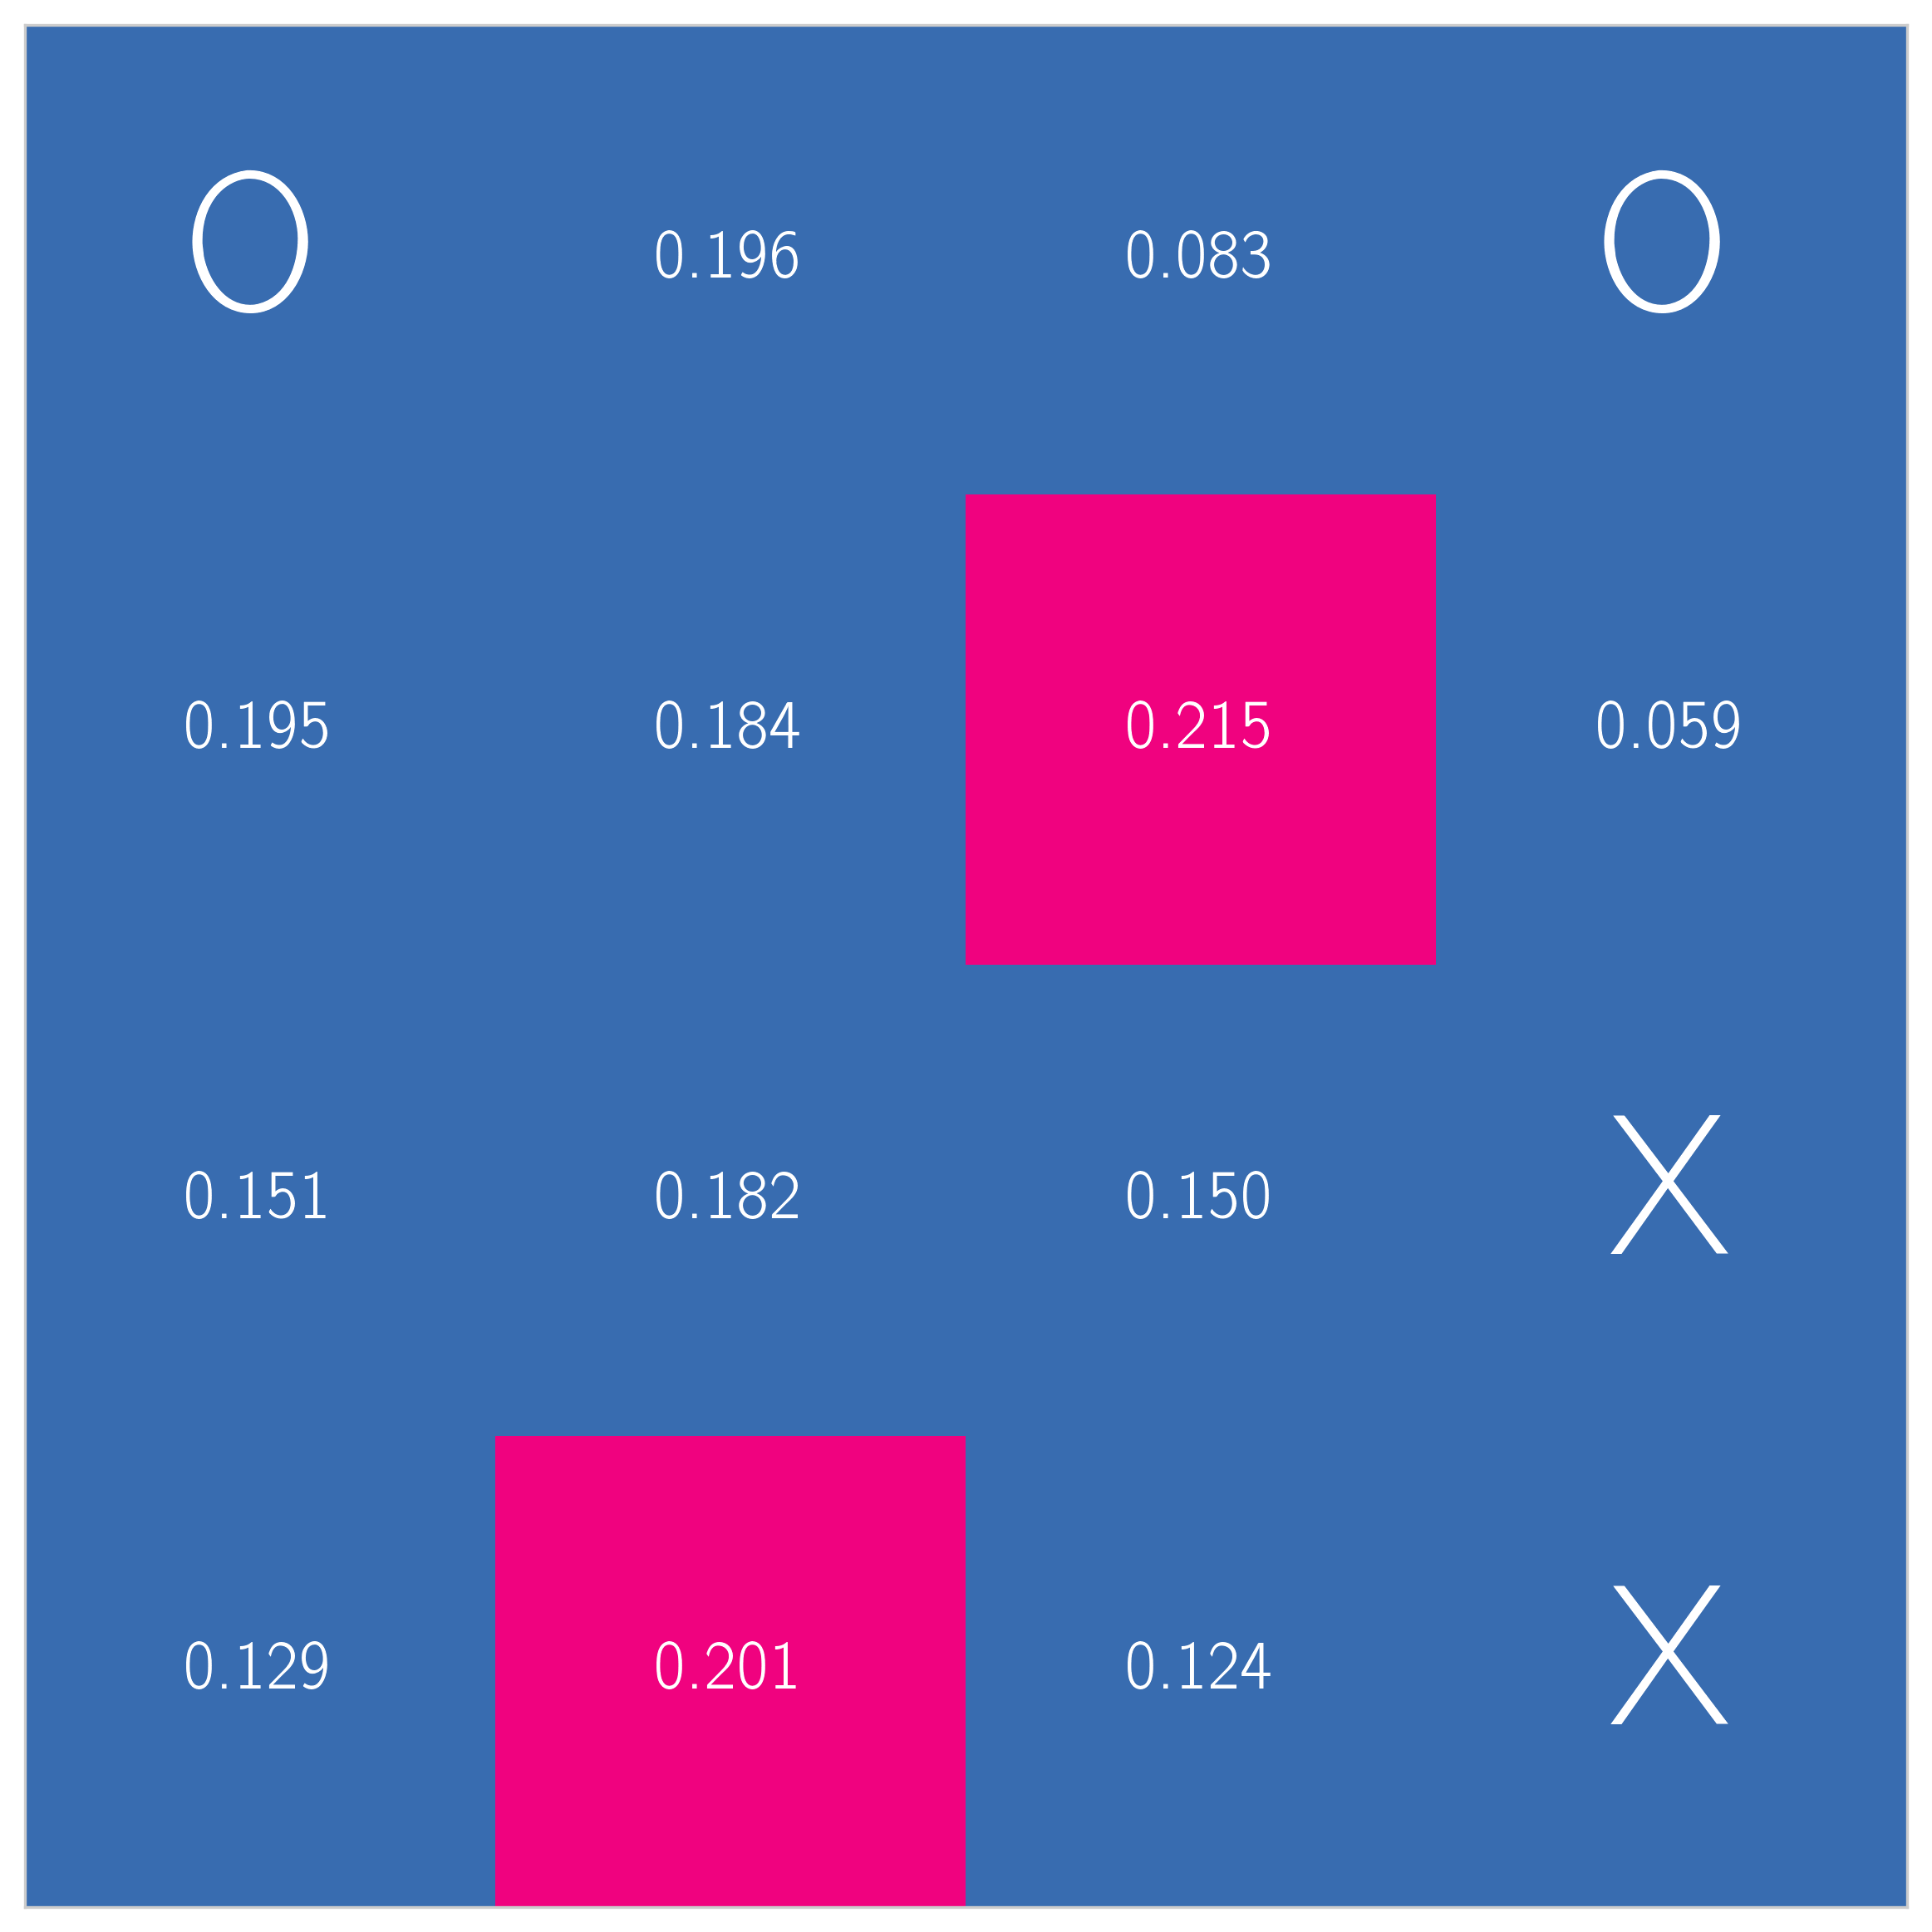

0 [0 1] 0.1957932910905119
1 [0 2] 0.08260483023917148
2 [1 0] 0.19508640563038052
3 [1 1] 0.18432646073019582
4 [1 2] 0.21473969705525903
5 [1 3] 0.0587409301512506
6 [2 0] 0.1506089761294449
7 [2 1] 0.18180008245542692
8 [2 2] 0.15024792862504247
9 [3 0] 0.129000731527094
10 [3 1] 0.2008114021497905
11 [3 2] 0.12381525024309388


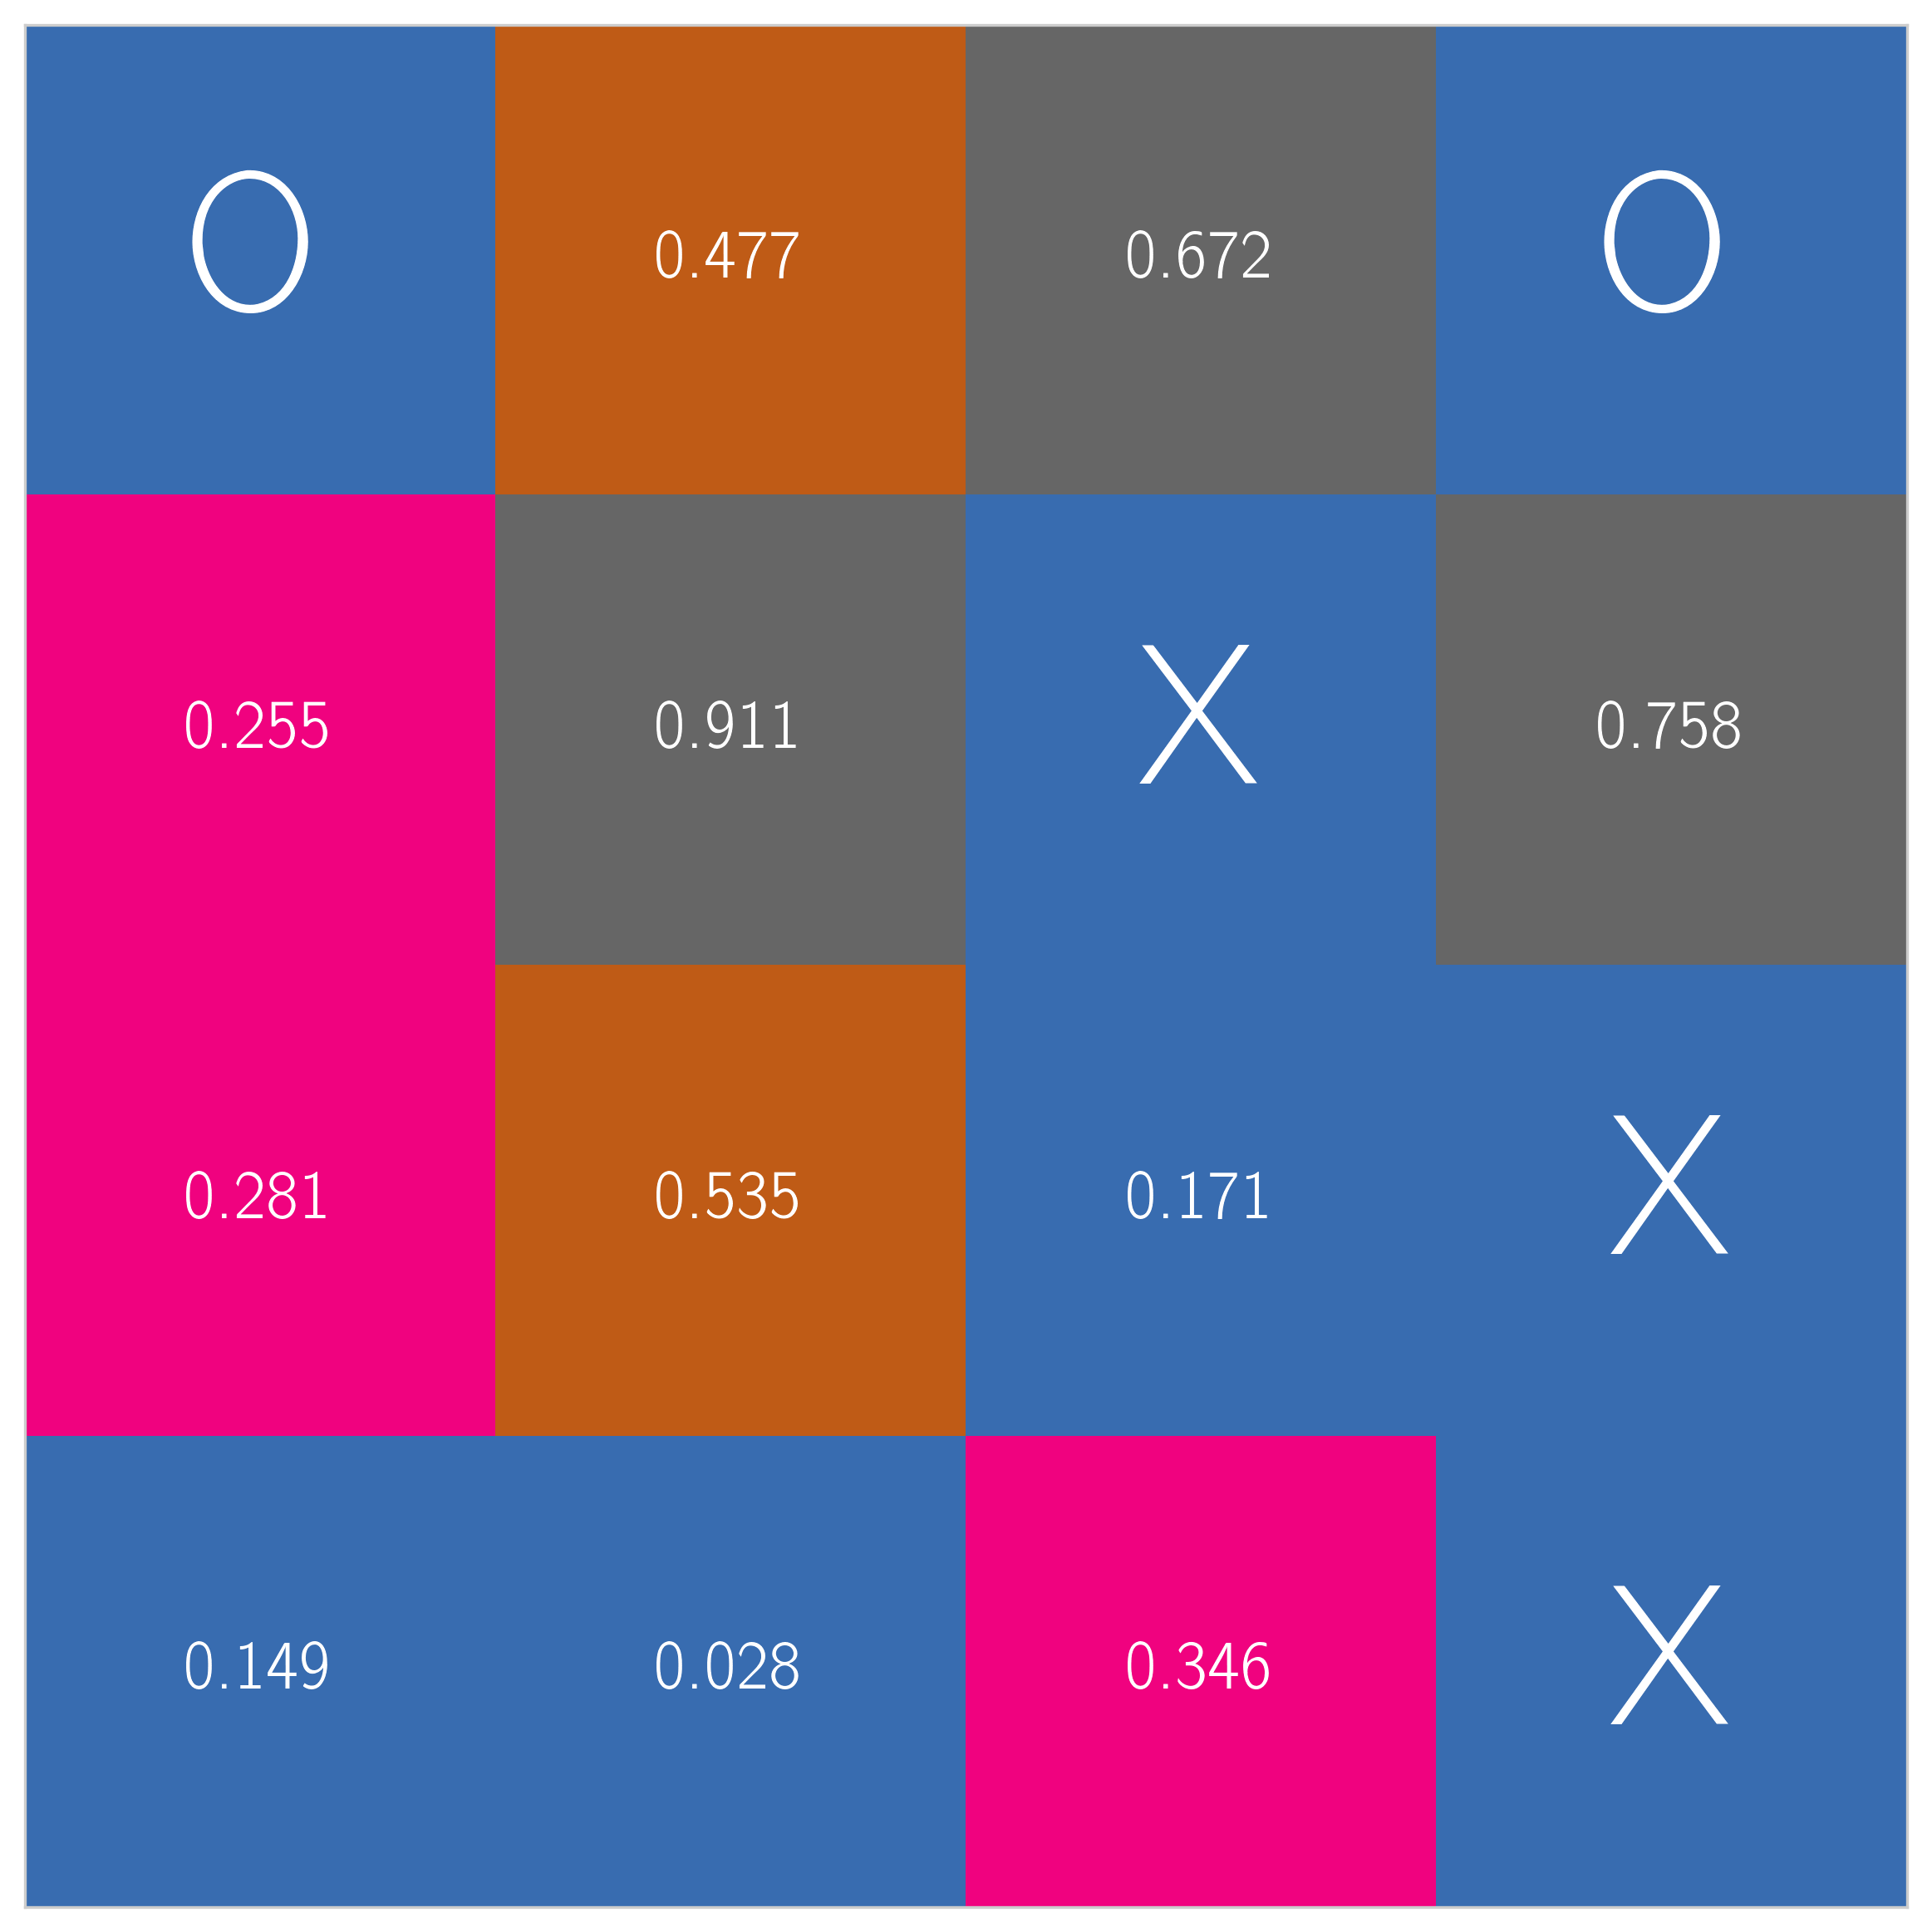

0 [0 1] 0.4767510824007727
1 [0 2] 0.6718934687337195
2 [1 0] 0.25515233962162
3 [1 1] 0.9106923341794618
4 [1 3] 0.758424740759569
5 [2 0] 0.28129450523933763
6 [2 1] 0.5351268270403226
7 [2 2] 0.17060984805586288
8 [3 0] 0.1486147643021134
9 [3 1] 0.02795081752619022
10 [3 2] 0.34586524992730966


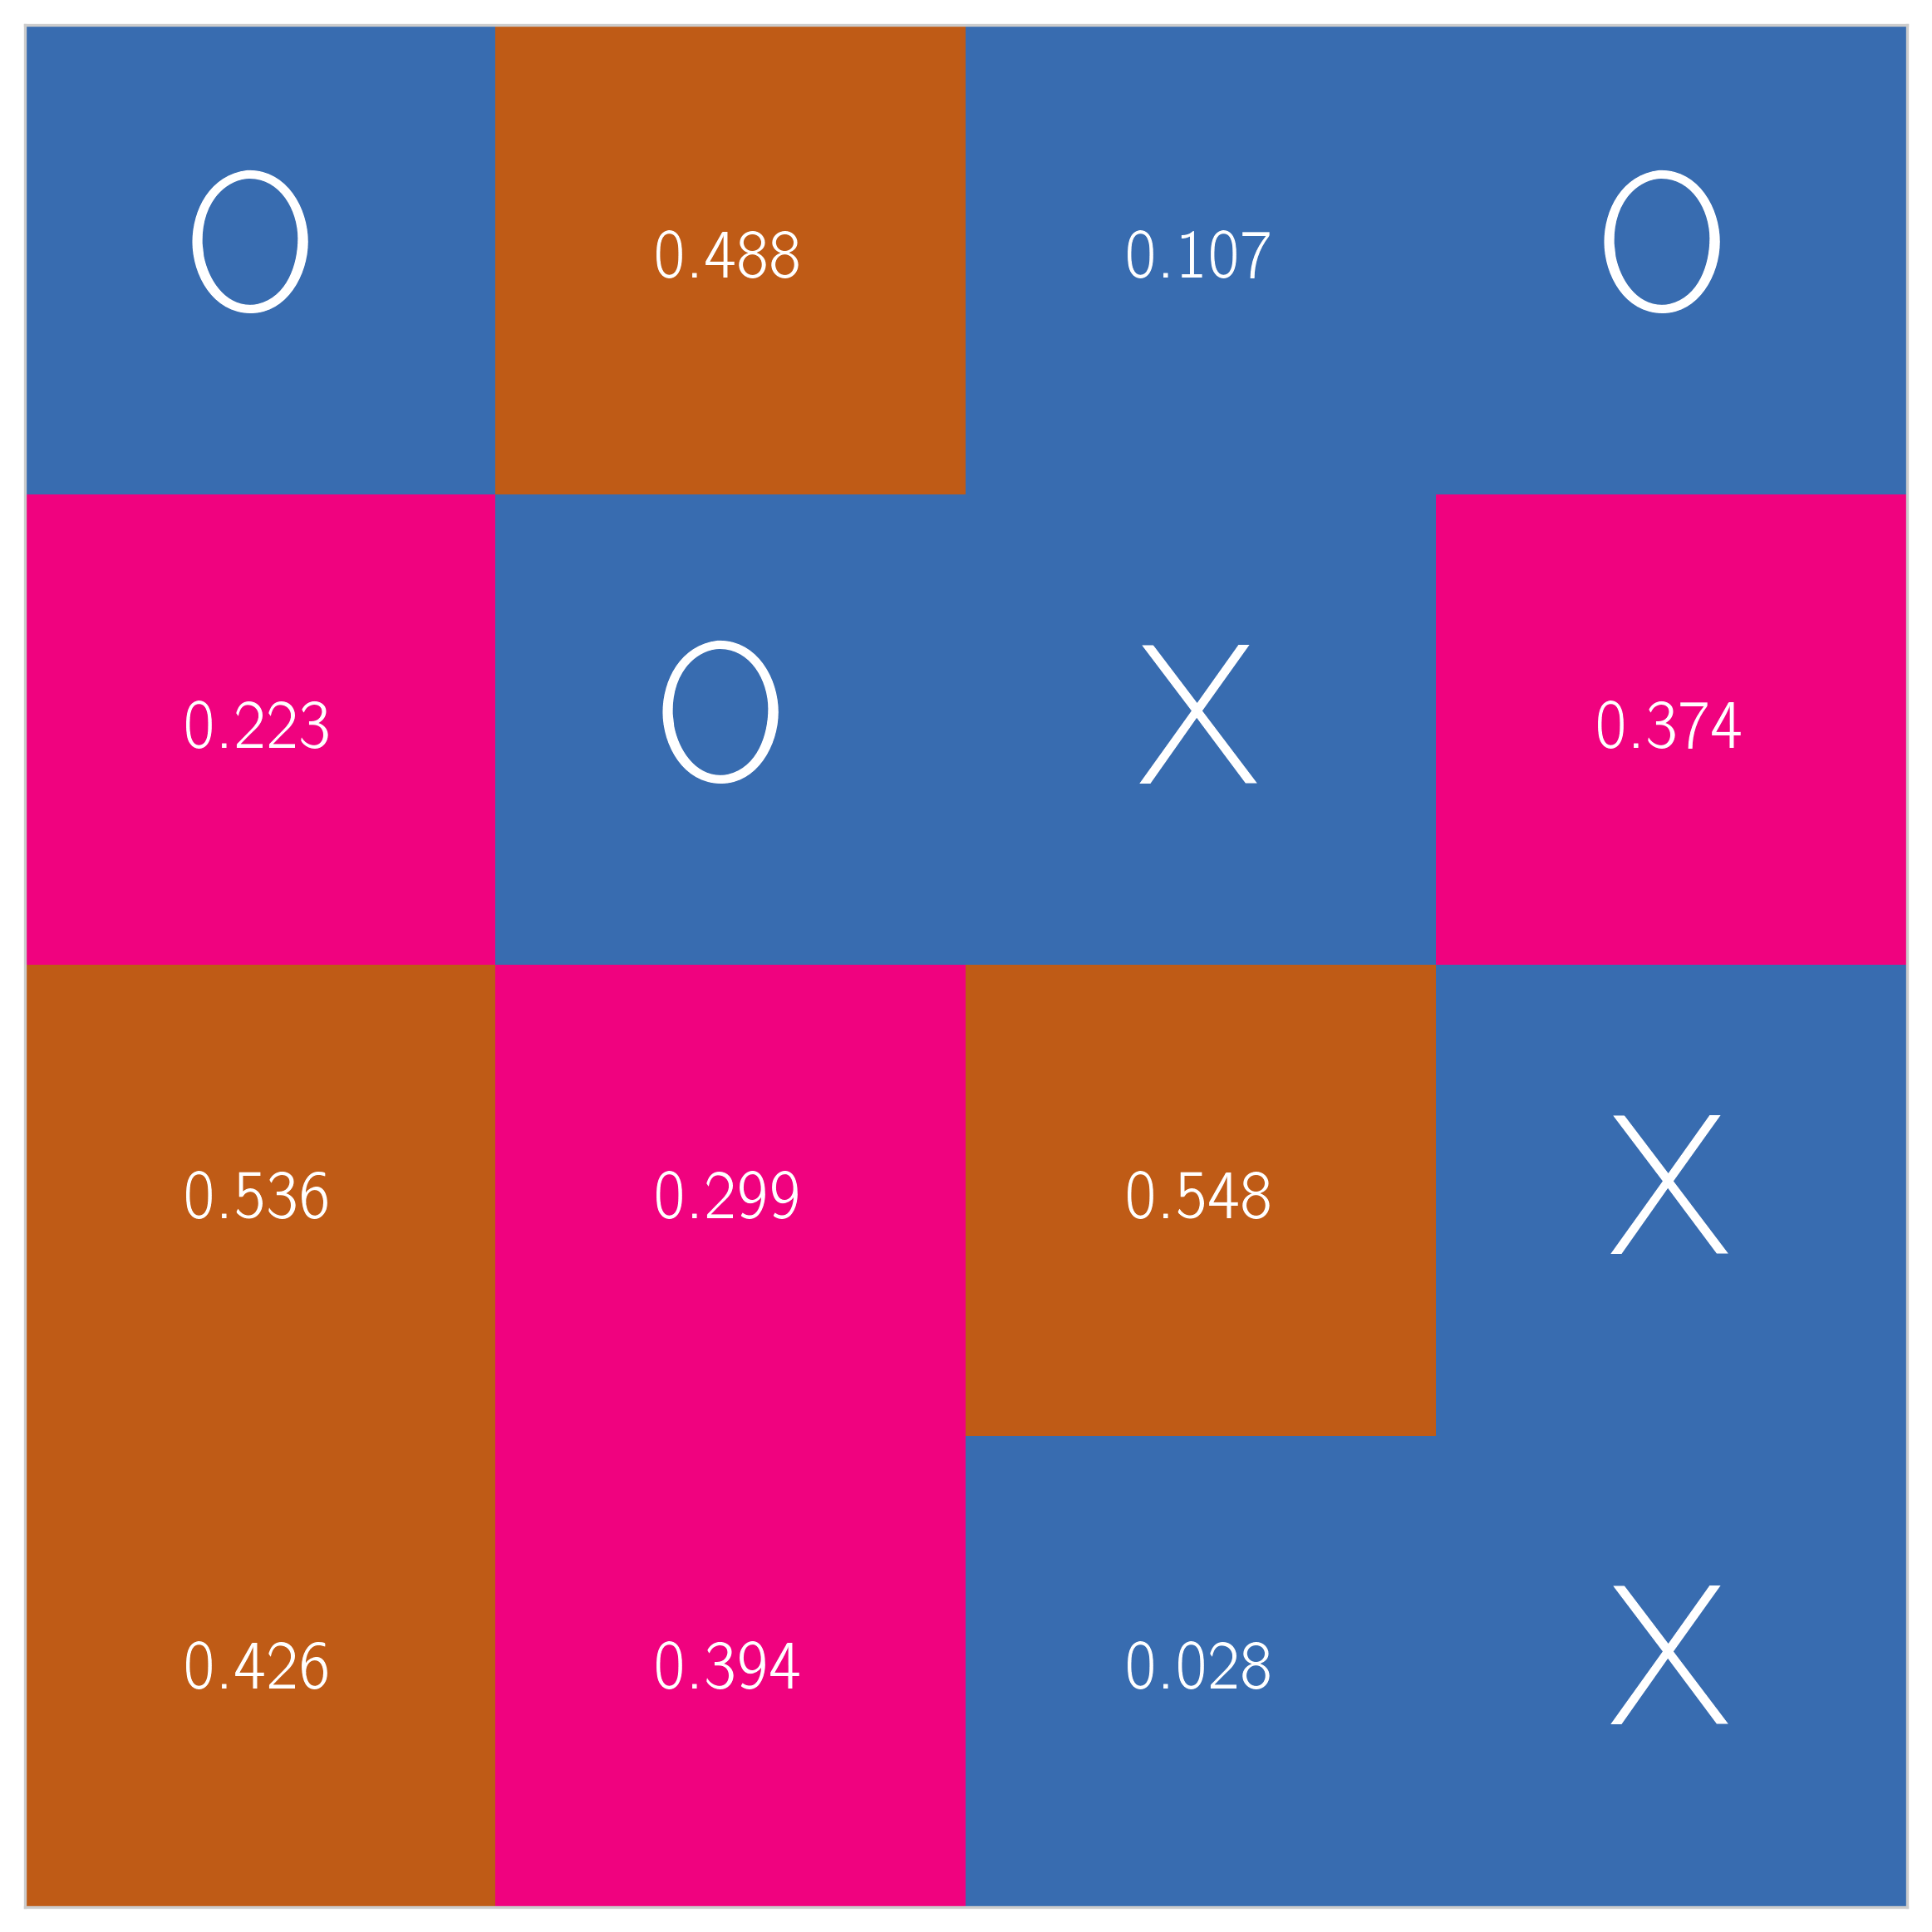

0 [0 1] 0.4875587256969107
1 [0 2] 0.1067054538190706
2 [1 0] 0.22327383106621684
3 [1 3] 0.3742056665569423
4 [2 0] 0.5363739168474446
5 [2 1] 0.299333760253084
6 [2 2] 0.5484482584442313
7 [3 0] 0.4257119071704817
8 [3 1] 0.39380888503743217
9 [3 2] 0.02830647570481548


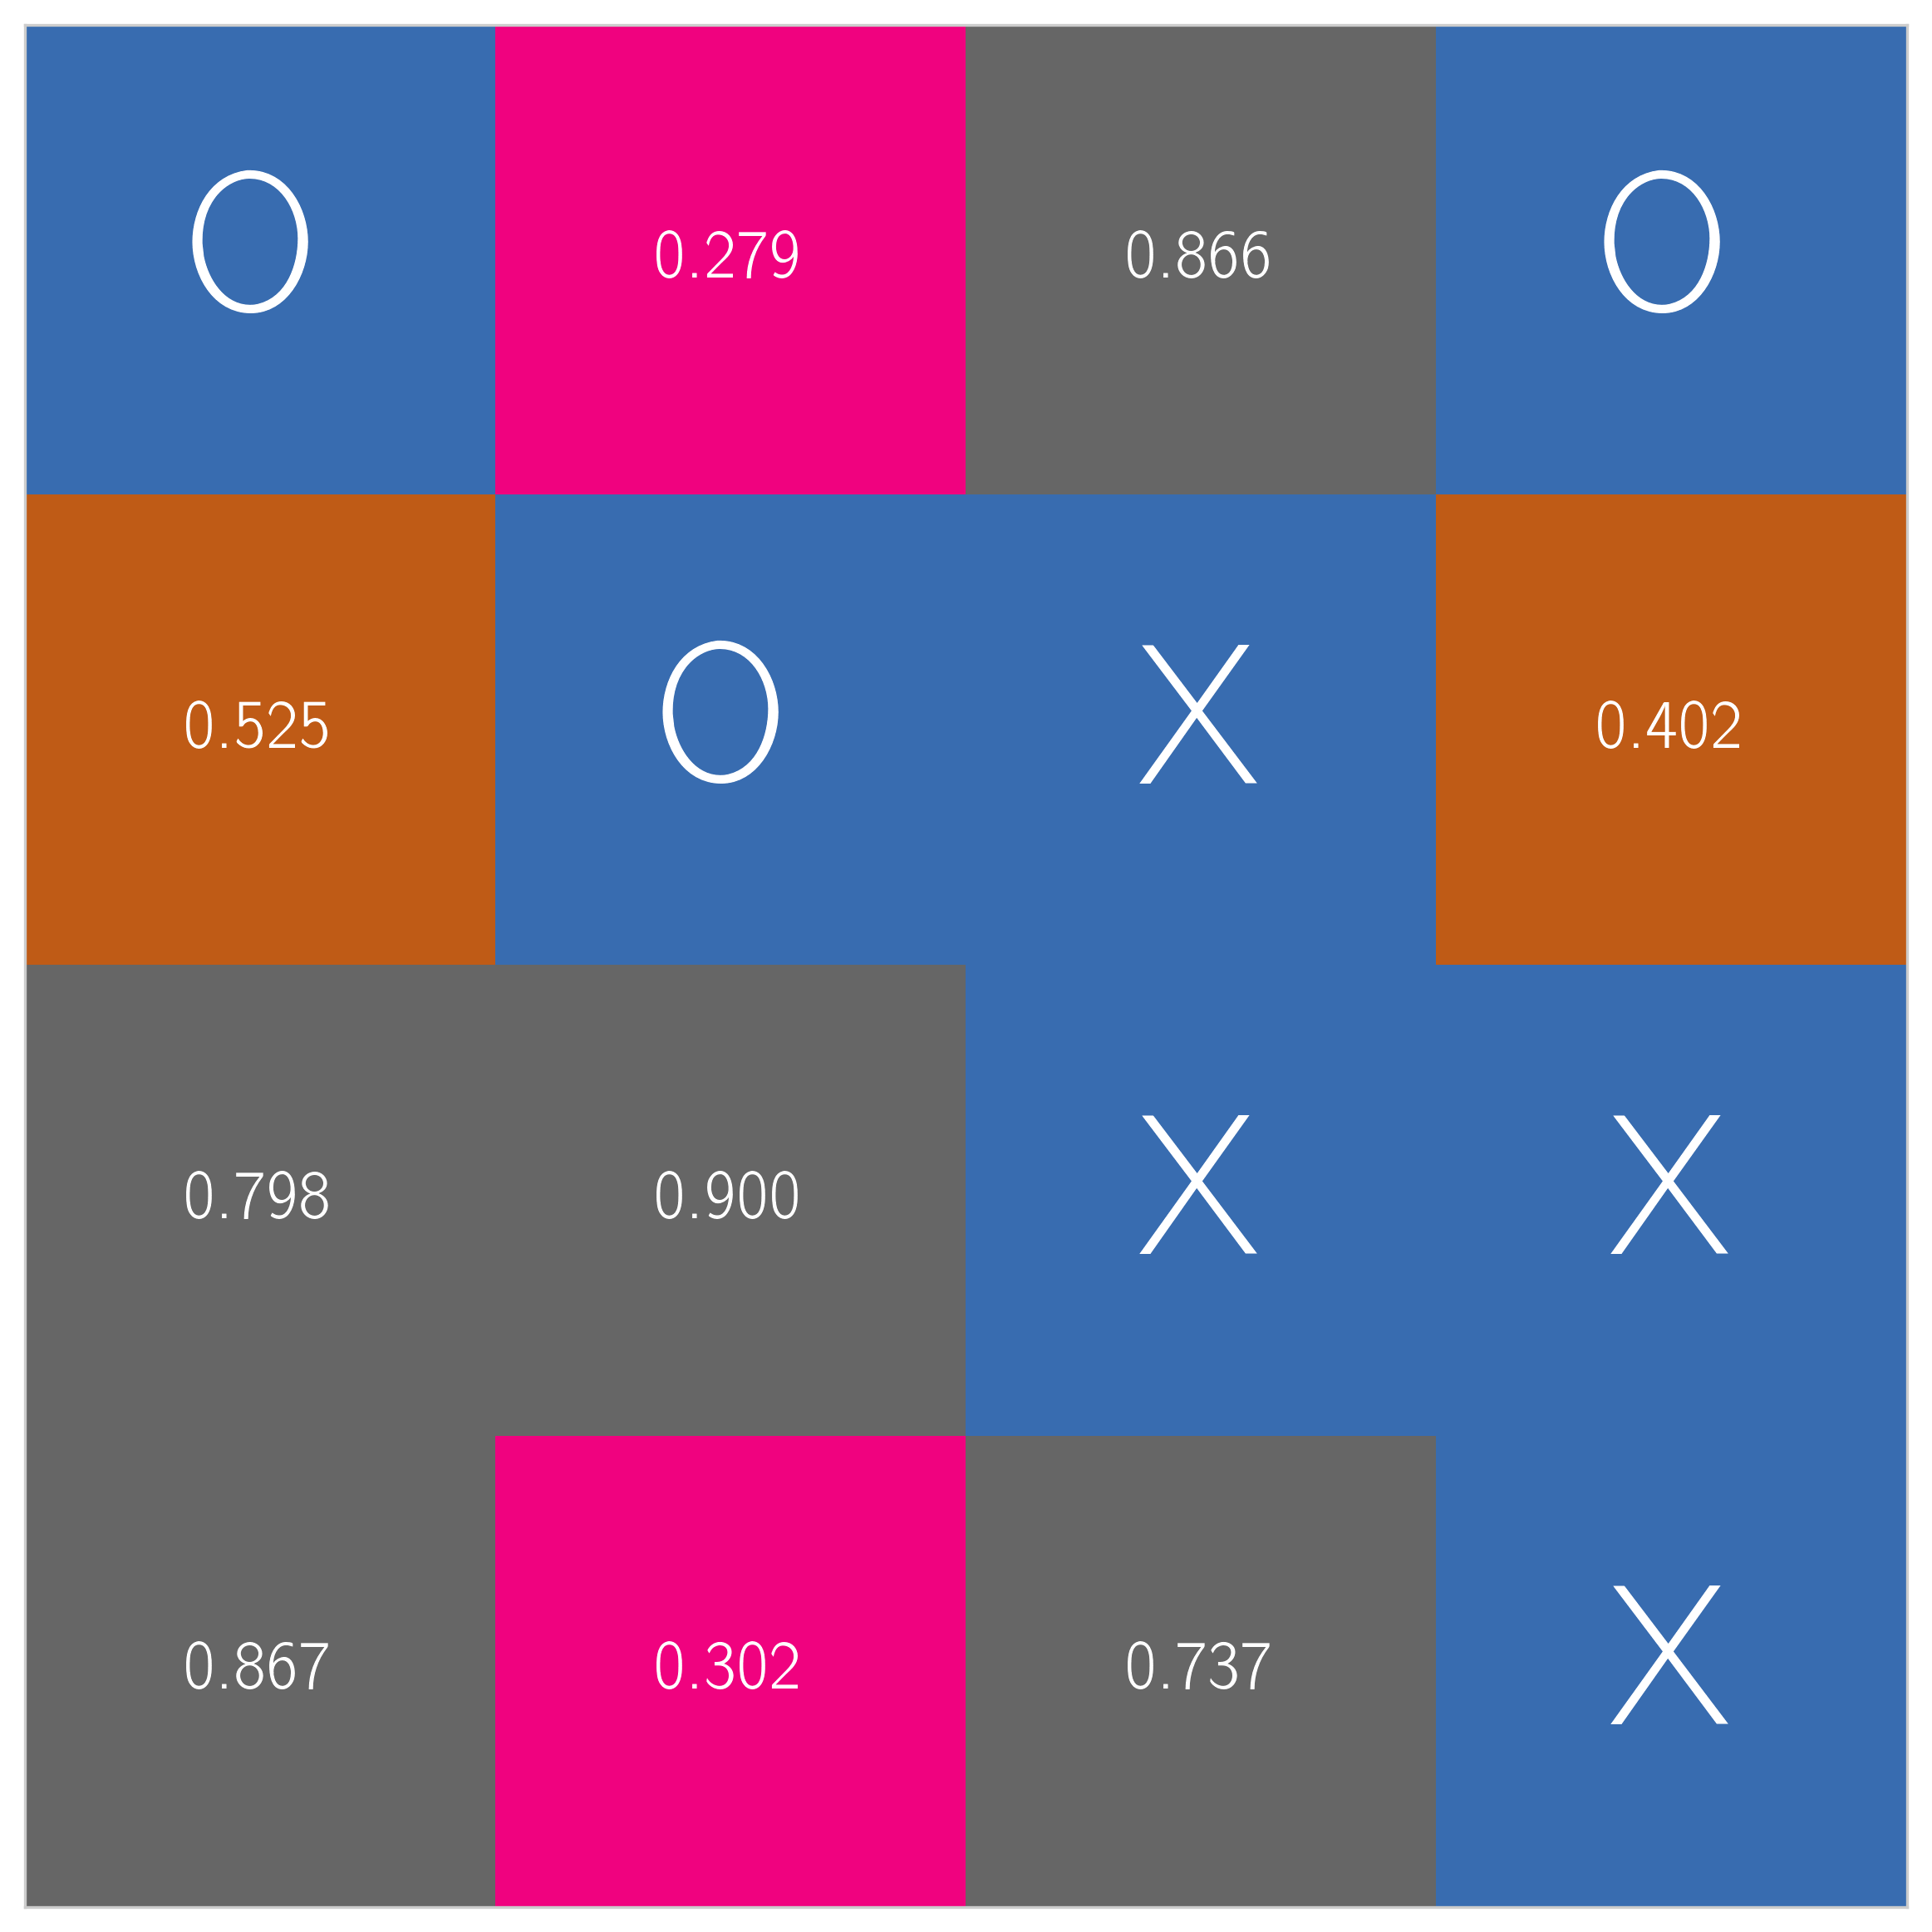

0 [0 1] 0.2793686012022044
1 [0 2] 0.8660127426267493
2 [1 0] 0.5253600685921148
3 [1 3] 0.40154664287573905
4 [2 0] 0.7975549389012654
5 [2 1] 0.9001683168797153
6 [3 0] 0.8672250466990815
7 [3 1] 0.3024566296527187
8 [3 2] 0.7369260252380783


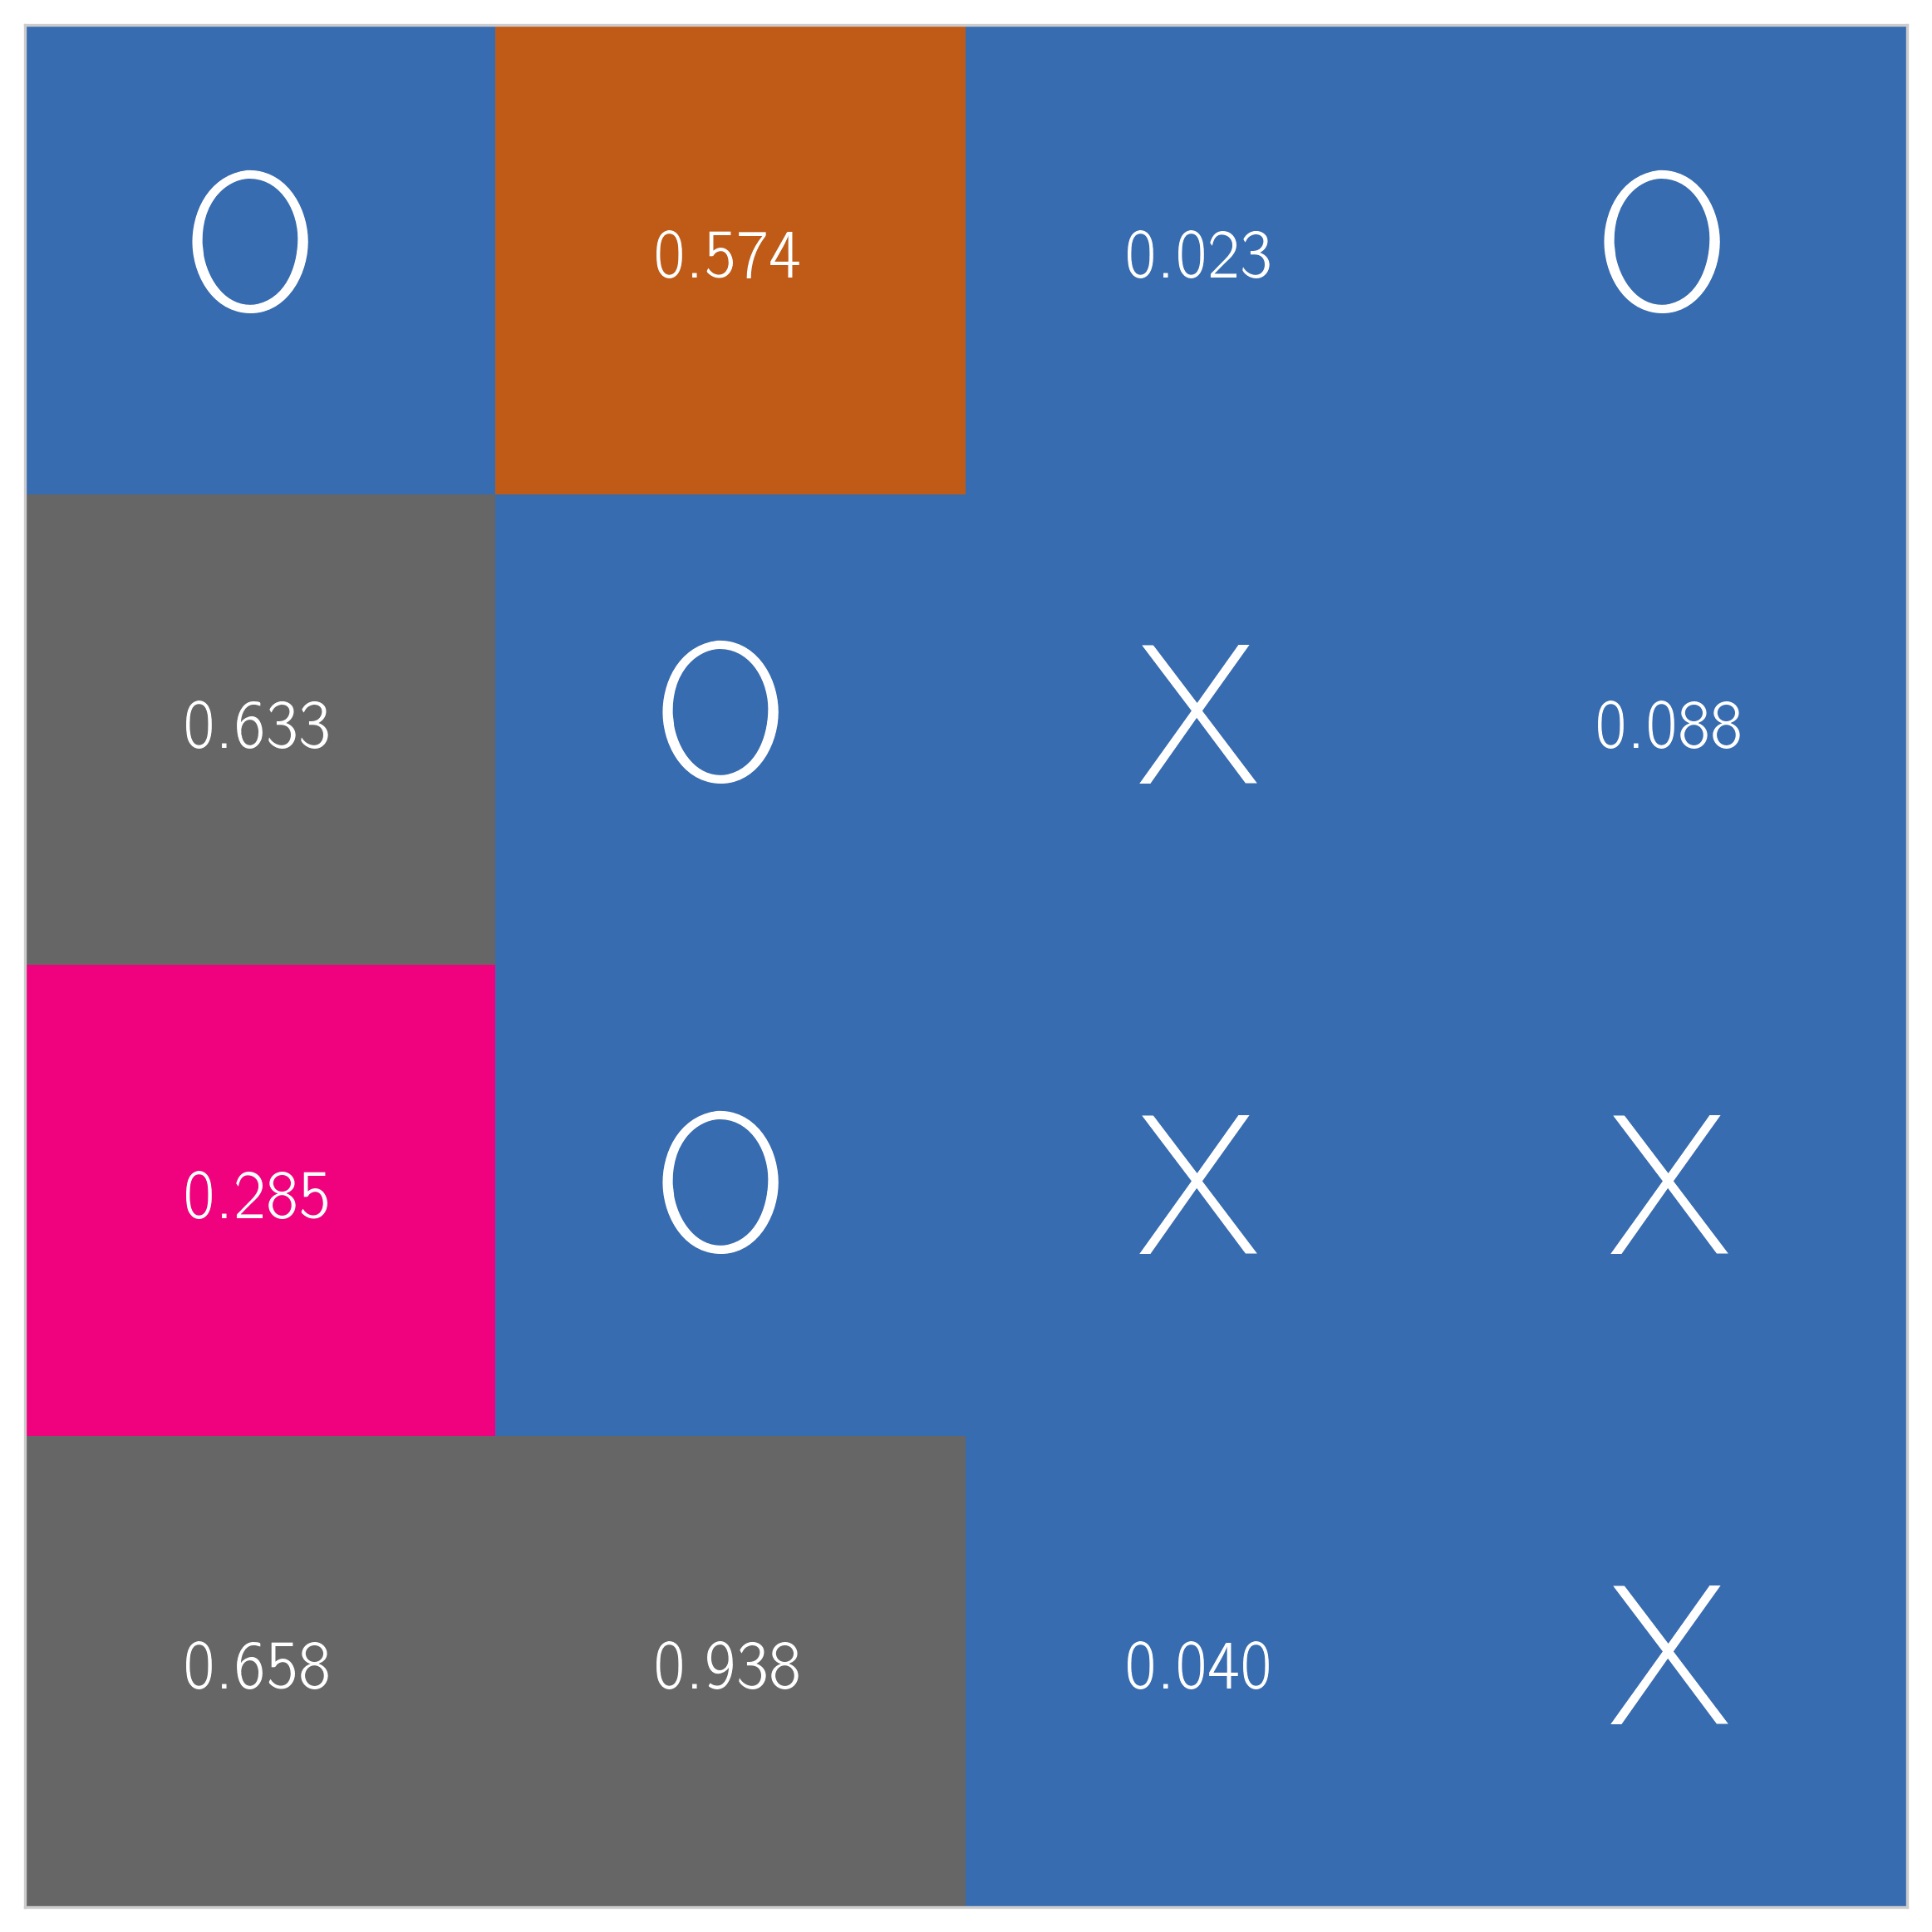

0 [0 1] 0.5736019528834262
1 [0 2] 0.02349125012331721
2 [1 0] 0.632765003089355
3 [1 3] 0.08827645636094383
4 [2 0] 0.28520391284671154
5 [3 0] 0.6577840253024148
6 [3 1] 0.9380028096936167
7 [3 2] 0.04006570841289303


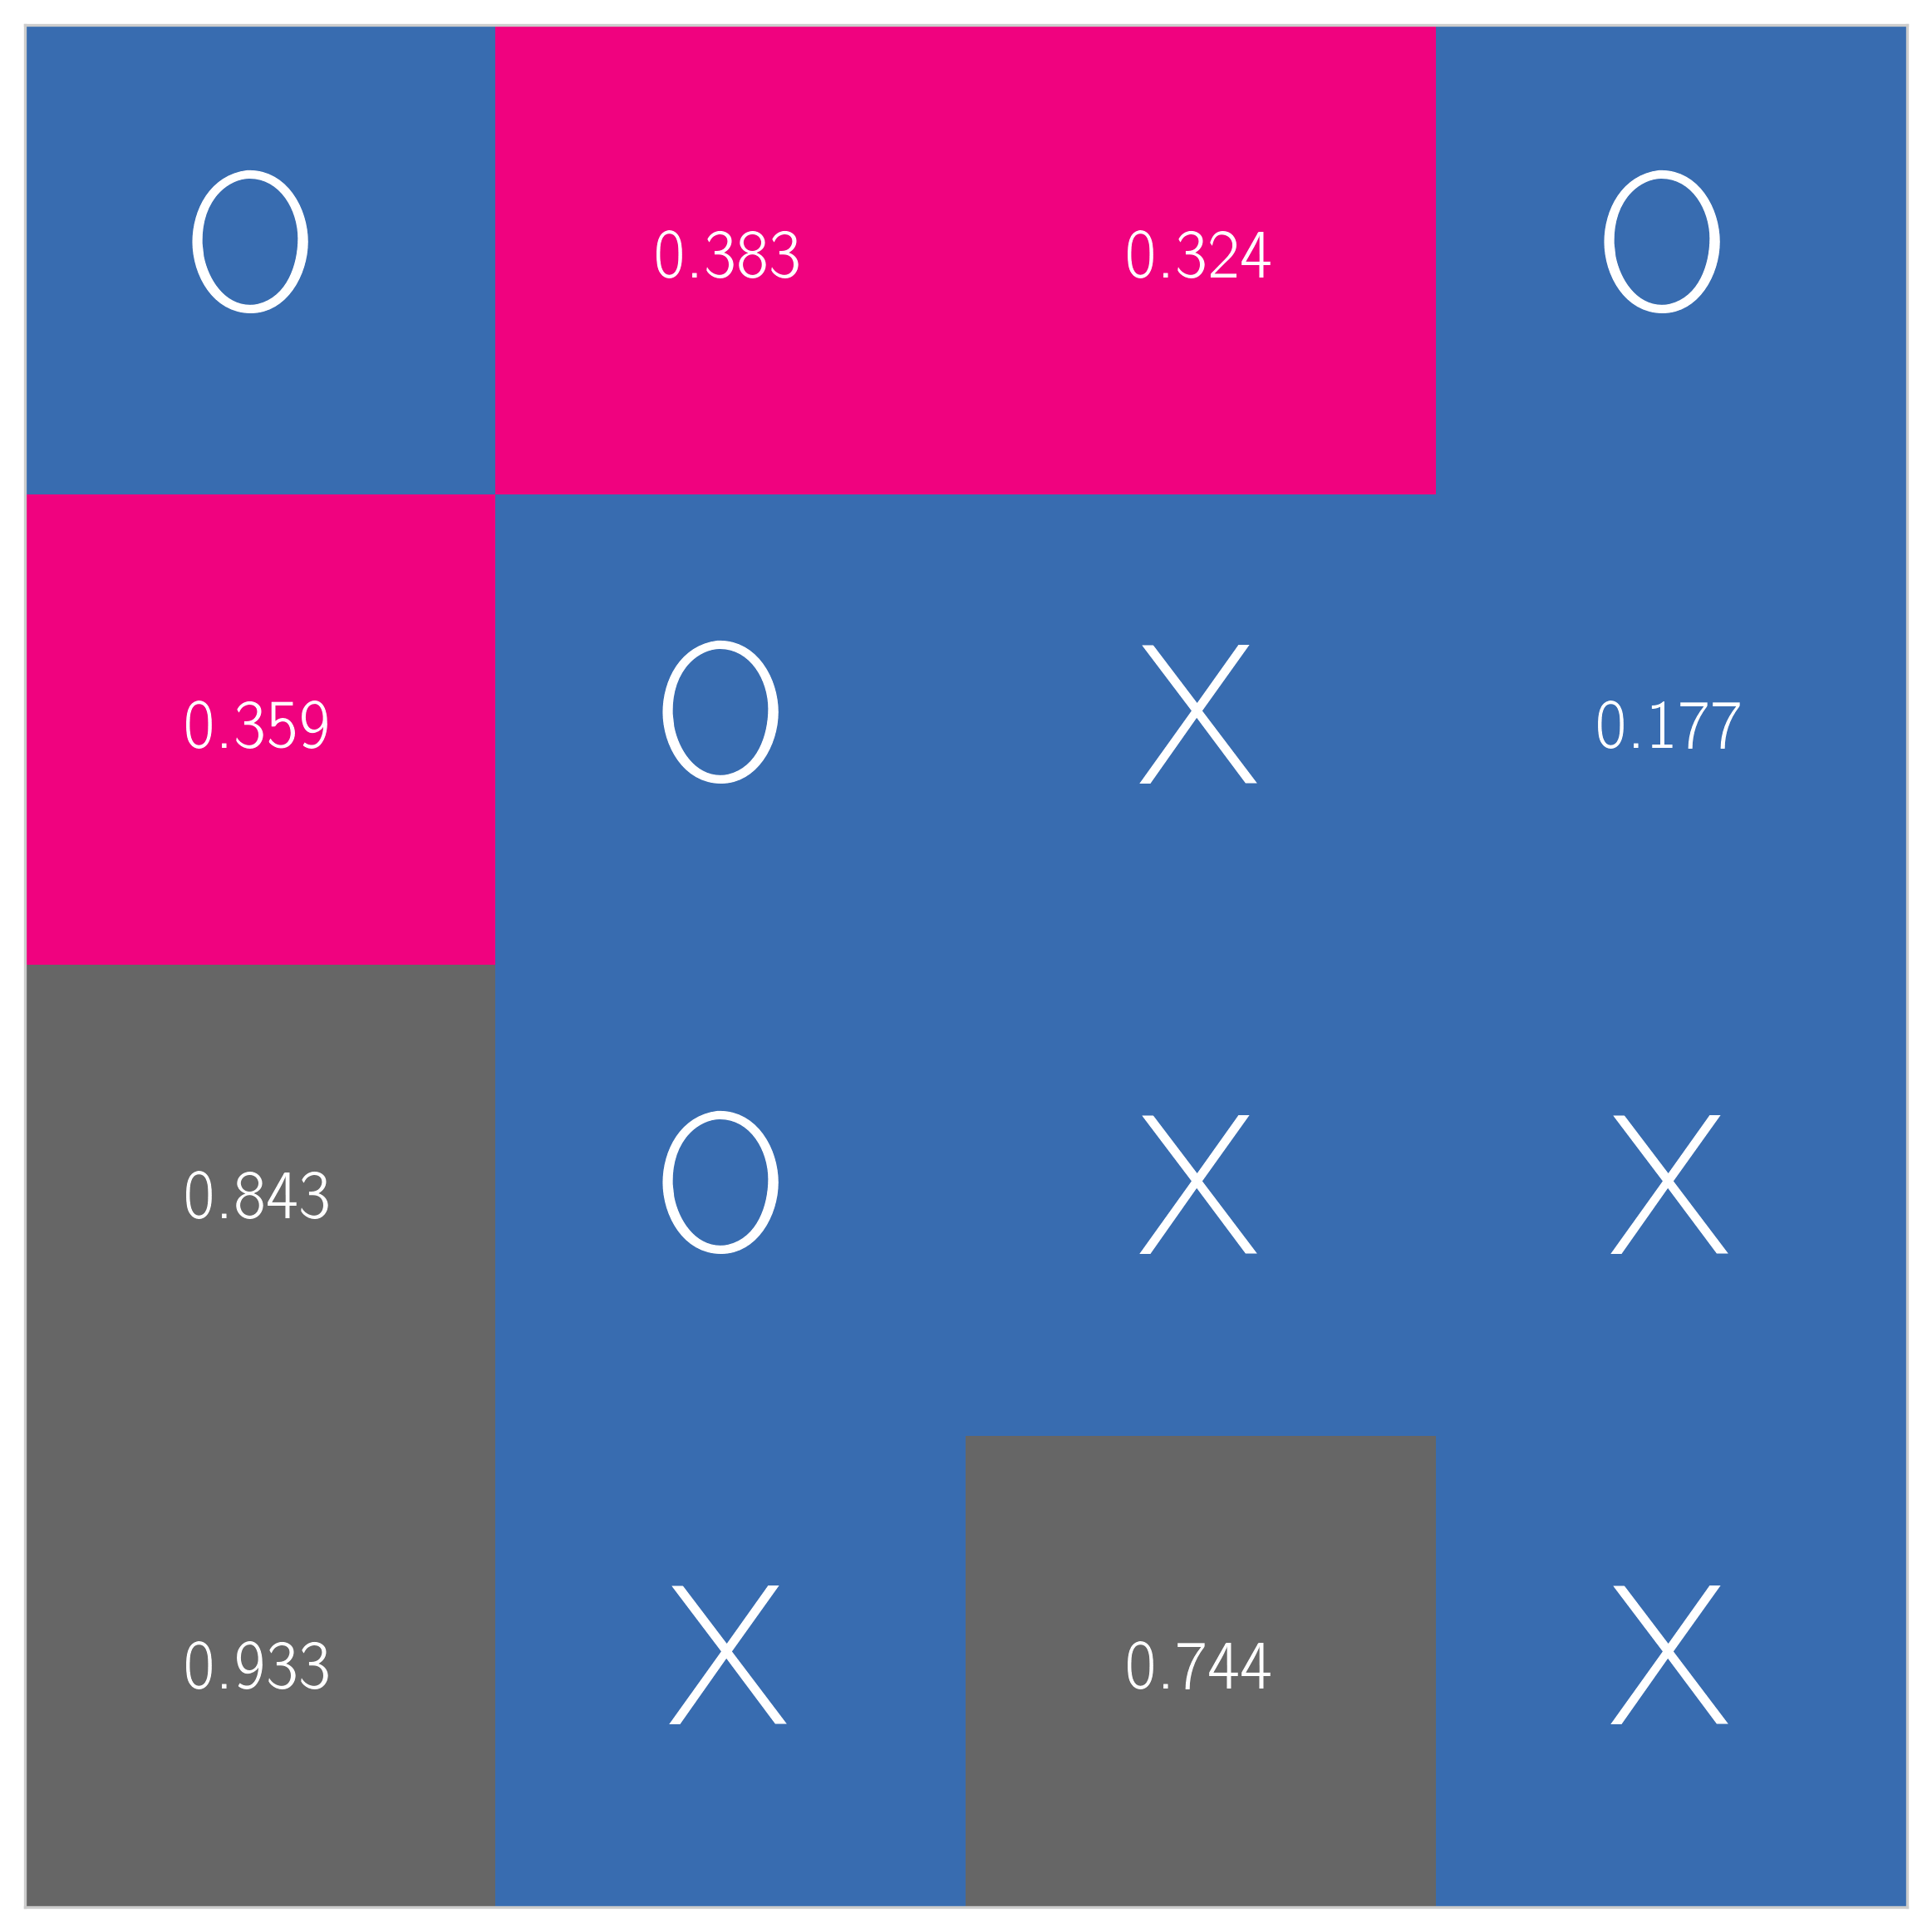

0 [0 1] 0.383455998581249
1 [0 2] 0.3243231776123454
2 [1 0] 0.35945023310553376
3 [1 3] 0.17719808554873143
4 [2 0] 0.8429121683233622
5 [3 0] 0.9330460049480649
6 [3 2] 0.7441632641677595


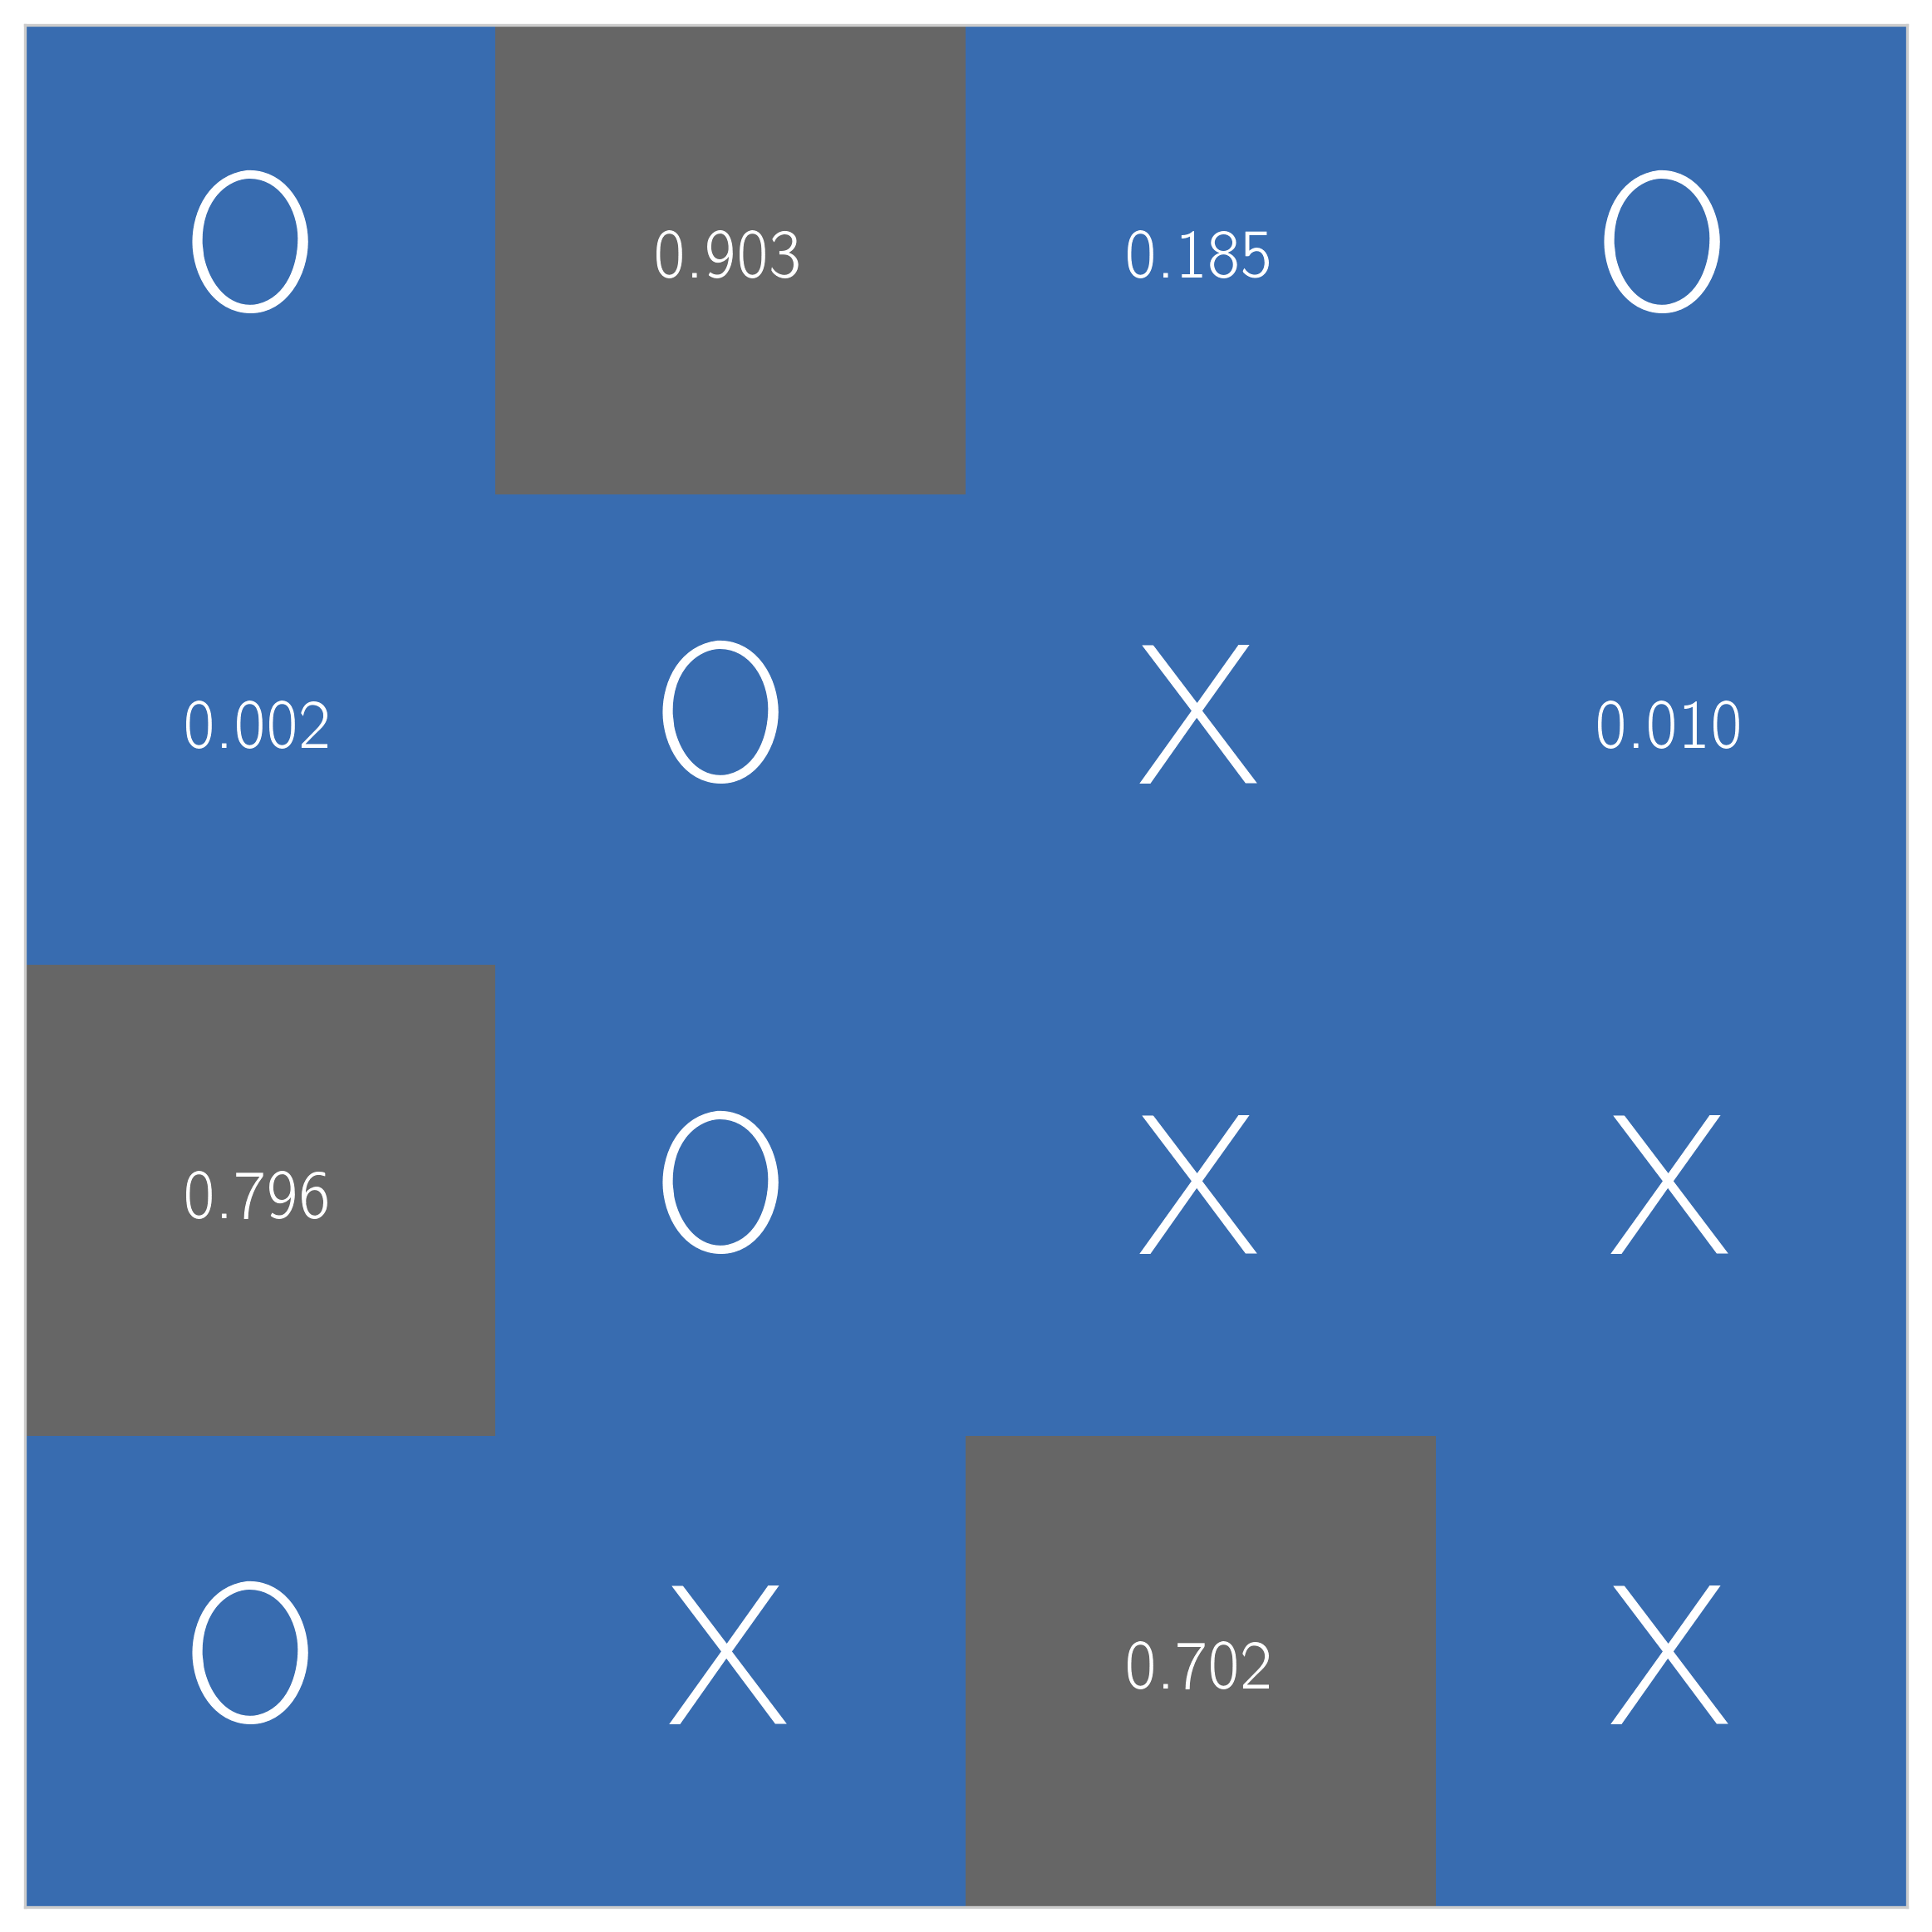

0 [0 1] 0.9033308634378883
1 [0 2] 0.18471253624774542
2 [1 0] 0.0020296359041223067
3 [1 3] 0.00993477561934386
4 [2 0] 0.7961708080521562
5 [3 2] 0.7016894877362003


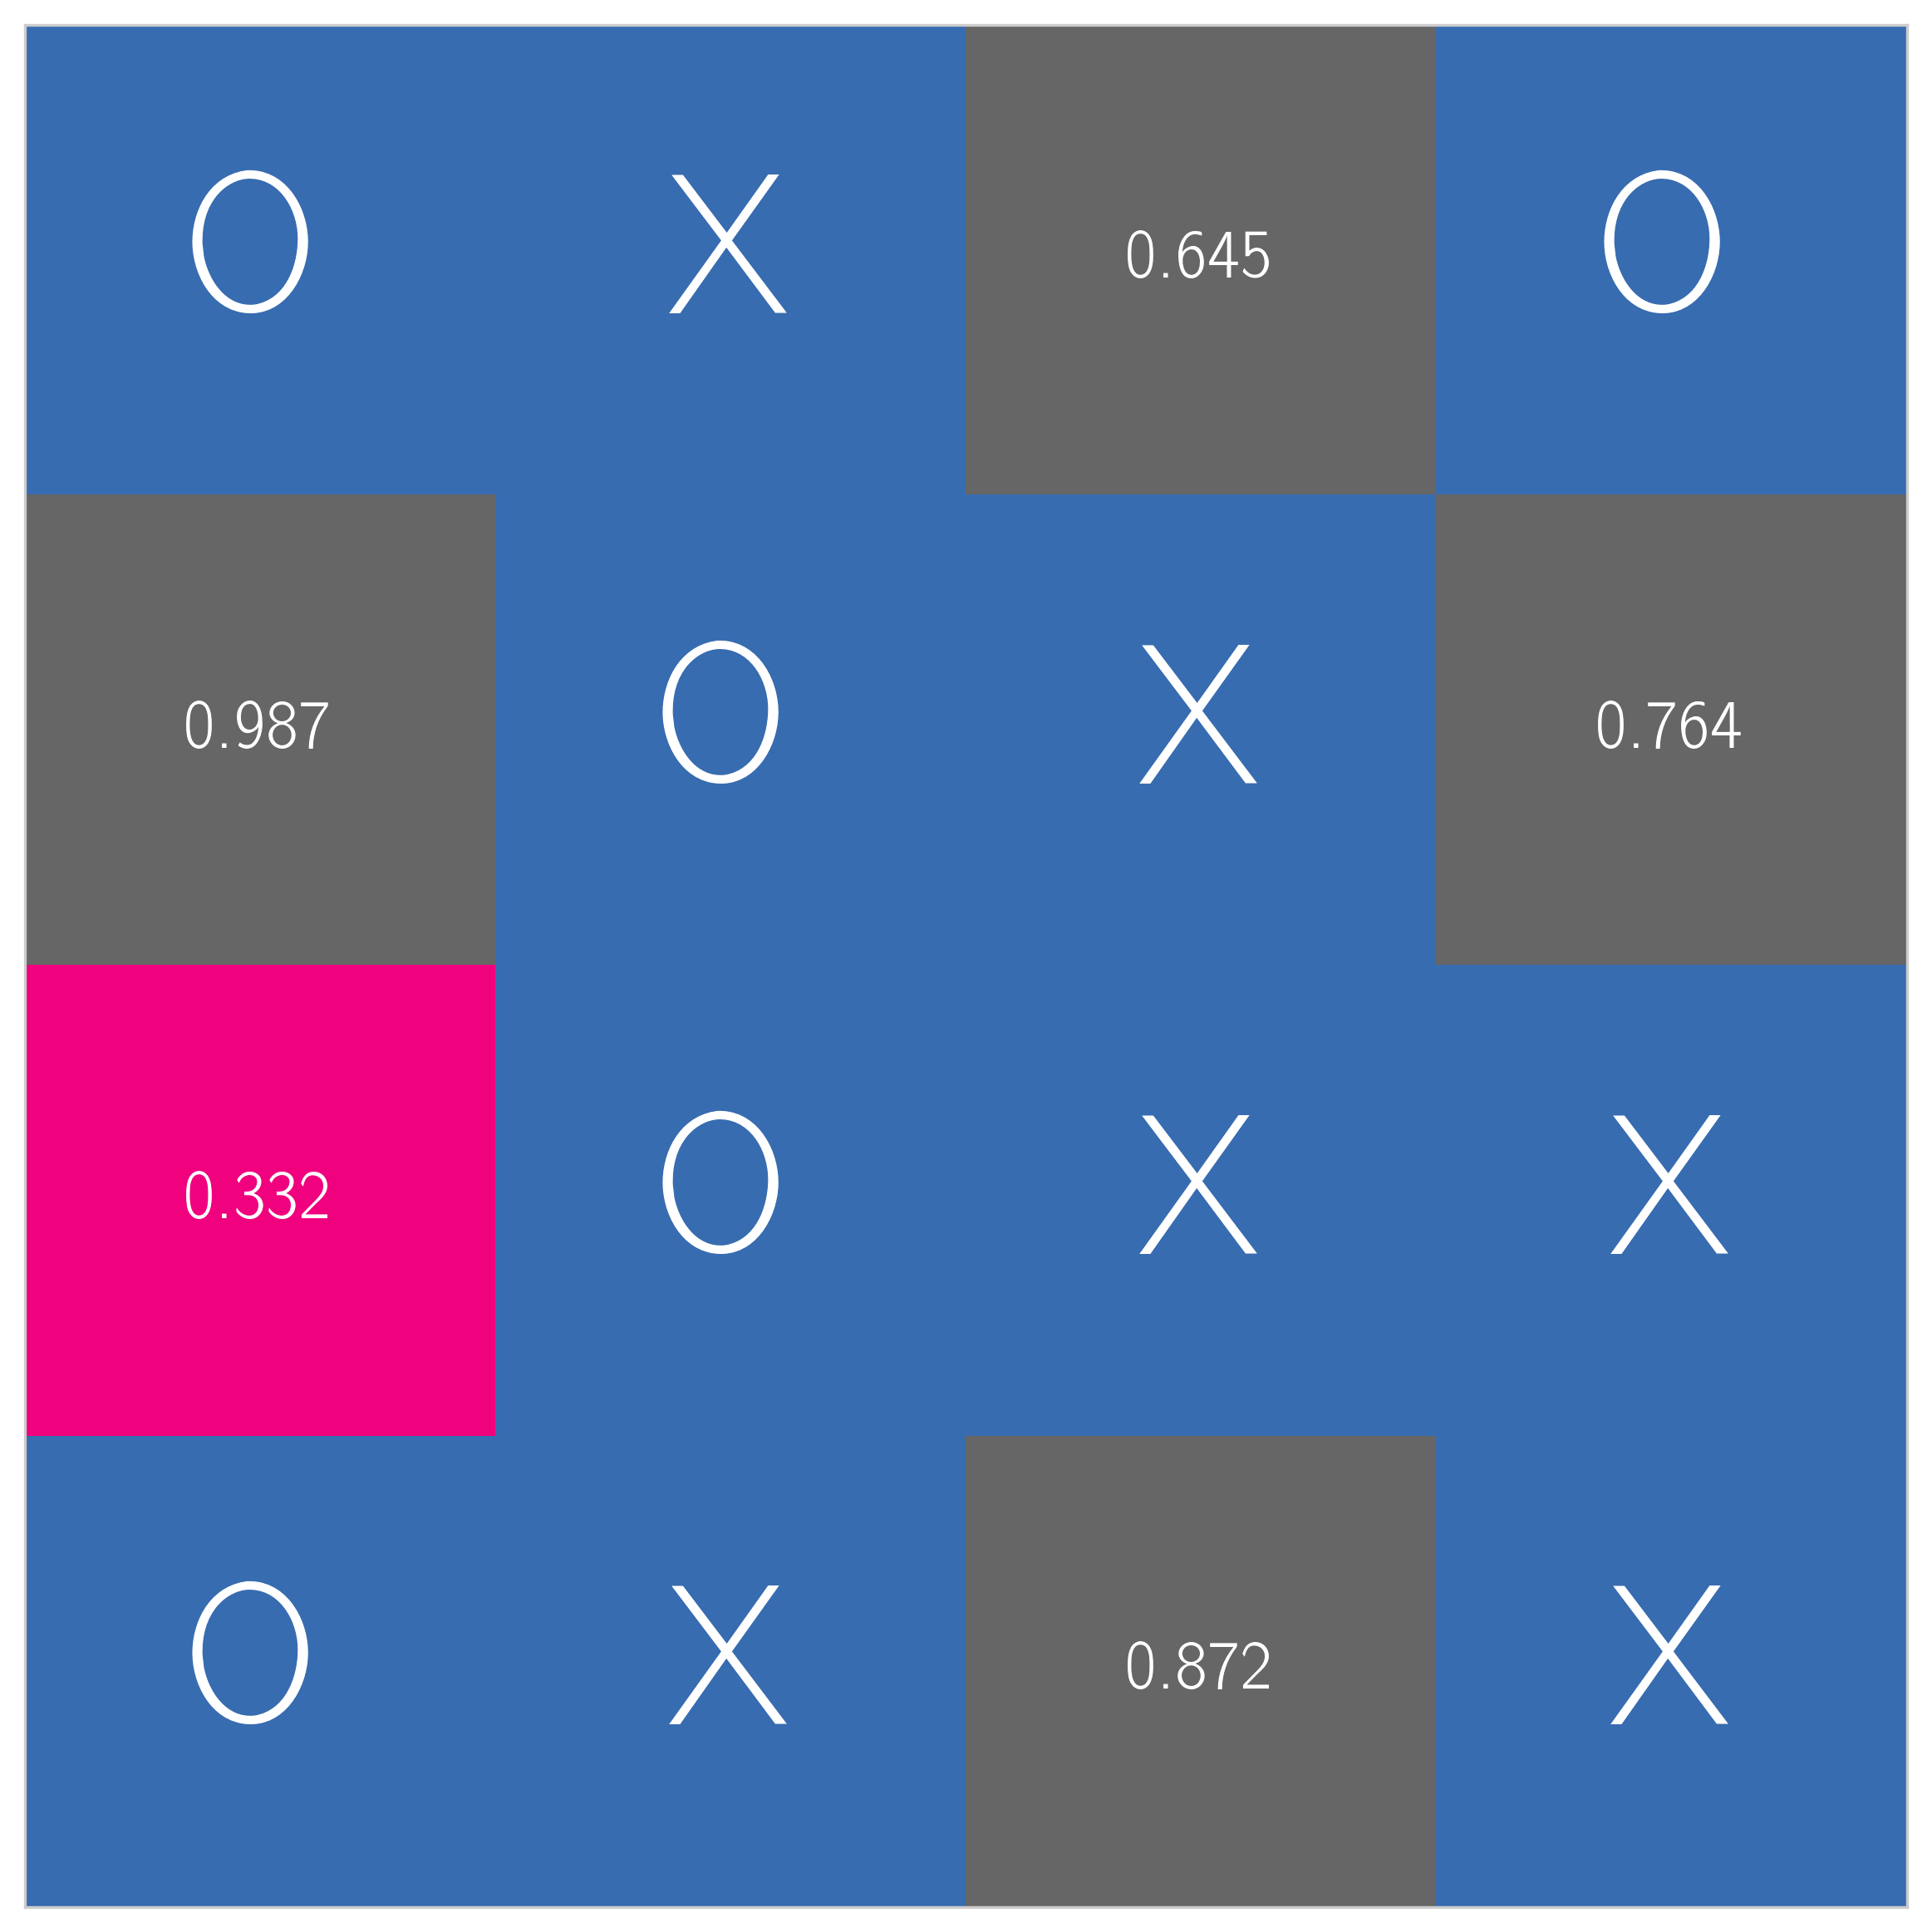

0 [0 2] 0.6451772637758614
1 [1 0] 0.9868874204542978
2 [1 3] 0.7639985991593924
3 [2 0] 0.3315126909153757
4 [3 2] 0.8715153572661629


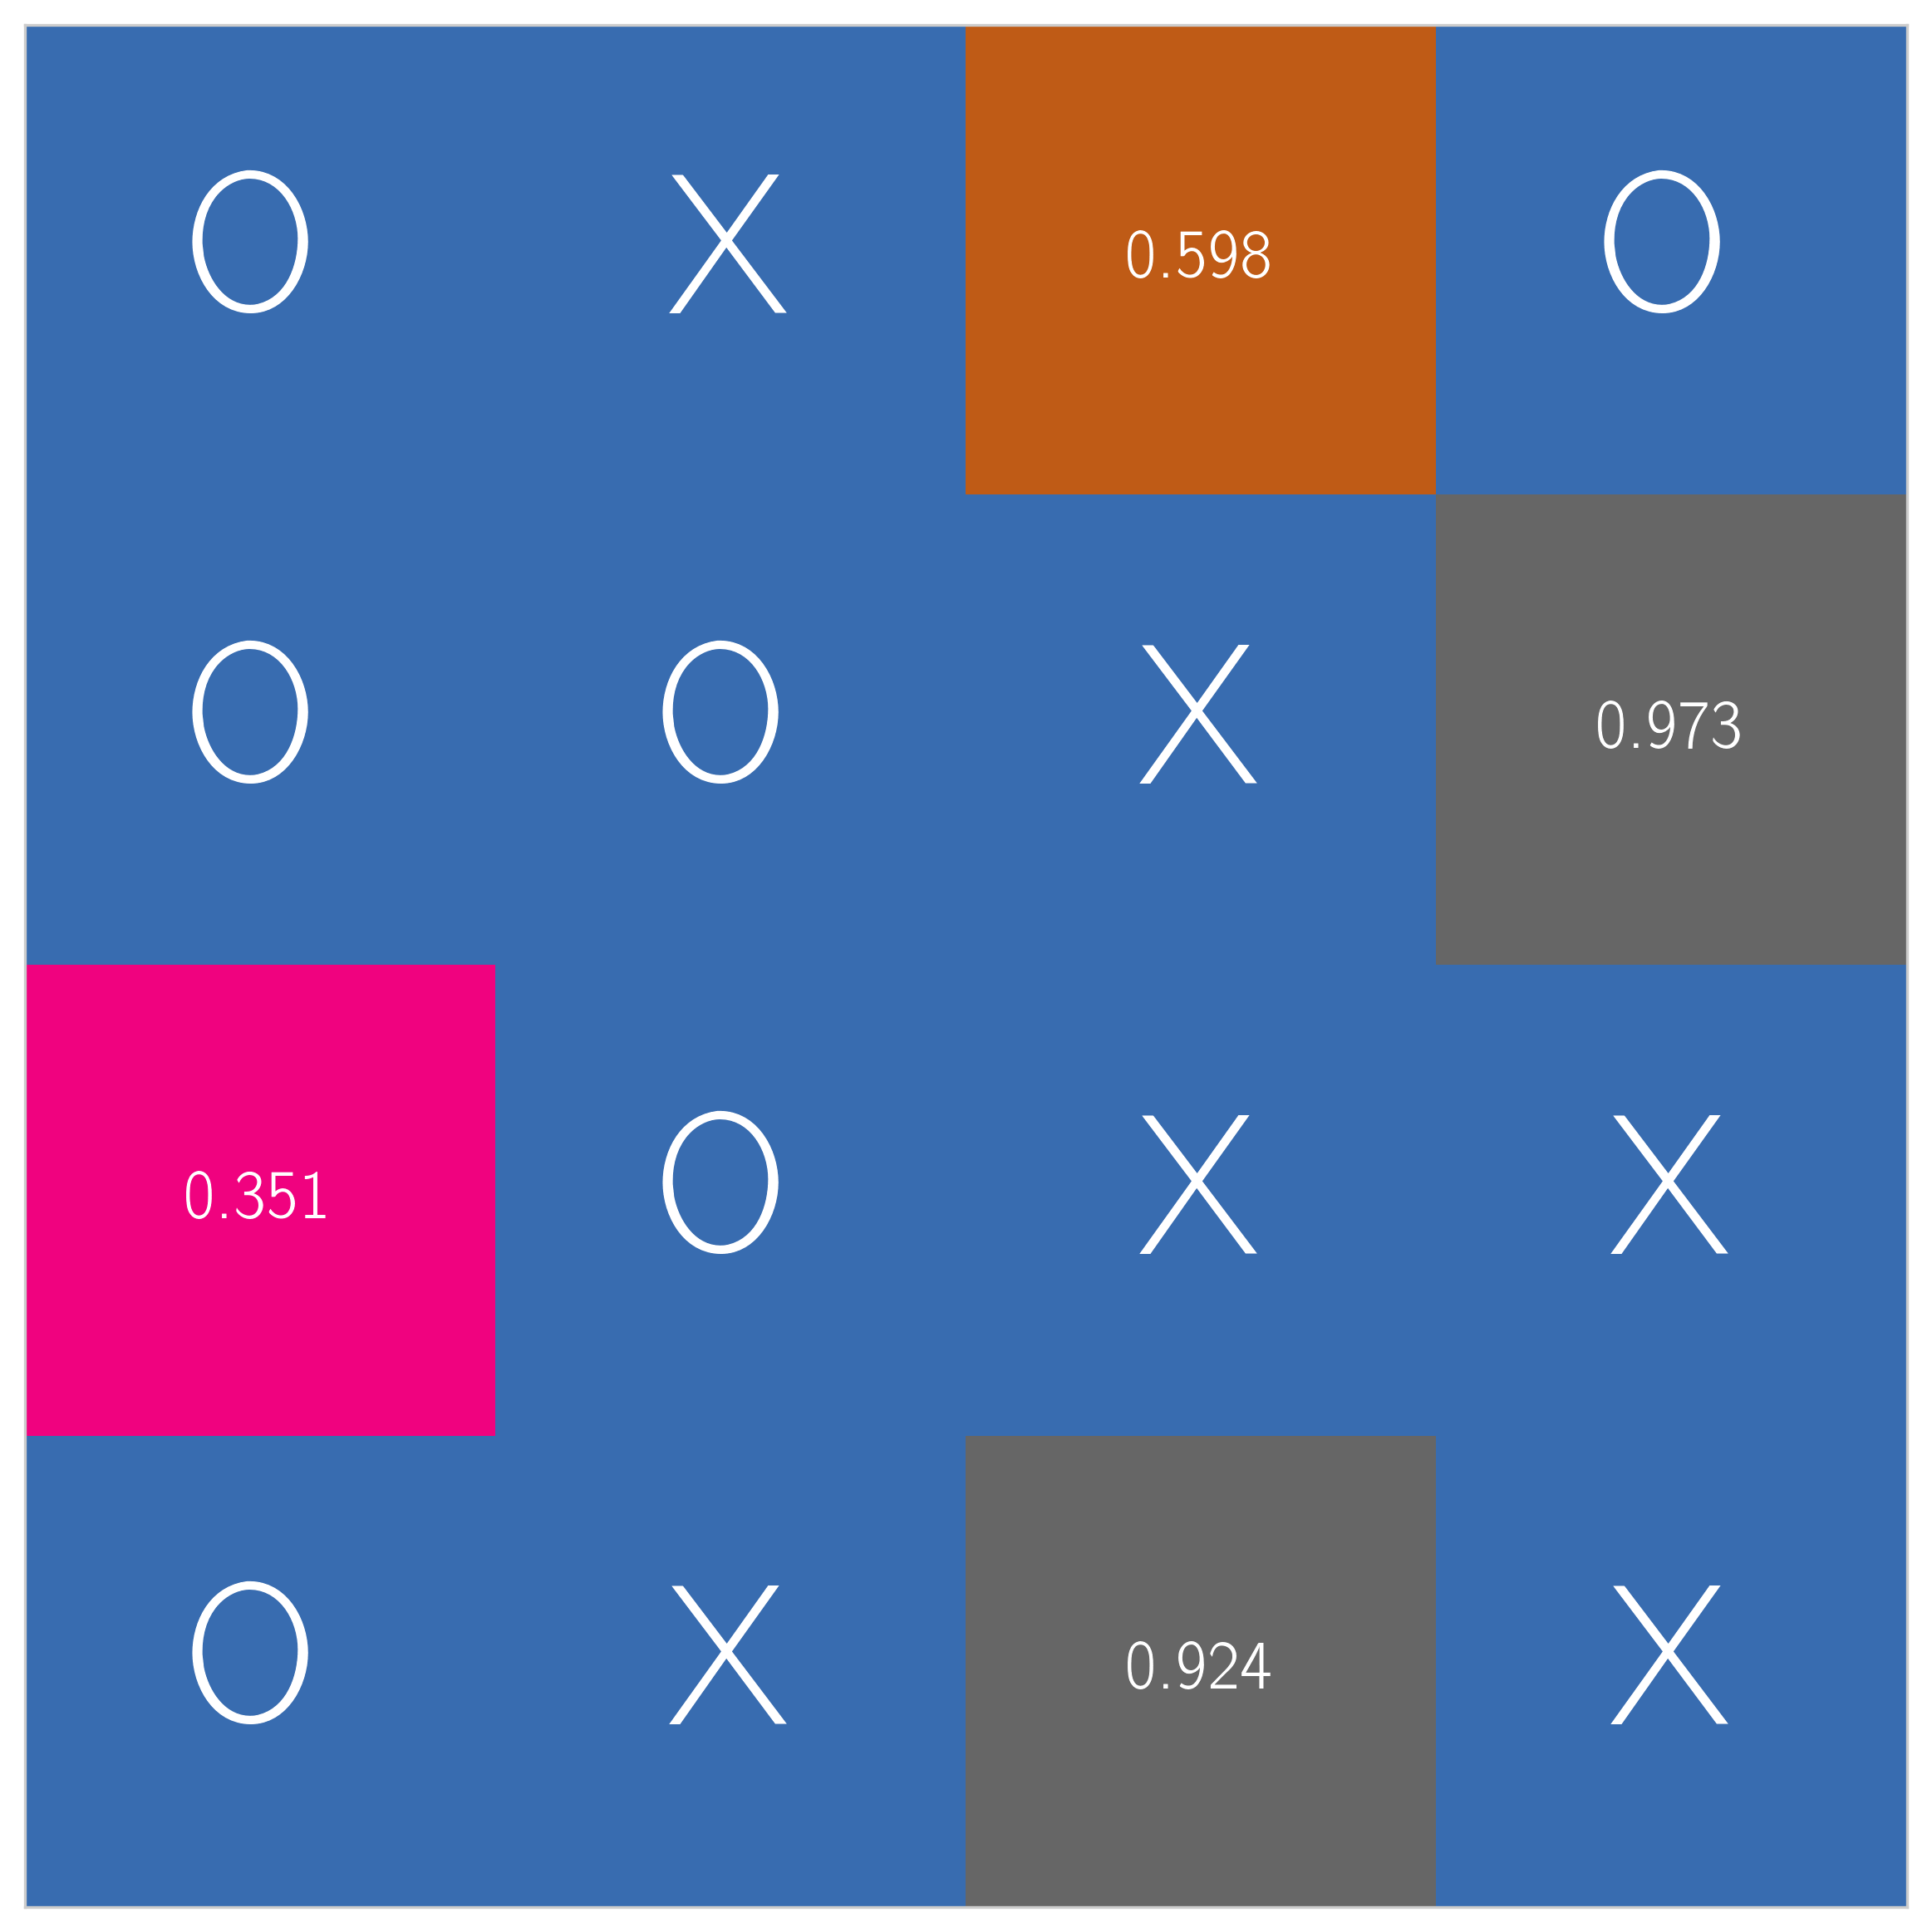

0 [0 2] 0.598121063950946
1 [1 3] 0.9730248099910361
2 [2 0] 0.3514635811215112
3 [3 2] 0.9240984847930213


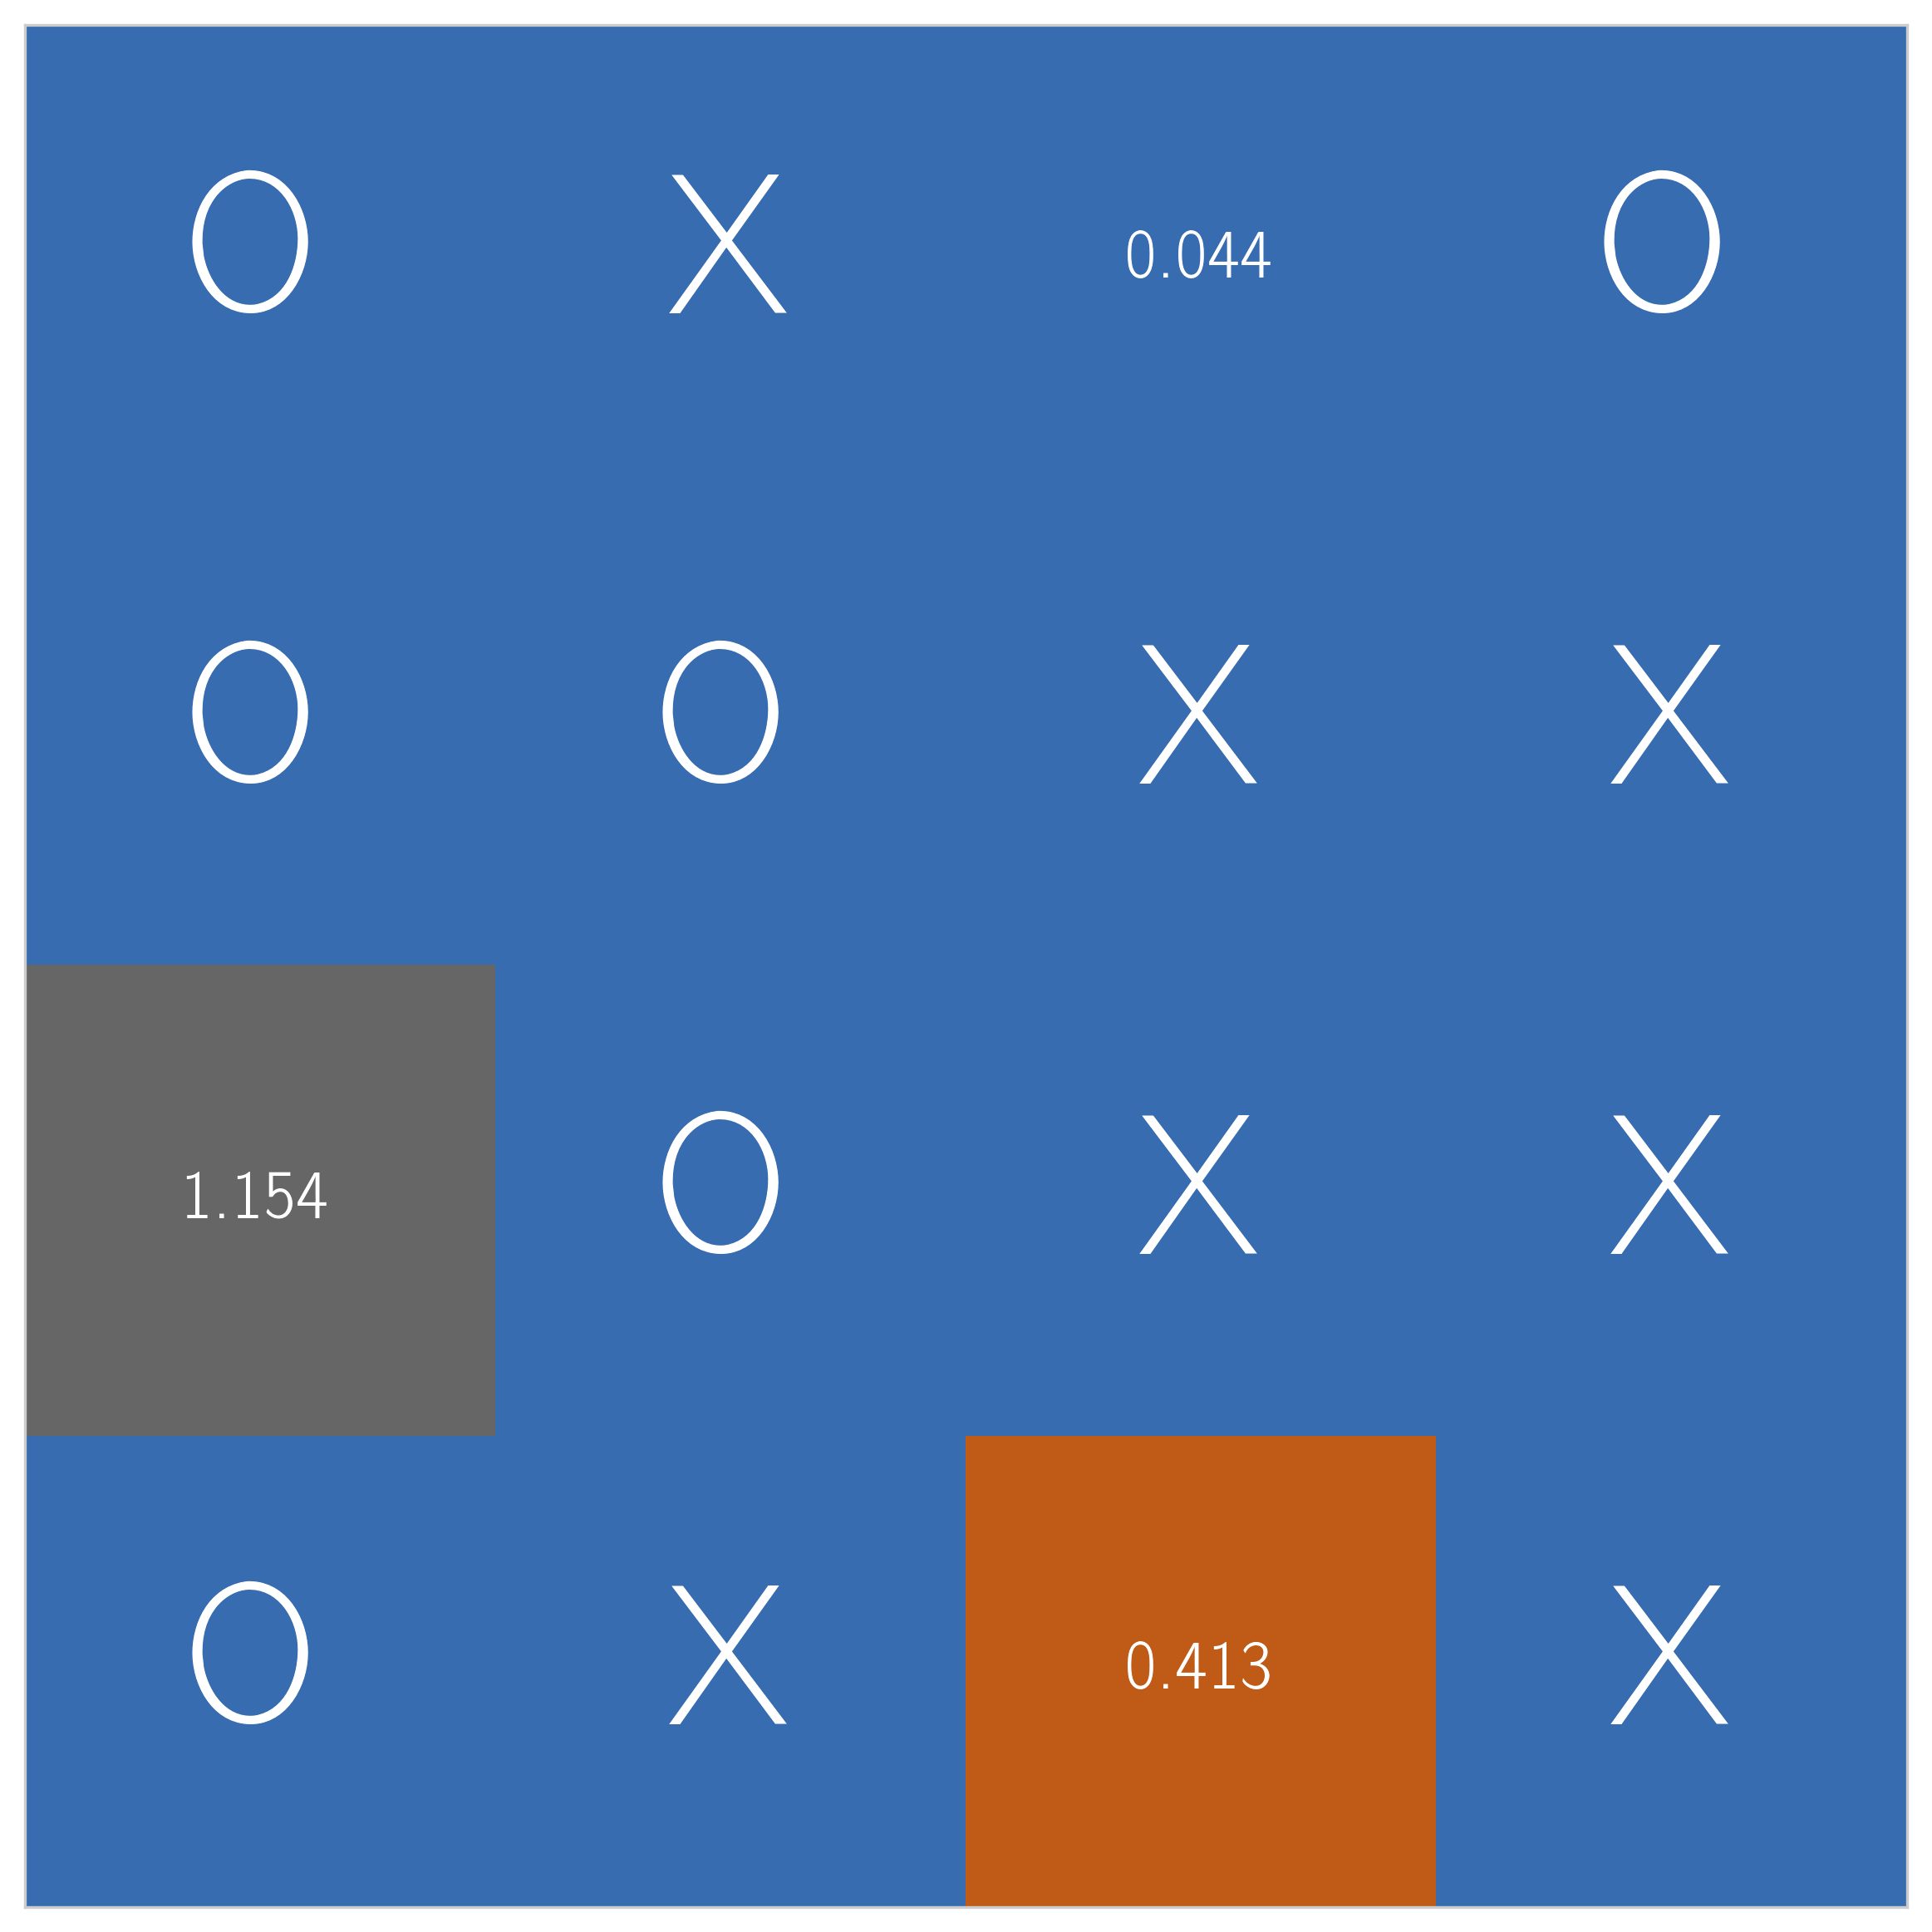

0 [0 2] 0.04437924663764292
1 [2 0] 1.1540131008482273
2 [3 2] 0.41297923152401483
Нолики выиграли!


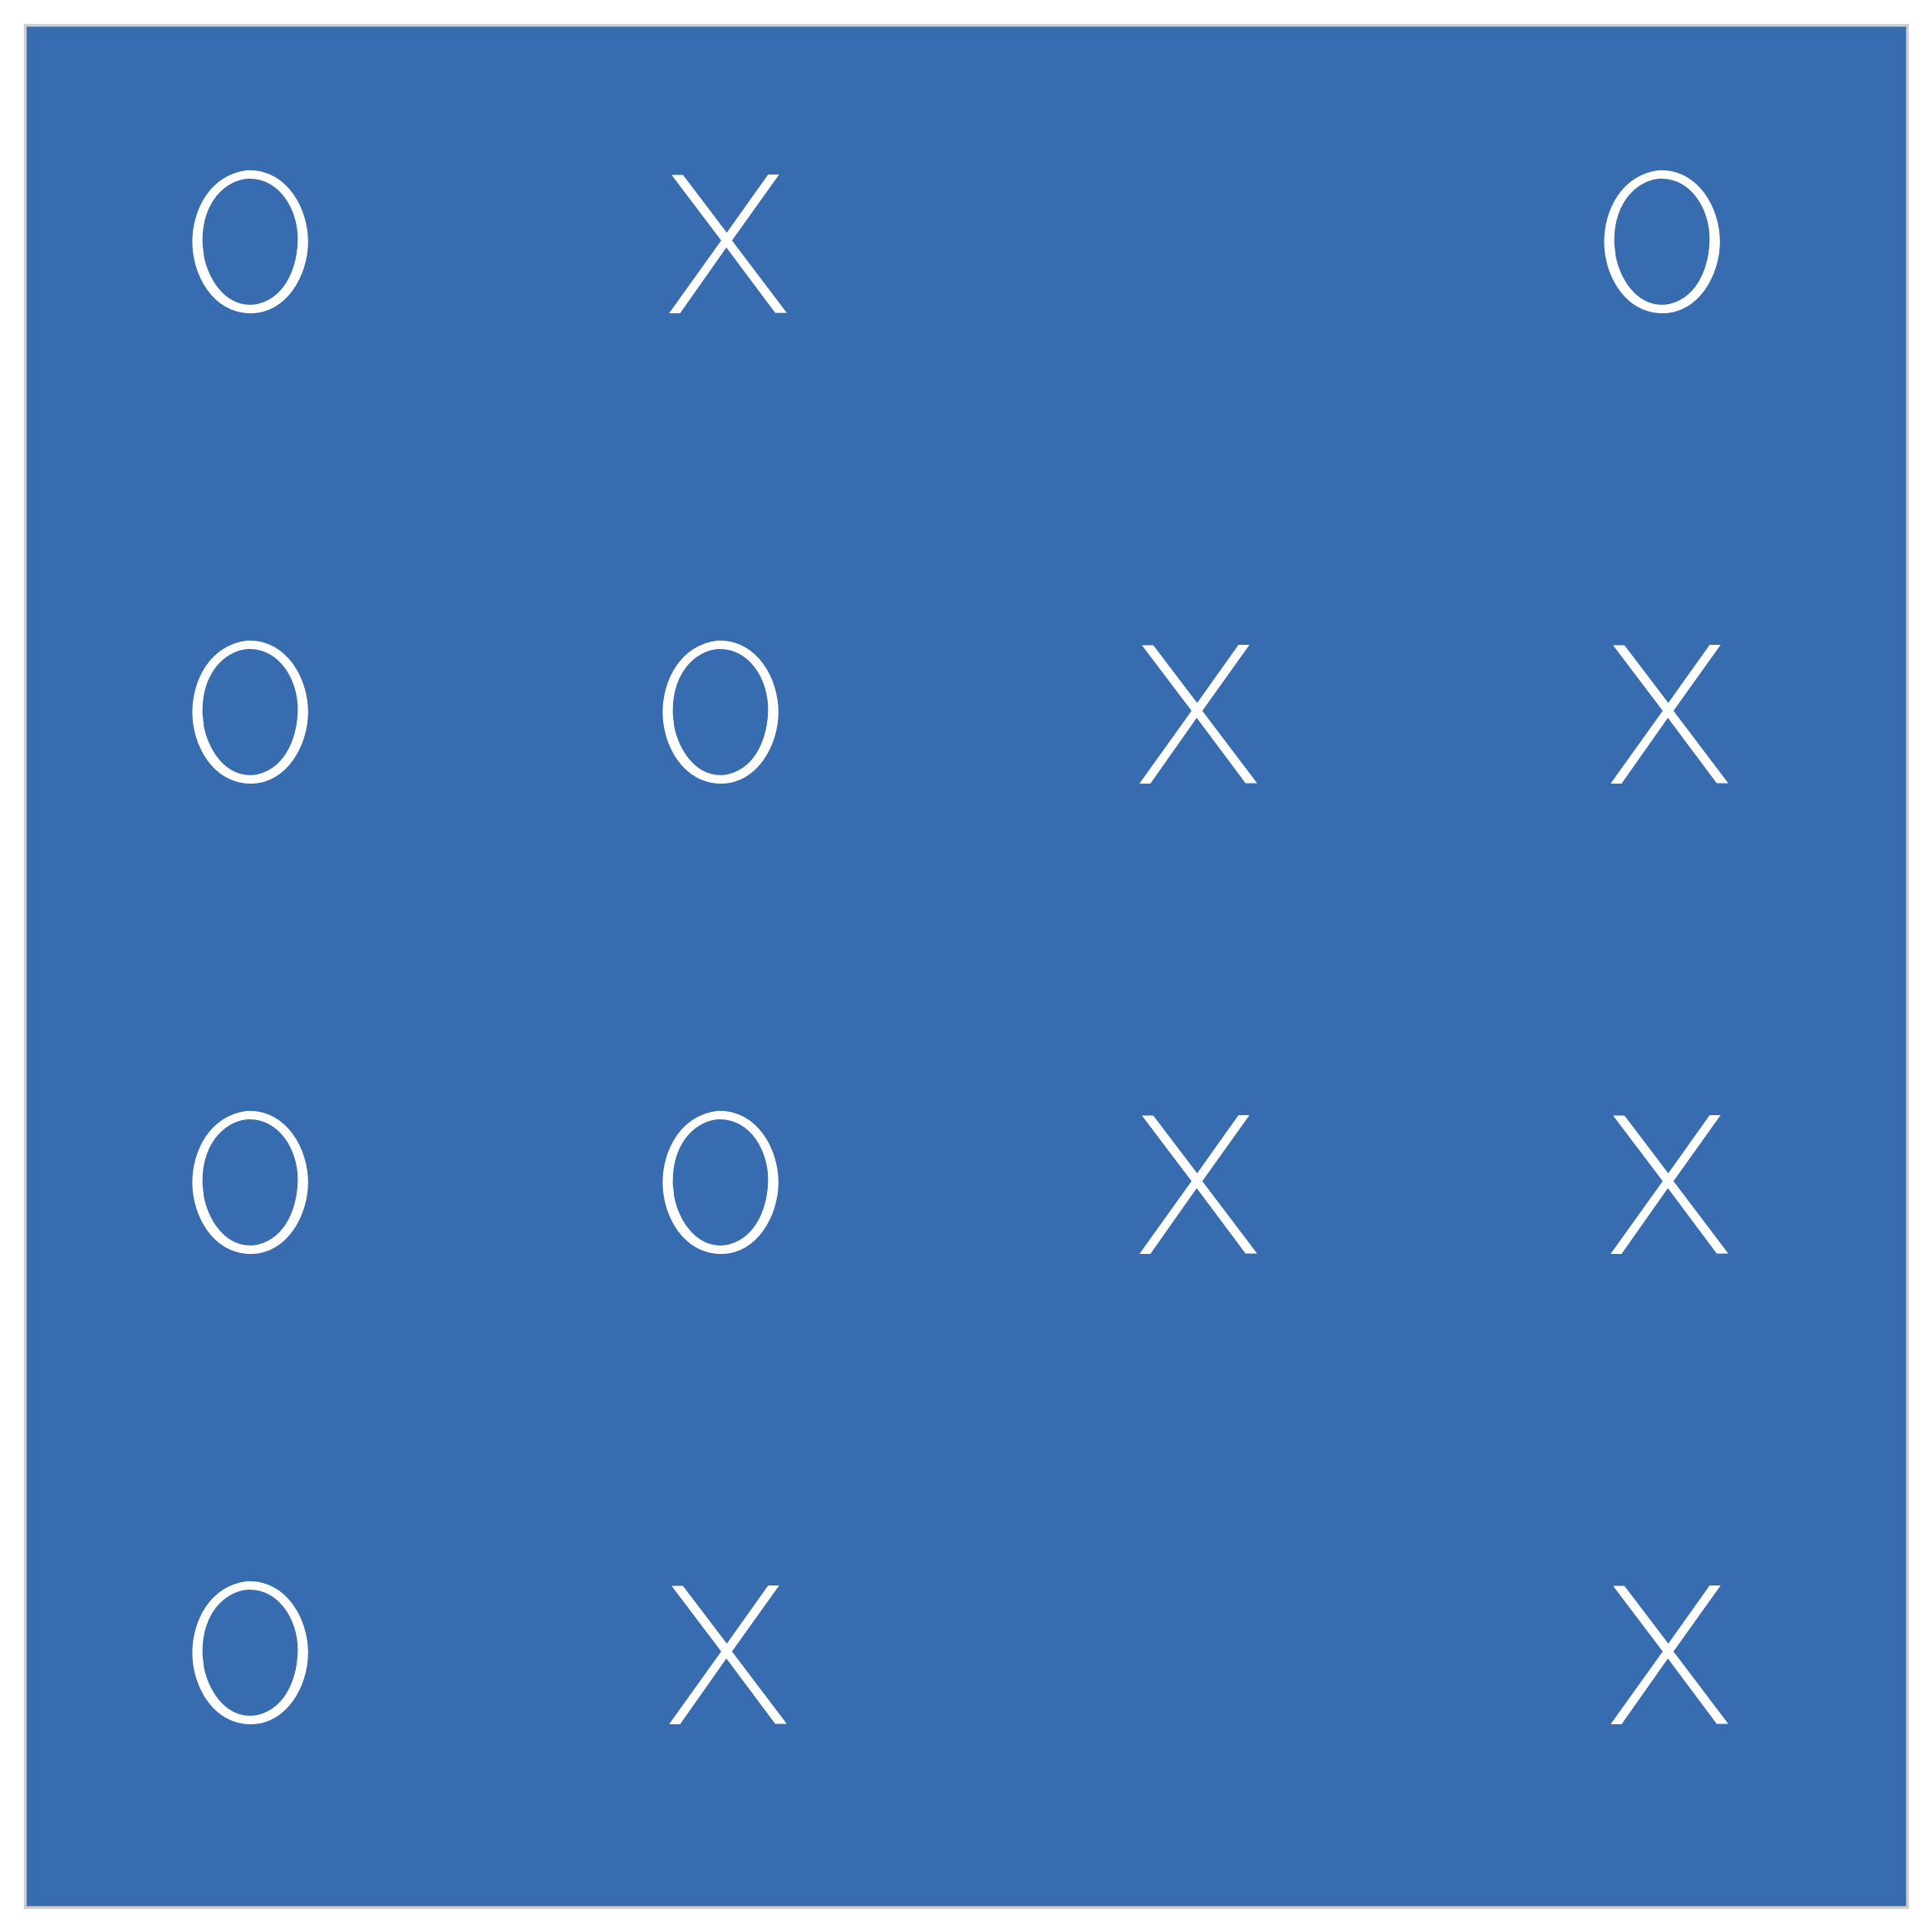

In [28]:
plot_test_game(env, pi_crosses, pi_naughts, random_crosses=False, random_naughts=False, verbose=True, fontq=20, fontx=60)

Обучение идет довольно долго, ждать до ожидаемой ничейной стратегии не очень хочется. Если продолжить обучение, преимущество первого хода у крестиков будет нивелировано. 

### Часть 2. Добавим нейронных сетей

In [301]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [540]:
class Network(nn.Module):
    def __init__(self, layer_size=256):
        nn.Module.__init__(self)
#         self.l1 = nn.Conv2d(1, 6, 3, padding = 1)
#         self.l2 = nn.Conv2d(6, 1, 3, padding = 1)
        self.l1 = nn.Flatten()
        self.l2 = nn.Linear(layer_size, 32)
        self.l3 = nn.Linear(32, 64)
        self.l4 = nn.Linear(64, 32)
        self.l5 = nn.Linear(32, layer_size)
        
    def forward(self, x):
        start_shape = x.shape
        x = self.l1(x)
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = x.reshape(start_shape)
        return x

In [541]:
def plot_durations(xs, labels):
    plt.figure(figsize=(10, 5))
    plt.xlabel('Номер эпизода')
    plt.ylabel('Число шагов')
    for i,x in enumerate(xs):
        plt.plot(x, label=labels[i])
    plt.legend(loc="upper left")

In [555]:
class CrossesDQN():
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, opponent = None):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.model = Network(n_rows * n_cols)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        self.act_size = n_rows * n_cols
        self.n_rows = n_rows
        
        self.gamma = 0.99
        self.batch_size = 16
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 2
        self.num_step = 0

    def select_greedy_action(self, state):
        mask = torch.logical_and(state.le(0.5), state.ge(-0.5))
        return torch.tensor([[int(self.model(state).data[0][0].masked_select(mask).argmax())]], dtype=torch.int64)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        #eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        eps_threshold = 0.5
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[np.random.randint(len(self.env.getEmptySpaces()))]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        num_step = 0
        self.env.reset()
        cur_turn = self.env.getState()[2]
        state = self.env.board
        while True:
            state_tensor = torch.tensor([[state]], dtype=torch.float32)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor).numpy()[0][0]
                else:
                    action = self.select_action(state_tensor).numpy()[0][0]
            next_state, reward, done, _ = self.env.step(self.env.getEmptySpaces()[action])
            if not done:
                next_state, reward, done, _ = self.env.step(next_state[1][np.random.randint(len(next_state[1]))])
            next_state_tensor = torch.tensor([[self.env.board]], dtype=torch.float32)
            transition = (state_tensor, torch.tensor([[action]], dtype=torch.int64), next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()
            else:
                self.env.printBoard()

            state = self.env.board
            num_step += 1

            if done:
                self.episode_durations.append(num_step)
                break
        return reward

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state)[0].reshape(-1).gather(0, batch_action.reshape(-1)).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().reshape(-1).max()
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [556]:
avg_results = [0]
dqn = CrossesDQN()

for e in range(10000 + 1):
    if e % 2500 == 0:
        print(e, " episodes completed")
    reward = dqn.run_episode(e)
    avg_results.append((avg_results[-1] * e + reward) / (e + 1))
print("%s\t\t...done!" % (datetime.now().time()))

0  episodes completed
2500  episodes completed
5000  episodes completed
7500  episodes completed
10000  episodes completed
23:33:58.201348		...done!


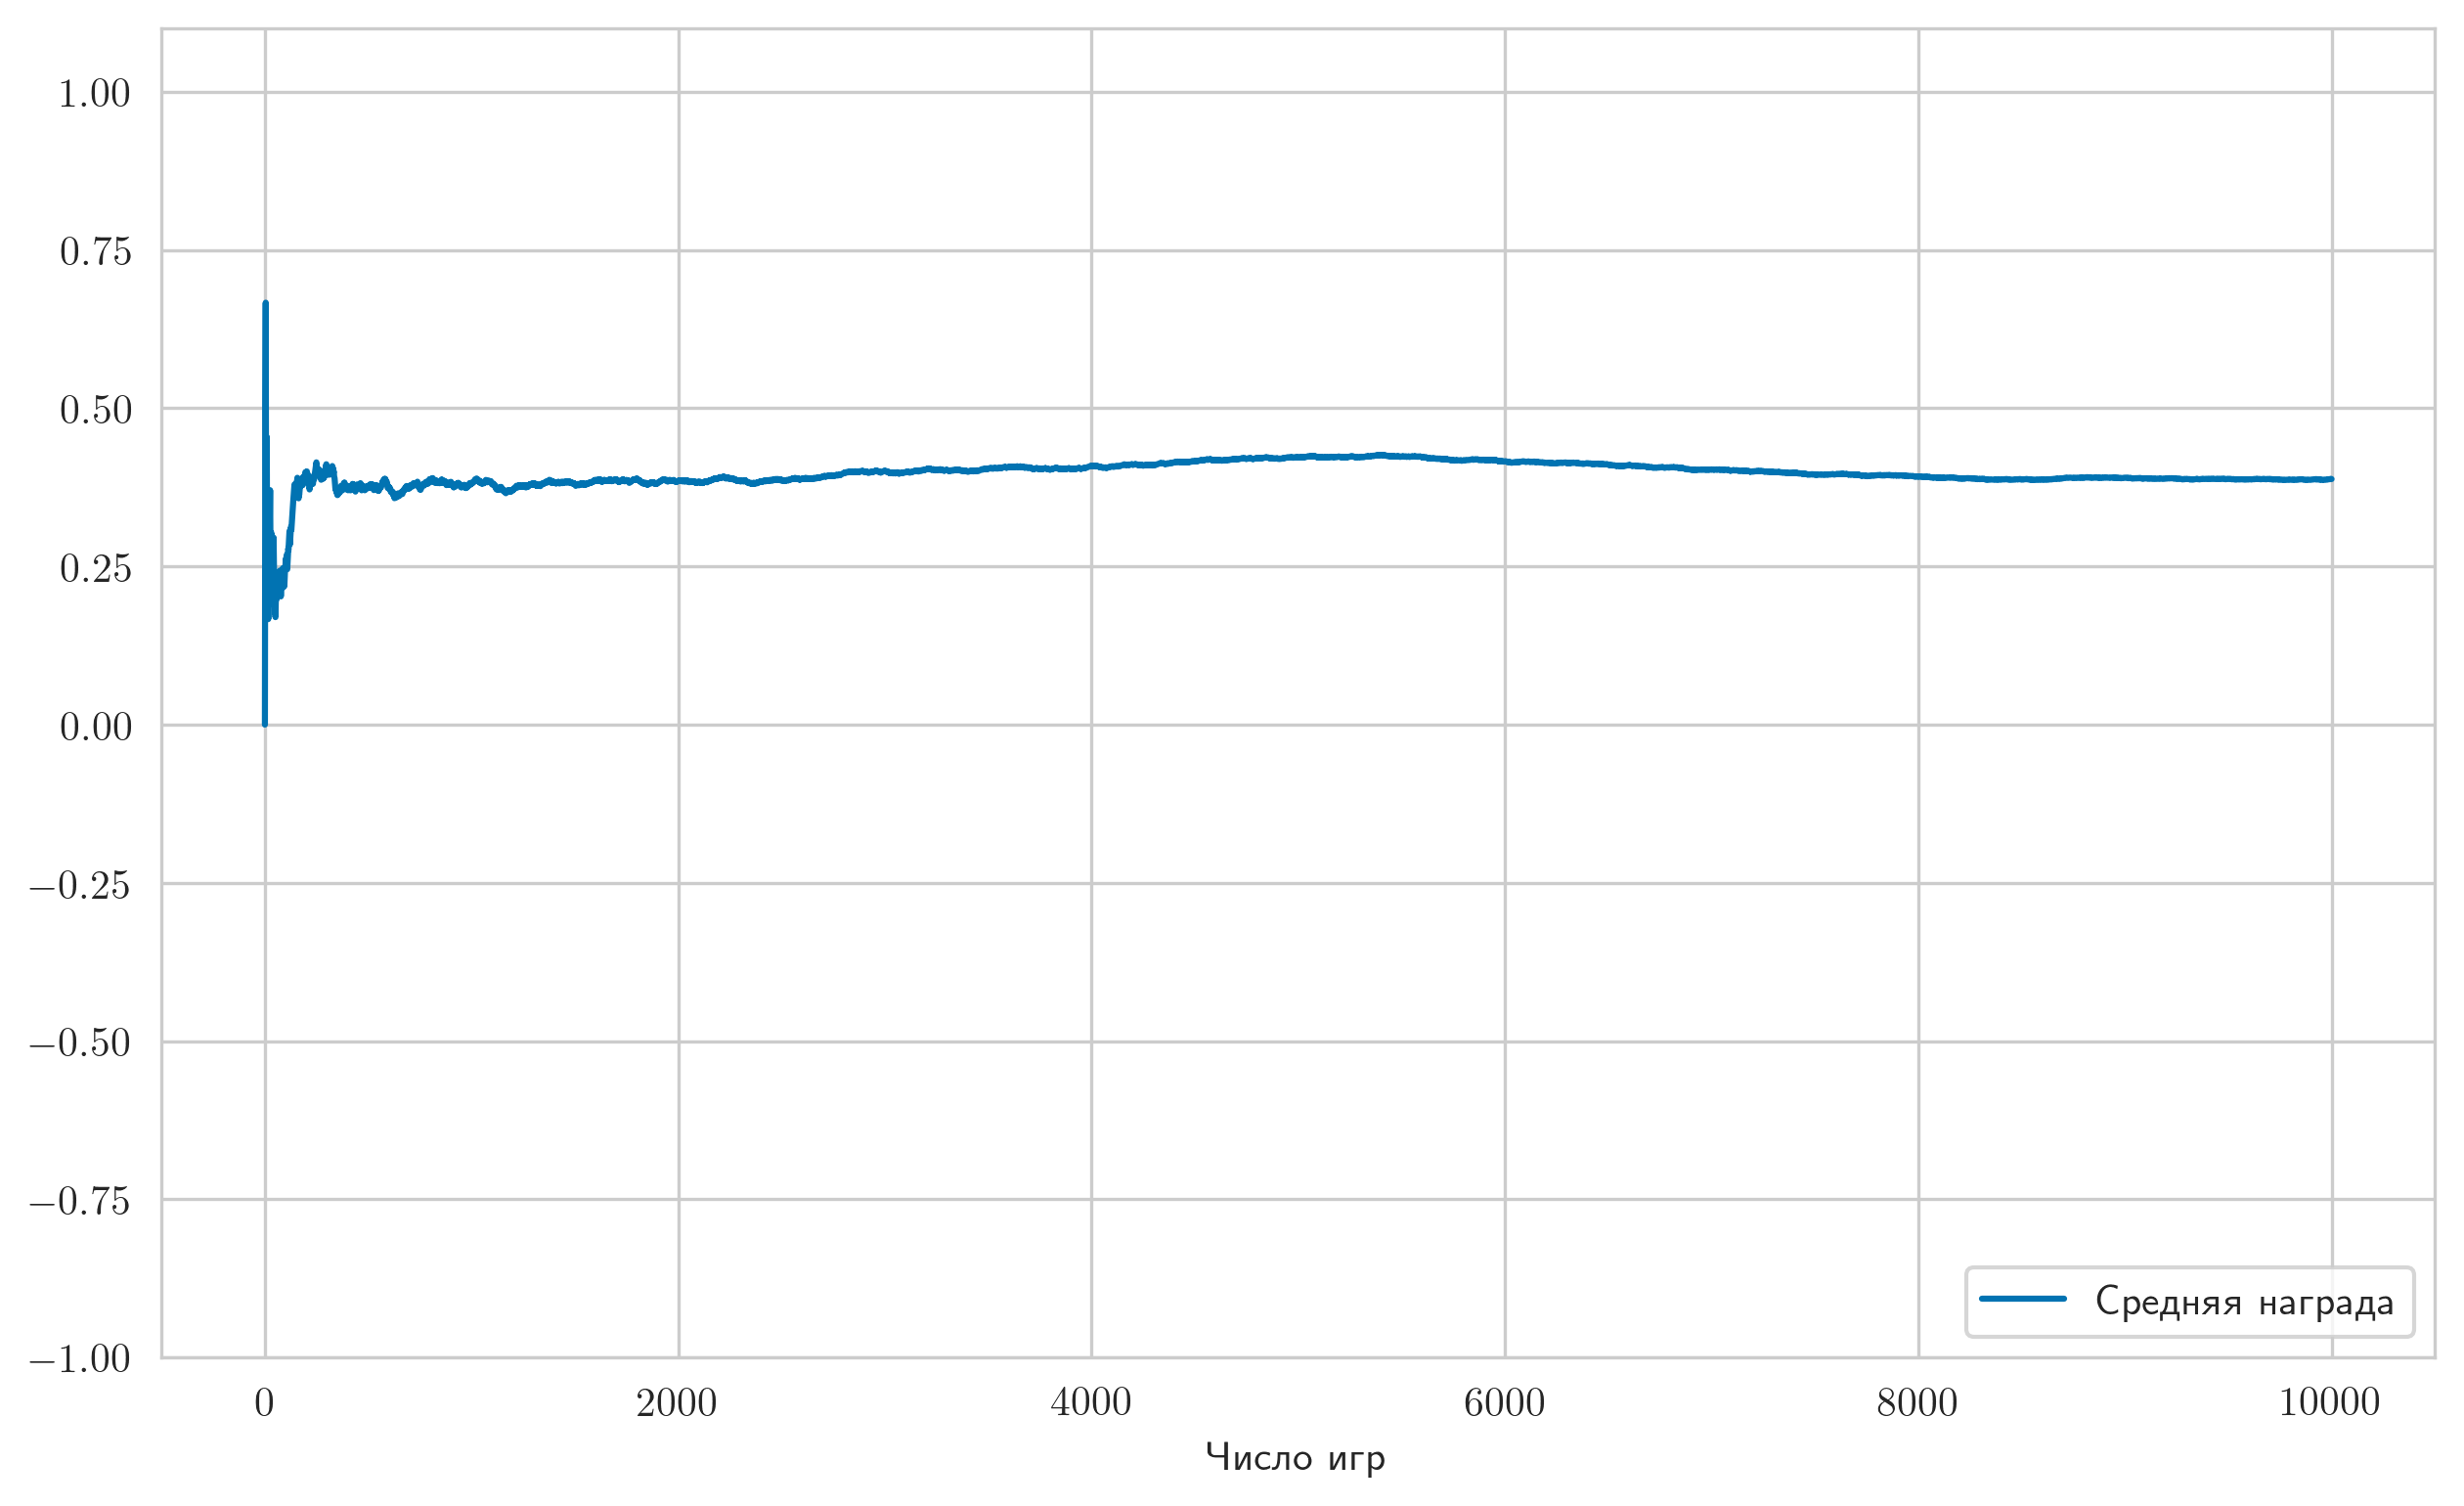

In [557]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
line = ax.plot(np.arange(e), avg_results[2:], label="Средняя награда", color="C0")
ax.legend(loc="lower right")
ax.set_ylim((-1, 1.1))
ax.set_xlabel('Число игр')
plt.show()

In [558]:
dqn.run_episode(do_learning = False)

╭───┬───┬───╮
│   │   │   │ 
├───┼───┼───┤
│   │ o │   │ 
├───┼───┼───┤
│ x │   │   │ 
╰───┴───┴───╯
╭───┬───┬───╮
│ x │ o │   │ 
├───┼───┼───┤
│   │ o │   │ 
├───┼───┼───┤
│ x │   │   │ 
╰───┴───┴───╯
╭───┬───┬───╮
│ x │ o │ x │ 
├───┼───┼───┤
│ o │ o │   │ 
├───┼───┼───┤
│ x │   │   │ 
╰───┴───┴───╯
╭───┬───┬───╮
│ x │ o │ x │ 
├───┼───┼───┤
│ o │ o │ x │ 
├───┼───┼───┤
│ x │ o │   │ 
╰───┴───┴───╯


-1

К сожалению, с помошью DQN не удалось обучить выигрывать даже крестики(